In [54]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb

In [55]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
bert_embeded = pd.read_csv('kaggle-notebook/data/bert_embeded.csv')
tfidf_1000 = pd.read_csv('data/tfidf_1000.csv')
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [56]:
FEATURE_COLS = list(all_new.columns.drop(["id", "state","data_type"]))
tfidf_cols = list(tfidf_1000.columns.drop("id"))
bert_cols = list(bert_embeded.columns.drop("id"))

In [57]:
all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_1000, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df, on="id", how="outer")

In [58]:
print(len(FEATURE_COLS))
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "bins_duration",
    "bins_goal",
    "country+category1",
    "country+category2",
    "category1+category2",
    "bins_duration+bins_goal",
    "coe_country",
    "coe_category1",
    "coe_category2",
    "coe_bins_duration",
    "coe_bins_goal",
    "coe_country+category1",
    "coe_country+category2",
    "coe_category1+category2",
    "coe_bins_duration+bins_goal",
]

TARGET_COLS = ["state"]
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }

2643


In [59]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols, seed):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = KFold(n_splits=7, shuffle=True, random_state=seed)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=5,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [60]:
def check_worst_features(importances, imp_threshold):
    worst_feature_set = set(importances[0].index)
    for n, importance in enumerate(importances):
        df = importance.sort_values('importance')
        worst_features = set(df[df["importance"] < imp_threshold].index)
        worst_feature_set &= worst_features
    return worst_feature_set

def recursive_feature_selection(test_set, train_set, target_cols, feature_cols, categorical_cols, seed):
    worst_exist = True
    while worst_exist == True:
        oof, preds, importances = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols, seed)
        worst_features = check_worst_features(importances, 5)
        if worst_features == set():
            worst_exist = False
        else:
            for feature in worst_features:
                feature_cols.remove(feature)
                for category in categorical_cols:
                    if category not in feature_cols:
                        print(category)
                        categorical_cols.remove(category)
    return oof, preds, importances, feature_cols

In [61]:
def run_stacking(train, test):
    target_cols = "state"
    categorical_cols = CATEGORICAL_COLS
    feature_cols1 = FEATURE_COLS.copy()
    feature_cols2 = FEATURE_COLS.copy()
    feature_cols1.extend(tfidf_cols)
    feature_cols2.extend(bert_cols)
    
    oof1, preds1, _, _ = recursive_feature_selection(test, train, target_cols, feature_cols1, categorical_cols, seed=2020)
    oof2, preds2, _, _ = recursive_feature_selection(test, train, target_cols, feature_cols2, categorical_cols, seed=2021)
    
    train_stack = pd.DataFrame({"id": train["id"], "model1": oof1, "model2": oof2, "state": train["state"]})
    test_stack = pd.DataFrame({"id": test["id"], "model1": preds1, "model2": preds2})
    
    feature_cols3 = ["model1", "model2"]
    oof3, preds3, importances3, _ = recursive_feature_selection(test_stack, train_stack, target_cols, feature_cols3, categorical_cols=None, seed=2022)
    
    return oof3, preds3, importances3

In [62]:
test_set = all_new[all_new["data_type"] == "test"]
train_set = all_new[all_new["data_type"] == "train"]

In [63]:
oof3, preds3, importances3 = run_stacking(train_set, test_set)

[I 2021-01-20 22:56:55,504] A new study created in memory with name: no-name-b05ad587-4a76-497a-8394-bb7a1e3f8a52

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.433718:  14%|#4        | 1/7 [00:06<00:37,  6.21s/it][I 2021-01-20 22:57:01,730] Trial 0 finished with value: 0.4337176747253262 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4337176747253262.

feature_fraction, val_score: 0.433718:  14%|#4        | 1/7 [00:06<00:37,  6.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.431948:  29%|##8       | 2/7 [00:11<00:30,  6.07s/it][I 2021-01-20 22:57:07,464] Trial 1 finished with value: 0.43194765185324596 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.43194765185324596.

feature_fraction, val_score: 0.431948:  29%|##8       | 2/7 [00:11<00:30,  6.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.431948:  43%|####2     | 3/7 [00:18<00:24,  6.12s/it][I 2021-01-20 22:57:13,707] Trial 2 finished with value: 0.43715620352938406 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.43194765185324596.

feature_fraction, val_score: 0.431948:  43%|####2     | 3/7 [00:18<00:24,  6.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.431233:  57%|#####7    | 4/7 [00:24<00:18,  6.17s/it][I 2021-01-20 22:57:19,982] Trial 3 finished with value: 0.43123285813864315 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.43123285813864315.

feature_fraction, val_score: 0.431233:  57%|#####7    | 4/7 [00:24<00:18,  6.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.431233:  71%|#######1  | 5/7 [00:30<00:12,  6.16s/it][I 2021-01-20 22:57:26,130] Trial 4 finished with value: 0.440065979966537 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.43123285813864315.

feature_fraction, val_score: 0.431233:  71%|#######1  | 5/7 [00:30<00:12,  6.16s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.430330:  86%|########5 | 6/7 [00:36<00:05,  5.95s/it][I 2021-01-20 22:57:31,575] Trial 5 finished with value: 0.4303295560630143 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 0.4303295560630143.

feature_fraction, val_score: 0.430330:  86%|########5 | 6/7 [00:36<00:05,  5.95s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



feature_fraction, val_score: 0.430330: 100%|##########| 7/7 [00:41<00:00,  6.00s/it]

num_leaves, val_score: 0.430330:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:   5%|5         | 1/20 [00:05<01:35,  5.04s/it][I 2021-01-20 22:57:42,557] Trial 7 finished with value: 0.4346394852495237 and parameters: {'num_leaves': 19}. Best is trial 7 with value: 0.4346394852495237.

num_leaves, val_score: 0.430330:   5%|5         | 1/20 [00:05<01:35,  5.04s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  10%|#         | 2/20 [00:12<01:42,  5.71s/it][I 2021-01-20 22:57:49,815] Trial 8 finished with value: 0.44853114736805977 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.4346394852495237.

num_leaves, val_score: 0.430330:  10%|#         | 2/20 [00:12<01:42,  5.71s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  15%|#5        | 3/20 [00:18<01:41,  6.00s/it][I 2021-01-20 22:57:56,496] Trial 9 finished with value: 0.4427169118450557 and parameters: {'num_leaves': 151}. Best is trial 7 with value: 0.4346394852495237.

num_leaves, val_score: 0.430330:  15%|#5        | 3/20 [00:18<01:41,  6.00s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  20%|##        | 4/20 [00:23<01:31,  5.70s/it][I 2021-01-20 22:58:01,487] Trial 10 finished with value: 0.43177927993900983 and parameters: {'num_leaves': 4}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  20%|##        | 4/20 [00:23<01:31,  5.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  25%|##5       | 5/20 [00:31<01:35,  6.34s/it][I 2021-01-20 22:58:09,338] Trial 11 finished with value: 0.44598294923993764 and parameters: {'num_leaves': 250}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  25%|##5       | 5/20 [00:31<01:35,  6.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  30%|###       | 6/20 [00:37<01:26,  6.17s/it][I 2021-01-20 22:58:15,120] Trial 12 finished with value: 0.44043116610182653 and parameters: {'num_leaves': 69}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  30%|###       | 6/20 [00:37<01:26,  6.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  35%|###5      | 7/20 [00:44<01:23,  6.45s/it][I 2021-01-20 22:58:22,209] Trial 13 finished with value: 0.4602609320780073 and parameters: {'num_leaves': 242}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  35%|###5      | 7/20 [00:44<01:23,  6.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  40%|####      | 8/20 [00:50<01:16,  6.34s/it][I 2021-01-20 22:58:28,288] Trial 14 finished with value: 0.4392809131816348 and parameters: {'num_leaves': 84}. Best is trial 10 with value: 0.43177927993900983.

feature_fraction, val_score: 0.430330:  57%|#####7    | 4/7 [1:17:50<58:22, 1167.53s/it]


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  45%|####5     | 9/20 [00:58<01:12,  6.63s/it][I 2021-01-20 22:58:35,613] Trial 15 finished with value: 0.44924528807614184 and parameters: {'num_leaves': 205}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  45%|####5     | 9/20 [00:58<01:12,  6.63s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  50%|#####     | 10/20 [01:04<01:05,  6.56s/it][I 2021-01-20 22:58:41,990] Trial 16 finished with value: 0.43223700849732777 and parameters: {'num_leaves': 91}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  50%|#####     | 10/20 [01:04<01:05,  6.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.430330:  55%|#####5    | 11/20 [01:10<00:58,  6.48s/it][I 2021-01-20 22:58:48,275] Trial 17 finished with value: 0.4420080499412317 and parameters: {'num_leaves': 131}. Best is trial 10 with value: 0.43177927993900983.

num_leaves, val_score: 0.430330:  55%|#####5    | 11/20 [01:10<00:58,  6.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  60%|######    | 12/20 [01:16<00:49,  6.15s/it][I 2021-01-20 22:58:53,650] Trial 18 finished with value: 0.42977395992270884 and parameters: {'num_leaves': 41}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  60%|######    | 12/20 [01:16<00:49,  6.15s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  65%|######5   | 13/20 [01:21<00:41,  5.98s/it][I 2021-01-20 22:58:59,231] Trial 19 finished with value: 0.4336573268420122 and parameters: {'num_leaves': 34}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  65%|######5   | 13/20 [01:21<00:41,  5.98s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  70%|#######   | 14/20 [01:27<00:34,  5.83s/it][I 2021-01-20 22:59:04,730] Trial 20 finished with value: 0.44000893348353265 and parameters: {'num_leaves': 62}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  70%|#######   | 14/20 [01:27<00:34,  5.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  75%|#######5  | 15/20 [01:32<00:28,  5.72s/it][I 2021-01-20 22:59:10,189] Trial 21 finished with value: 0.43013528133732115 and parameters: {'num_leaves': 40}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  75%|#######5  | 15/20 [01:32<00:28,  5.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  80%|########  | 16/20 [01:38<00:22,  5.65s/it][I 2021-01-20 22:59:15,671] Trial 22 finished with value: 0.43421282902830205 and parameters: {'num_leaves': 45}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  80%|########  | 16/20 [01:38<00:22,  5.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  85%|########5 | 17/20 [01:44<00:17,  5.78s/it][I 2021-01-20 22:59:21,772] Trial 23 finished with value: 0.45388677604559907 and parameters: {'num_leaves': 114}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  85%|########5 | 17/20 [01:44<00:17,  5.78s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  90%|######### | 18/20 [01:48<00:10,  5.47s/it][I 2021-01-20 22:59:26,498] Trial 24 finished with value: 0.4412415121396701 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  90%|######### | 18/20 [01:48<00:10,  5.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



num_leaves, val_score: 0.429774:  95%|#########5| 19/20 [01:54<00:05,  5.44s/it][I 2021-01-20 22:59:31,875] Trial 25 finished with value: 0.43013528133732115 and parameters: {'num_leaves': 40}. Best is trial 18 with value: 0.42977395992270884.

num_leaves, val_score: 0.429774:  95%|#########5| 19/20 [01:54<00:05,  5.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031



bagging, val_score: 0.429774:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  10%|#         | 1/10 [00:05<00:49,  5.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.287215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  20%|##        | 2/10 [00:11<00:45,  5.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  30%|###       | 3/10 [00:16<00:38,  5.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  40%|####      | 4/10 [00:22<00:32,  5.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  50%|#####     | 5/10 [00:28<00:28,  5.60s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  60%|######    | 6/10 [00:33<00:22,  5.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  70%|#######   | 7/10 [00:40<00:17,  5.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  80%|########  | 8/10 [00:45<00:11,  5.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429774:  90%|######### | 9/10 [00:50<00:05,  5.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.426194:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.426194:  33%|###3      | 1/3 [00:05<00:11,  5.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.426194:  67%|######6   | 2/3 [00:11<00:05,  5.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426194:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426194:   5%|5         | 1/20 [00:05<01:44,  5.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426194:  10%|#         | 2/20 [00:10<01:38,  5.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426194:  15%|#5        | 3/20 [00:16<01:31,  5.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  20%|##        | 4/20 [00:21<01:28,  5.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  25%|##5       | 5/20 [00:27<01:24,  5.66s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  30%|###       | 6/20 [00:33<01:20,  5.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  35%|###5      | 7/20 [00:39<01:14,  5.77s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  40%|####      | 8/20 [00:45<01:09,  5.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  45%|####5     | 9/20 [00:51<01:03,  5.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  50%|#####     | 10/20 [00:57<00:58,  5.81s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  55%|#####5    | 11/20 [01:03<00:52,  5.82s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  60%|######    | 12/20 [01:08<00:46,  5.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  65%|######5   | 13/20 [01:14<00:40,  5.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  70%|#######   | 14/20 [01:20<00:35,  5.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  75%|#######5  | 15/20 [01:26<00:29,  5.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  80%|########  | 16/20 [01:32<00:23,  5.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  85%|########5 | 17/20 [01:38<00:17,  5.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  90%|######### | 18/20 [01:43<00:11,  5.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426155:  95%|#########5| 19/20 [01:49<00:05,  5.86s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155:  20%|##        | 1/5 [00:05<00:20,  5.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155:  40%|####      | 2/5 [00:10<00:15,  5.18s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155:  60%|######    | 3/5 [00:15<00:10,  5.26s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155:  80%|########  | 4/5 [00:21<00:05,  5.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314232
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426155: 100%|##########| 5/5 [00:27<00:00,  5.41s/it]


importance
country                                         1
duration                                        2
category1                                       0
category2                                      44
number_of_chars                                 1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     1
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:03:14,955] A new study created in memory with name: no-name-a43c2685-7b04-4335-9827-82f87a822fd5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.425011:  14%|#4        | 1/7 [00:06<00:39,  6.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.423917:  29%|##8       | 2/7 [00:13<00:33,  6.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.423917:  43%|####2     | 3/7 [00:20<00:26,  6.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.423087:  57%|#####7    | 4/7 [00:27<00:20,  6.67s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.423087:  71%|#######1  | 5/7 [00:32<00:12,  6.46s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.423087:  86%|########5 | 6/7 [00:39<00:06,  6.50s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:   5%|5         | 1/20 [00:06<02:07,  6.71s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  10%|#         | 2/20 [00:13<02:01,  6.73s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  15%|#5        | 3/20 [00:18<01:47,  6.30s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  20%|##        | 4/20 [00:23<01:34,  5.92s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.422220:  25%|##5       | 5/20 [00:31<01:37,  6.52s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  30%|###       | 6/20 [00:38<01:31,  6.51s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  35%|###5      | 7/20 [00:44<01:24,  6.49s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  40%|####      | 8/20 [00:50<01:15,  6.31s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  45%|####5     | 9/20 [00:57<01:12,  6.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  50%|#####     | 10/20 [01:04<01:04,  6.48s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  55%|#####5    | 11/20 [01:12<01:02,  6.95s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.422220:  60%|######    | 12/20 [01:17<00:50,  6.37s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.420910:  65%|######5   | 13/20 [01:22<00:43,  6.23s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.420910:  70%|#######   | 14/20 [01:28<00:36,  6.13s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.418126:  75%|#######5  | 15/20 [01:34<00:30,  6.06s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.418126:  80%|########  | 16/20 [01:40<00:24,  6.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.418126:  85%|########5 | 17/20 [01:46<00:17,  5.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.418126:  90%|######### | 18/20 [01:52<00:12,  6.05s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.418126:  95%|#########5| 19/20 [01:59<00:06,  6.25s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.418126:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.418126:  10%|#         | 1/10 [00:05<00:53,  5.90s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.418126:  20%|##        | 2/10 [00:11<00:45,  5.66s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.418126:  30%|###       | 3/10 [00:16<00:38,  5.53s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  40%|####      | 4/10 [00:22<00:33,  5.65s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  50%|#####     | 5/10 [00:27<00:28,  5.69s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  60%|######    | 6/10 [00:33<00:23,  5.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  70%|#######   | 7/10 [00:39<00:17,  5.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  80%|########  | 8/10 [00:45<00:11,  5.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.417490:  90%|######### | 9/10 [00:51<00:05,  5.77s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.417490:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.417490:  33%|###3      | 1/3 [00:06<00:12,  6.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411726:  67%|######6   | 2/3 [00:12<00:06,  6.26s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:   5%|5         | 1/20 [00:06<02:00,  6.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  10%|#         | 2/20 [00:12<01:52,  6.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  15%|#5        | 3/20 [00:17<01:41,  5.95s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  20%|##        | 4/20 [00:23<01:32,  5.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  25%|##5       | 5/20 [00:28<01:27,  5.82s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  30%|###       | 6/20 [00:35<01:22,  5.89s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  35%|###5      | 7/20 [00:41<01:16,  5.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  40%|####      | 8/20 [00:47<01:12,  6.03s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  45%|####5     | 9/20 [00:53<01:07,  6.11s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  50%|#####     | 10/20 [00:59<01:00,  6.06s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  55%|#####5    | 11/20 [01:05<00:55,  6.16s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  60%|######    | 12/20 [01:12<00:50,  6.25s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  65%|######5   | 13/20 [01:18<00:44,  6.30s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  70%|#######   | 14/20 [01:25<00:37,  6.32s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  75%|#######5  | 15/20 [01:31<00:31,  6.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  80%|########  | 16/20 [01:38<00:25,  6.36s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  85%|########5 | 17/20 [01:44<00:19,  6.37s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  90%|######### | 18/20 [01:50<00:12,  6.38s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411726:  95%|#########5| 19/20 [01:57<00:06,  6.43s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726:  20%|##        | 1/5 [00:05<00:23,  5.86s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726:  40%|####      | 2/5 [00:11<00:17,  5.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726:  60%|######    | 3/5 [00:17<00:11,  5.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726:  80%|########  | 4/5 [00:23<00:05,  5.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314295
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411726: 100%|##########| 5/5 [00:28<00:00,  5.71s/it]


importance
country                                         0
duration                                        2
category1                                       0
category2                                      53
number_of_chars                                 2
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:09:54,819] A new study created in memory with name: no-name-aed78beb-8a9c-4678-88eb-b8c5cf27fd3b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.414168:  14%|#4        | 1/7 [00:06<00:37,  6.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.408464:  29%|##8       | 2/7 [00:13<00:33,  6.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.408120:  43%|####2     | 3/7 [00:19<00:25,  6.30s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404126:  57%|#####7    | 4/7 [00:24<00:18,  6.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404126:  71%|#######1  | 5/7 [00:31<00:12,  6.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404103:  86%|########5 | 6/7 [00:38<00:06,  6.33s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:   5%|5         | 1/20 [00:10<03:13, 10.20s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  10%|#         | 2/20 [00:17<02:50,  9.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  15%|#5        | 3/20 [00:27<02:40,  9.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  20%|##        | 4/20 [00:33<02:14,  8.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  25%|##5       | 5/20 [00:41<02:05,  8.37s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  30%|###       | 6/20 [00:51<02:03,  8.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  35%|###5      | 7/20 [01:00<01:56,  8.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  40%|####      | 8/20 [01:06<01:35,  7.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  45%|####5     | 9/20 [01:15<01:30,  8.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.404103:  50%|#####     | 10/20 [01:25<01:28,  8.80s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  55%|#####5    | 11/20 [01:34<01:19,  8.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  60%|######    | 12/20 [01:41<01:07,  8.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.404103:  65%|######5   | 13/20 [01:51<01:00,  8.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  70%|#######   | 14/20 [02:00<00:53,  8.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  75%|#######5  | 15/20 [02:10<00:45,  9.10s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  80%|########  | 16/20 [02:18<00:35,  8.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  85%|########5 | 17/20 [02:27<00:26,  8.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  90%|######### | 18/20 [02:36<00:18,  9.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.401308:  95%|#########5| 19/20 [02:43<00:08,  8.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  10%|#         | 1/10 [00:09<01:28,  9.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.401308:  20%|##        | 2/10 [00:17<01:12,  9.10s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  30%|###       | 3/10 [00:26<01:04,  9.18s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.401308:  40%|####      | 4/10 [00:33<00:51,  8.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  50%|#####     | 5/10 [00:43<00:44,  8.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  60%|######    | 6/10 [00:52<00:35,  8.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  70%|#######   | 7/10 [01:00<00:26,  8.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  80%|########  | 8/10 [01:09<00:17,  8.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.401308:  90%|######### | 9/10 [01:17<00:08,  8.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:  17%|#6        | 1/6 [00:09<00:46,  9.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:  33%|###3      | 2/6 [00:18<00:36,  9.17s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:  50%|#####     | 3/6 [00:26<00:27,  9.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:  67%|######6   | 4/6 [00:36<00:18,  9.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.401308:  83%|########3 | 5/6 [00:45<00:09,  9.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:   5%|5         | 1/20 [00:09<03:09,  9.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  10%|#         | 2/20 [00:19<02:59,  9.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  15%|#5        | 3/20 [00:29<02:49,  9.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  20%|##        | 4/20 [00:39<02:39,  9.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  25%|##5       | 5/20 [00:49<02:29,  9.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  30%|###       | 6/20 [00:59<02:19,  9.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  35%|###5      | 7/20 [01:09<02:09,  9.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  40%|####      | 8/20 [01:19<01:59,  9.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  45%|####5     | 9/20 [01:29<01:50, 10.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  50%|#####     | 10/20 [01:39<01:40, 10.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  55%|#####5    | 11/20 [01:49<01:28,  9.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  60%|######    | 12/20 [01:59<01:18,  9.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  65%|######5   | 13/20 [02:08<01:07,  9.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  70%|#######   | 14/20 [02:18<00:58,  9.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  75%|#######5  | 15/20 [02:27<00:47,  9.53s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  80%|########  | 16/20 [02:37<00:39,  9.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  85%|########5 | 17/20 [02:47<00:29,  9.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  90%|######### | 18/20 [02:57<00:19,  9.92s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.401308:  95%|#########5| 19/20 [03:07<00:09,  9.94s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.401308:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.401308:  20%|##        | 1/5 [00:08<00:32,  8.13s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.401308:  40%|####      | 2/5 [00:17<00:25,  8.54s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.401308:  60%|######    | 3/5 [00:26<00:17,  8.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.401308:  80%|########  | 4/5 [00:35<00:08,  8.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.401308: 100%|##########| 5/5 [00:43<00:00,  8.35s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-01-20 23:19:53,211] Trial 67 finished with value: 0.4111669155670097 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.40900497086674586.
min_data_in_leaf, val_score: 0.401308: 100%|##########| 5/5 [00:43<00:00,  8.63s/it]


importance
country                                         0
duration                                        5
category1                                       0
category2                                      53
number_of_chars                                 4
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:19:55,039] A new study created in memory with name: no-name-7316d6ad-5be9-4587-a7f7-42fa232f725e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  14%|#4        | 1/7 [00:05<00:34,  5.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  29%|##8       | 2/7 [00:11<00:29,  5.88s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  43%|####2     | 3/7 [00:18<00:23,  5.99s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  57%|#####7    | 4/7 [00:25<00:19,  6.39s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  71%|#######1  | 5/7 [00:33<00:13,  6.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.406252:  86%|########5 | 6/7 [00:39<00:06,  6.79s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:   5%|5         | 1/20 [00:07<02:15,  7.14s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  10%|#         | 2/20 [00:13<02:06,  7.04s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  15%|#5        | 3/20 [00:19<01:49,  6.46s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  20%|##        | 4/20 [00:24<01:36,  6.05s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  25%|##5       | 5/20 [00:31<01:37,  6.50s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  30%|###       | 6/20 [00:38<01:31,  6.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  35%|###5      | 7/20 [00:44<01:24,  6.51s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  40%|####      | 8/20 [00:52<01:21,  6.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  45%|####5     | 9/20 [00:59<01:17,  7.01s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  50%|#####     | 10/20 [01:05<01:06,  6.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  55%|#####5    | 11/20 [01:12<01:00,  6.68s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  60%|######    | 12/20 [01:18<00:52,  6.62s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  65%|######5   | 13/20 [01:24<00:44,  6.33s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  70%|#######   | 14/20 [01:31<00:39,  6.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  75%|#######5  | 15/20 [01:38<00:33,  6.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  80%|########  | 16/20 [01:45<00:27,  6.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  85%|########5 | 17/20 [01:53<00:21,  7.05s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  90%|######### | 18/20 [01:58<00:13,  6.59s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.406252:  95%|#########5| 19/20 [02:04<00:06,  6.30s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  10%|#         | 1/10 [00:05<00:48,  5.39s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  20%|##        | 2/10 [00:10<00:43,  5.38s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  30%|###       | 3/10 [00:16<00:39,  5.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  40%|####      | 4/10 [00:21<00:32,  5.44s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  50%|#####     | 5/10 [00:28<00:28,  5.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  60%|######    | 6/10 [00:33<00:22,  5.52s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  70%|#######   | 7/10 [00:38<00:16,  5.49s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  80%|########  | 8/10 [00:43<00:10,  5.35s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.406252:  90%|######### | 9/10 [00:49<00:05,  5.35s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.406252:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.406252:  33%|###3      | 1/3 [00:05<00:11,  5.71s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.406252:  67%|######6   | 2/3 [00:11<00:05,  5.88s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:   5%|5         | 1/20 [00:06<01:53,  6.00s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  10%|#         | 2/20 [00:11<01:47,  5.98s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  15%|#5        | 3/20 [00:17<01:41,  5.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  20%|##        | 4/20 [00:23<01:35,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  25%|##5       | 5/20 [00:29<01:29,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  30%|###       | 6/20 [00:35<01:24,  6.00s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  35%|###5      | 7/20 [00:41<01:17,  5.98s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  40%|####      | 8/20 [00:47<01:11,  5.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  45%|####5     | 9/20 [00:53<01:05,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  50%|#####     | 10/20 [00:59<00:59,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  55%|#####5    | 11/20 [01:05<00:53,  5.98s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  60%|######    | 12/20 [01:11<00:47,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  65%|######5   | 13/20 [01:17<00:41,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  70%|#######   | 14/20 [01:23<00:35,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  75%|#######5  | 15/20 [01:29<00:29,  5.95s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  80%|########  | 16/20 [01:35<00:23,  5.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  85%|########5 | 17/20 [01:40<00:17,  5.79s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  90%|######### | 18/20 [01:46<00:11,  5.70s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.406252:  95%|#########5| 19/20 [01:52<00:05,  5.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252:  20%|##        | 1/5 [00:05<00:21,  5.49s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252:  40%|####      | 2/5 [00:10<00:16,  5.46s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252:  60%|######    | 3/5 [00:16<00:10,  5.48s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252:  80%|########  | 4/5 [00:22<00:05,  5.52s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315322
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.406252: 100%|##########| 5/5 [00:27<00:00,  5.45s/it]


importance
country                                         0
duration                                        1
category1                                       0
category2                                      52
number_of_chars                                 0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:26:32,746] A new study created in memory with name: no-name-7e3e70ee-b059-438d-815a-8e836ad2aa8d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.389402:  14%|#4        | 1/7 [00:05<00:35,  5.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.389402:  29%|##8       | 2/7 [00:12<00:31,  6.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.384581:  43%|####2     | 3/7 [00:20<00:27,  6.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.384581:  57%|#####7    | 4/7 [00:27<00:20,  6.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.384581:  71%|#######1  | 5/7 [00:34<00:13,  6.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.380232:  86%|########5 | 6/7 [00:42<00:07,  7.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:   5%|5         | 1/20 [00:10<03:25, 10.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  10%|#         | 2/20 [00:22<03:17, 10.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  15%|#5        | 3/20 [00:34<03:15, 11.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  20%|##        | 4/20 [00:41<02:41, 10.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  25%|##5       | 5/20 [00:48<02:18,  9.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  30%|###       | 6/20 [00:59<02:13,  9.52s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  35%|###5      | 7/20 [01:10<02:10, 10.03s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  40%|####      | 8/20 [01:19<01:57,  9.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  45%|####5     | 9/20 [01:30<01:51, 10.10s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  50%|#####     | 10/20 [01:37<01:32,  9.30s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  55%|#####5    | 11/20 [01:48<01:27,  9.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  60%|######    | 12/20 [01:56<01:14,  9.33s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  65%|######5   | 13/20 [02:06<01:06,  9.52s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  70%|#######   | 14/20 [02:17<00:58,  9.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  75%|#######5  | 15/20 [02:25<00:46,  9.40s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  80%|########  | 16/20 [02:34<00:36,  9.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  85%|########5 | 17/20 [02:42<00:26,  8.92s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  90%|######### | 18/20 [02:49<00:16,  8.40s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.380232:  95%|#########5| 19/20 [02:56<00:07,  7.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  10%|#         | 1/10 [00:06<00:59,  6.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  20%|##        | 2/10 [00:14<00:55,  6.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  30%|###       | 3/10 [00:21<00:50,  7.19s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  40%|####      | 4/10 [00:27<00:40,  6.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  50%|#####     | 5/10 [00:34<00:33,  6.72s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  60%|######    | 6/10 [00:40<00:25,  6.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  70%|#######   | 7/10 [00:47<00:20,  6.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  80%|########  | 8/10 [00:54<00:13,  6.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.380232:  90%|######### | 9/10 [01:01<00:06,  6.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.380232:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.380232:  33%|###3      | 1/3 [00:07<00:15,  7.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.380232:  67%|######6   | 2/3 [00:15<00:07,  7.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:   5%|5         | 1/20 [00:08<02:38,  8.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  10%|#         | 2/20 [00:16<02:30,  8.37s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  15%|#5        | 3/20 [00:25<02:22,  8.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  20%|##        | 4/20 [00:33<02:13,  8.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  25%|##5       | 5/20 [00:41<02:05,  8.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  30%|###       | 6/20 [00:50<01:56,  8.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  35%|###5      | 7/20 [00:58<01:48,  8.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  40%|####      | 8/20 [01:06<01:40,  8.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  45%|####5     | 9/20 [01:14<01:27,  7.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  50%|#####     | 10/20 [01:22<01:20,  8.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  55%|#####5    | 11/20 [01:30<01:13,  8.19s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  60%|######    | 12/20 [01:39<01:05,  8.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  65%|######5   | 13/20 [01:47<00:57,  8.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  70%|#######   | 14/20 [01:55<00:49,  8.31s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  75%|#######5  | 15/20 [02:04<00:41,  8.31s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  80%|########  | 16/20 [02:12<00:33,  8.31s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  85%|########5 | 17/20 [02:20<00:24,  8.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  90%|######### | 18/20 [02:29<00:17,  8.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380232:  95%|#########5| 19/20 [02:40<00:09,  9.16s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232:  20%|##        | 1/5 [00:08<00:32,  8.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232:  40%|####      | 2/5 [00:16<00:24,  8.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232:  60%|######    | 3/5 [00:24<00:16,  8.06s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232:  80%|########  | 4/5 [00:32<00:08,  8.20s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314327
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380232: 100%|##########| 5/5 [00:40<00:00,  8.05s/it]


importance
country                                         0
duration                                        5
category1                                       0
category2                                      34
number_of_chars                                 1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:35:27,371] A new study created in memory with name: no-name-b738b5bc-18ef-4ed9-906a-40dfb9326c90
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.402762:  14%|#4        | 1/7 [00:06<00:39,  6.52s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.396241:  29%|##8       | 2/7 [00:14<00:34,  6.88s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.396241:  43%|####2     | 3/7 [00:20<00:27,  6.83s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.396241:  57%|#####7    | 4/7 [00:26<00:19,  6.55s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.396241:  71%|#######1  | 5/7 [00:33<00:13,  6.63s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.396241:  86%|########5 | 6/7 [00:40<00:06,  6.67s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:   5%|5         | 1/20 [00:08<02:36,  8.22s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  10%|#         | 2/20 [00:13<02:14,  7.48s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  15%|#5        | 3/20 [00:21<02:05,  7.37s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.396241:  20%|##        | 4/20 [00:31<02:10,  8.17s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  25%|##5       | 5/20 [00:42<02:14,  8.98s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  30%|###       | 6/20 [00:51<02:06,  9.00s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  35%|###5      | 7/20 [01:01<02:00,  9.30s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  40%|####      | 8/20 [01:10<01:50,  9.24s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  45%|####5     | 9/20 [01:19<01:43,  9.40s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  50%|#####     | 10/20 [01:25<01:23,  8.33s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  55%|#####5    | 11/20 [01:33<01:14,  8.30s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  60%|######    | 12/20 [01:43<01:09,  8.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  65%|######5   | 13/20 [01:52<01:00,  8.60s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  70%|#######   | 14/20 [02:00<00:52,  8.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  75%|#######5  | 15/20 [02:07<00:40,  8.16s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  80%|########  | 16/20 [02:18<00:35,  8.79s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  85%|########5 | 17/20 [02:27<00:26,  8.98s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.396241:  90%|######### | 18/20 [02:37<00:18,  9.28s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.396241:  95%|#########5| 19/20 [02:46<00:09,  9.07s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  10%|#         | 1/10 [00:06<00:58,  6.52s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  20%|##        | 2/10 [00:12<00:49,  6.21s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  30%|###       | 3/10 [00:17<00:42,  6.07s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  40%|####      | 4/10 [00:24<00:37,  6.25s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  50%|#####     | 5/10 [00:31<00:32,  6.44s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  60%|######    | 6/10 [00:38<00:26,  6.61s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  70%|#######   | 7/10 [00:44<00:19,  6.45s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  80%|########  | 8/10 [00:50<00:12,  6.31s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.396241:  90%|######### | 9/10 [00:57<00:06,  6.49s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:  17%|#6        | 1/6 [00:06<00:33,  6.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:  33%|###3      | 2/6 [00:13<00:26,  6.67s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:  50%|#####     | 3/6 [00:20<00:20,  6.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:  67%|######6   | 4/6 [00:26<00:13,  6.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.396241:  83%|########3 | 5/6 [00:33<00:06,  6.81s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:   5%|5         | 1/20 [00:07<02:19,  7.32s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  10%|#         | 2/20 [00:14<02:10,  7.25s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  15%|#5        | 3/20 [00:21<02:03,  7.26s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  20%|##        | 4/20 [00:28<01:55,  7.19s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  25%|##5       | 5/20 [00:36<01:51,  7.45s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  30%|###       | 6/20 [00:43<01:40,  7.17s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  35%|###5      | 7/20 [00:51<01:36,  7.43s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  40%|####      | 8/20 [00:58<01:29,  7.47s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  45%|####5     | 9/20 [01:05<01:18,  7.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  50%|#####     | 10/20 [01:13<01:13,  7.39s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  55%|#####5    | 11/20 [01:19<01:03,  7.09s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  60%|######    | 12/20 [01:27<00:59,  7.38s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  65%|######5   | 13/20 [01:35<00:52,  7.56s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  70%|#######   | 14/20 [01:43<00:46,  7.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  75%|#######5  | 15/20 [01:51<00:38,  7.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  80%|########  | 16/20 [01:59<00:31,  7.84s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  85%|########5 | 17/20 [02:07<00:23,  7.89s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  90%|######### | 18/20 [02:14<00:15,  7.70s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.396241:  95%|#########5| 19/20 [02:22<00:07,  7.77s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241:  20%|##        | 1/5 [00:06<00:27,  6.96s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241:  40%|####      | 2/5 [00:13<00:20,  6.83s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241:  60%|######    | 3/5 [00:19<00:13,  6.73s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241:  80%|########  | 4/5 [00:26<00:06,  6.75s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314292
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.396241: 100%|##########| 5/5 [00:33<00:00,  6.73s/it]


importance
country                                         0
duration                                        1
category1                                       0
category2                                      50
number_of_chars                                 0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:44:01,242] A new study created in memory with name: no-name-bd67c463-ed84-45ce-9a5c-df816fadc1aa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403720:  14%|#4        | 1/7 [00:07<00:47,  7.92s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403720:  29%|##8       | 2/7 [00:15<00:38,  7.76s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.399669:  43%|####2     | 3/7 [00:22<00:30,  7.59s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.399669:  57%|#####7    | 4/7 [00:30<00:22,  7.66s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.399669:  71%|#######1  | 5/7 [00:35<00:14,  7.06s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.399669:  86%|########5 | 6/7 [00:42<00:07,  7.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:   5%|5         | 1/20 [00:08<02:39,  8.38s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  10%|#         | 2/20 [00:18<02:38,  8.82s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  15%|#5        | 3/20 [00:28<02:39,  9.36s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  20%|##        | 4/20 [00:35<02:14,  8.41s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  25%|##5       | 5/20 [00:43<02:06,  8.45s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  30%|###       | 6/20 [00:53<02:03,  8.82s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399669:  35%|###5      | 7/20 [01:03<02:00,  9.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  40%|####      | 8/20 [01:09<01:40,  8.35s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  45%|####5     | 9/20 [01:17<01:28,  8.06s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  50%|#####     | 10/20 [01:27<01:26,  8.62s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399669:  55%|#####5    | 11/20 [01:36<01:20,  8.91s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  60%|######    | 12/20 [01:44<01:09,  8.65s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  65%|######5   | 13/20 [01:55<01:04,  9.22s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  70%|#######   | 14/20 [02:01<00:50,  8.40s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  75%|#######5  | 15/20 [02:10<00:42,  8.55s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  80%|########  | 16/20 [02:19<00:34,  8.73s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  85%|########5 | 17/20 [02:29<00:27,  9.15s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  90%|######### | 18/20 [02:39<00:18,  9.29s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.399669:  95%|#########5| 19/20 [02:48<00:09,  9.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  10%|#         | 1/10 [00:06<00:53,  6.00s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  20%|##        | 2/10 [00:13<00:51,  6.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  30%|###       | 3/10 [00:19<00:44,  6.35s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  40%|####      | 4/10 [00:25<00:37,  6.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  50%|#####     | 5/10 [00:32<00:31,  6.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  60%|######    | 6/10 [00:39<00:26,  6.64s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  70%|#######   | 7/10 [00:46<00:20,  6.74s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  80%|########  | 8/10 [00:54<00:14,  7.02s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399669:  90%|######### | 9/10 [01:00<00:06,  6.96s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:  17%|#6        | 1/6 [00:06<00:34,  6.96s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:  33%|###3      | 2/6 [00:13<00:27,  6.80s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:  50%|#####     | 3/6 [00:21<00:21,  7.17s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:  67%|######6   | 4/6 [00:28<00:14,  7.12s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399669:  83%|########3 | 5/6 [00:35<00:07,  7.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399669:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:   5%|5         | 1/20 [00:08<02:36,  8.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  10%|#         | 2/20 [00:16<02:27,  8.20s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  15%|#5        | 3/20 [00:23<02:13,  7.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  20%|##        | 4/20 [00:31<02:06,  7.93s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  25%|##5       | 5/20 [00:38<01:55,  7.70s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  30%|###       | 6/20 [00:46<01:49,  7.83s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  35%|###5      | 7/20 [00:53<01:38,  7.61s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  40%|####      | 8/20 [01:02<01:33,  7.77s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  45%|####5     | 9/20 [01:10<01:26,  7.89s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  50%|#####     | 10/20 [01:18<01:19,  7.97s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  55%|#####5    | 11/20 [01:25<01:09,  7.69s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  60%|######    | 12/20 [01:33<01:02,  7.81s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  65%|######5   | 13/20 [01:41<00:54,  7.79s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  70%|#######   | 14/20 [01:48<00:46,  7.75s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  75%|#######5  | 15/20 [01:56<00:37,  7.56s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  80%|########  | 16/20 [02:02<00:29,  7.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  85%|########5 | 17/20 [02:10<00:22,  7.40s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  90%|######### | 18/20 [02:17<00:14,  7.43s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.395831:  95%|#########5| 19/20 [02:25<00:07,  7.42s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831:  20%|##        | 1/5 [00:07<00:31,  7.97s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831:  40%|####      | 2/5 [00:16<00:24,  8.02s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831:  60%|######    | 3/5 [00:23<00:15,  7.77s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831:  80%|########  | 4/5 [00:30<00:07,  7.48s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314386
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.395831: 100%|##########| 5/5 [00:37<00:00,  7.46s/it]


importance
country                                         1
duration                                        4
category1                                       0
category2                                      53
number_of_chars                                 0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[3643 rows x 1 columns]

[I 2021-01-20 23:52:49,441] A new study created in memory with name: no-name-80f772e2-c477-452b-bdfc-3c301bd30b4d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

coe_bins_duration
bins_duration+bins_goal
bins_duration
coe_bins_duration+bins_goal
bins_goal
category1
coe_bins_goal
country
coe_country
coe_category1


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.438589:  14%|#4        | 1/7 [00:01<00:08,  1.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.431596:  29%|##8       | 2/7 [00:03<00:07,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.431506:  43%|####2     | 3/7 [00:05<00:06,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428433:  57%|#####7    | 4/7 [00:06<00:04,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428433:  71%|#######1  | 5/7 [00:07<00:02,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428433:  86%|########5 | 6/7 [00:09<00:01,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:   5%|5         | 1/20 [00:01<00:28,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  10%|#         | 2/20 [00:03<00:29,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  15%|#5        | 3/20 [00:05<00:29,  1.76s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  20%|##        | 4/20 [00:06<00:24,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  25%|##5       | 5/20 [00:07<00:21,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  30%|###       | 6/20 [00:09<00:20,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  35%|###5      | 7/20 [00:10<00:19,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  40%|####      | 8/20 [00:12<00:17,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  45%|####5     | 9/20 [00:14<00:17,  1.59s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  50%|#####     | 10/20 [00:15<00:15,  1.60s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  55%|#####5    | 11/20 [00:17<00:16,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  60%|######    | 12/20 [00:19<00:14,  1.87s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  65%|######5   | 13/20 [00:21<00:11,  1.66s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  70%|#######   | 14/20 [00:23<00:11,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  75%|#######5  | 15/20 [00:25<00:09,  1.87s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  80%|########  | 16/20 [00:26<00:06,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  85%|########5 | 17/20 [00:27<00:04,  1.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  90%|######### | 18/20 [00:29<00:03,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428433:  95%|#########5| 19/20 [00:30<00:01,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  10%|#         | 1/10 [00:01<00:09,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  20%|##        | 2/10 [00:02<00:09,  1.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  30%|###       | 3/10 [00:03<00:07,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  40%|####      | 4/10 [00:04<00:06,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  50%|#####     | 5/10 [00:05<00:05,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  60%|######    | 6/10 [00:06<00:04,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  70%|#######   | 7/10 [00:07<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  80%|########  | 8/10 [00:09<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428433:  90%|######### | 9/10 [00:10<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428433:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428433:  33%|###3      | 1/3 [00:01<00:02,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428433:  67%|######6   | 2/3 [00:02<00:01,  1.18s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:   5%|5         | 1/20 [00:01<00:25,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  10%|#         | 2/20 [00:02<00:24,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  15%|#5        | 3/20 [00:04<00:23,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  20%|##        | 4/20 [00:05<00:21,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  25%|##5       | 5/20 [00:06<00:20,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  30%|###       | 6/20 [00:08<00:19,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  35%|###5      | 7/20 [00:09<00:17,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  40%|####      | 8/20 [00:11<00:16,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  45%|####5     | 9/20 [00:12<00:15,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  50%|#####     | 10/20 [00:13<00:13,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  55%|#####5    | 11/20 [00:15<00:12,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428433:  60%|######    | 12/20 [00:16<00:11,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  65%|######5   | 13/20 [00:17<00:09,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  70%|#######   | 14/20 [00:19<00:08,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  75%|#######5  | 15/20 [00:20<00:06,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  80%|########  | 16/20 [00:22<00:05,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  85%|########5 | 17/20 [00:23<00:04,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  90%|######### | 18/20 [00:24<00:02,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428432:  95%|#########5| 19/20 [00:26<00:01,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432:  20%|##        | 1/5 [00:01<00:05,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432:  40%|####      | 2/5 [00:02<00:04,  1.35s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432:  60%|######    | 3/5 [00:03<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432:  80%|########  | 4/5 [00:05<00:01,  1.32s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195215
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428432: 100%|##########| 5/5 [00:06<00:00,  1.29s/it]


importance
duration                                        3
category2                                      54
number_of_punctuation                           2
number_of_unique_words                          4
number_of_<p>                                   2
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-20 23:54:21,464] A new study created in memory with name: no-name-c4b7eb94-edce-4f62-93d4-be44e2168cc5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.421070:  14%|#4        | 1/7 [00:01<00:10,  1.73s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.421001:  29%|##8       | 2/7 [00:03<00:08,  1.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414866:  43%|####2     | 3/7 [00:05<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414866:  57%|#####7    | 4/7 [00:06<00:05,  1.69s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414866:  71%|#######1  | 5/7 [00:08<00:03,  1.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414866:  86%|########5 | 6/7 [00:09<00:01,  1.59s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:   5%|5         | 1/20 [00:01<00:34,  1.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  10%|#         | 2/20 [00:03<00:34,  1.90s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  15%|#5        | 3/20 [00:05<00:31,  1.87s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  20%|##        | 4/20 [00:09<00:36,  2.31s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  25%|##5       | 5/20 [00:12<00:37,  2.50s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  30%|###       | 6/20 [00:14<00:34,  2.50s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  35%|###5      | 7/20 [00:15<00:27,  2.10s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  40%|####      | 8/20 [00:18<00:26,  2.23s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.414866:  45%|####5     | 9/20 [00:21<00:27,  2.47s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  50%|#####     | 10/20 [00:23<00:22,  2.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  55%|#####5    | 11/20 [00:25<00:21,  2.41s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  60%|######    | 12/20 [00:28<00:18,  2.35s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  65%|######5   | 13/20 [00:29<00:15,  2.18s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  70%|#######   | 14/20 [00:32<00:14,  2.35s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  75%|#######5  | 15/20 [00:35<00:12,  2.45s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  80%|########  | 16/20 [00:38<00:10,  2.64s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  85%|########5 | 17/20 [00:40<00:07,  2.62s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414866:  90%|######### | 18/20 [00:42<00:04,  2.28s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.414866:  95%|#########5| 19/20 [00:45<00:02,  2.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414866:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414499:  10%|#         | 1/10 [00:01<00:14,  1.66s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  20%|##        | 2/10 [00:03<00:13,  1.71s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  30%|###       | 3/10 [00:05<00:12,  1.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  40%|####      | 4/10 [00:07<00:10,  1.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  50%|#####     | 5/10 [00:08<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  60%|######    | 6/10 [00:10<00:06,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  80%|########  | 8/10 [00:12<00:03,  1.51s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.411132:  90%|######### | 9/10 [00:14<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:  17%|#6        | 1/6 [00:01<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:  33%|###3      | 2/6 [00:03<00:06,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:  50%|#####     | 3/6 [00:04<00:04,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:  67%|######6   | 4/6 [00:06<00:03,  1.62s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.411132:  83%|########3 | 5/6 [00:08<00:01,  1.65s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411132:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411132:   5%|5         | 1/20 [00:01<00:31,  1.65s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  10%|#         | 2/20 [00:03<00:31,  1.73s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  15%|#5        | 3/20 [00:05<00:30,  1.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  20%|##        | 4/20 [00:07<00:29,  1.84s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  25%|##5       | 5/20 [00:09<00:28,  1.92s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  30%|###       | 6/20 [00:11<00:26,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  35%|###5      | 7/20 [00:13<00:24,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  40%|####      | 8/20 [00:15<00:22,  1.90s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  45%|####5     | 9/20 [00:17<00:21,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  50%|#####     | 10/20 [00:19<00:19,  1.96s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  55%|#####5    | 11/20 [00:21<00:17,  1.93s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  60%|######    | 12/20 [00:23<00:15,  1.93s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  65%|######5   | 13/20 [00:24<00:13,  1.92s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  70%|#######   | 14/20 [00:26<00:11,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  75%|#######5  | 15/20 [00:28<00:08,  1.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  80%|########  | 16/20 [00:30<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  85%|########5 | 17/20 [00:32<00:05,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  90%|######### | 18/20 [00:34<00:03,  1.93s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.411081:  95%|#########5| 19/20 [00:36<00:01,  1.95s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081:  20%|##        | 1/5 [00:01<00:06,  1.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081:  40%|####      | 2/5 [00:02<00:04,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081:  60%|######    | 3/5 [00:04<00:03,  1.59s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081:  80%|########  | 4/5 [00:06<00:01,  1.60s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195429
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.411081: 100%|##########| 5/5 [00:07<00:00,  1.60s/it]


importance
duration                                        8
category2                                      41
number_of_punctuation                           2
number_of_unique_words                          2
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-20 23:56:33,646] A new study created in memory with name: no-name-cb4b7e6c-d5c7-43c5-9c49-7baad6eaf736
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.411051:  14%|#4        | 1/7 [00:01<00:10,  1.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.411051:  29%|##8       | 2/7 [00:03<00:08,  1.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.407087:  43%|####2     | 3/7 [00:05<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.407087:  57%|#####7    | 4/7 [00:06<00:05,  1.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.407087:  71%|#######1  | 5/7 [00:08<00:03,  1.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.405163:  86%|########5 | 6/7 [00:10<00:01,  1.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.403773:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:   5%|5         | 1/20 [00:03<00:56,  2.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  10%|#         | 2/20 [00:04<00:43,  2.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  15%|#5        | 3/20 [00:06<00:40,  2.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  20%|##        | 4/20 [00:09<00:39,  2.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  25%|##5       | 5/20 [00:11<00:38,  2.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  30%|###       | 6/20 [00:14<00:34,  2.47s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  35%|###5      | 7/20 [00:16<00:31,  2.41s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  40%|####      | 8/20 [00:18<00:27,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  45%|####5     | 9/20 [00:19<00:21,  2.00s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399290:  50%|#####     | 10/20 [00:21<00:19,  1.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397099:  55%|#####5    | 11/20 [00:23<00:17,  1.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397099:  60%|######    | 12/20 [00:25<00:16,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397099:  65%|######5   | 13/20 [00:27<00:13,  1.94s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  70%|#######   | 14/20 [00:29<00:12,  2.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  75%|#######5  | 15/20 [00:31<00:09,  1.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  80%|########  | 16/20 [00:33<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  85%|########5 | 17/20 [00:35<00:06,  2.03s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  90%|######### | 18/20 [00:36<00:03,  1.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397035:  95%|#########5| 19/20 [00:38<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  10%|#         | 1/10 [00:01<00:16,  1.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  20%|##        | 2/10 [00:03<00:13,  1.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  30%|###       | 3/10 [00:04<00:11,  1.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  40%|####      | 4/10 [00:06<00:09,  1.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  50%|#####     | 5/10 [00:07<00:07,  1.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  60%|######    | 6/10 [00:09<00:06,  1.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  70%|#######   | 7/10 [00:11<00:04,  1.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  80%|########  | 8/10 [00:12<00:03,  1.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.397035:  90%|######### | 9/10 [00:14<00:01,  1.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.397035:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.397035:  33%|###3      | 1/3 [00:01<00:03,  1.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.397035:  67%|######6   | 2/3 [00:03<00:01,  1.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397035:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:   5%|5         | 1/20 [00:02<00:43,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  10%|#         | 2/20 [00:04<00:40,  2.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  15%|#5        | 3/20 [00:06<00:38,  2.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  20%|##        | 4/20 [00:08<00:36,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  25%|##5       | 5/20 [00:11<00:33,  2.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  30%|###       | 6/20 [00:13<00:31,  2.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  35%|###5      | 7/20 [00:15<00:28,  2.22s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  40%|####      | 8/20 [00:17<00:26,  2.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  45%|####5     | 9/20 [00:20<00:24,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  50%|#####     | 10/20 [00:22<00:22,  2.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  55%|#####5    | 11/20 [00:24<00:20,  2.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  60%|######    | 12/20 [00:26<00:17,  2.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  65%|######5   | 13/20 [00:29<00:15,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  70%|#######   | 14/20 [00:31<00:13,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  75%|#######5  | 15/20 [00:33<00:11,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  80%|########  | 16/20 [00:35<00:09,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  85%|########5 | 17/20 [00:38<00:06,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  90%|######### | 18/20 [00:40<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.397028:  95%|#########5| 19/20 [00:42<00:02,  2.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.397028:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.397028:  20%|##        | 1/5 [00:01<00:06,  1.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.397028:  40%|####      | 2/5 [00:03<00:05,  1.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.397028:  60%|######    | 3/5 [00:06<00:03,  1.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.397028:  80%|########  | 4/5 [00:07<00:01,  1.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195930
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.397028: 100%|##########| 5/5 [00:10<00:00,  2.02s/it]


importance
duration                                       14
category2                                      50
number_of_punctuation                           5
number_of_unique_words                         11
number_of_<p>                                   8
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-20 23:58:43,218] A new study created in memory with name: no-name-ec538779-bd91-4ae5-bbd8-6b8d624d6fb4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.413393:  14%|#4        | 1/7 [00:01<00:09,  1.60s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.413393:  29%|##8       | 2/7 [00:03<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.413393:  43%|####2     | 3/7 [00:04<00:05,  1.49s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.404101:  57%|#####7    | 4/7 [00:06<00:04,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.404101:  71%|#######1  | 5/7 [00:08<00:03,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.404101:  86%|########5 | 6/7 [00:09<00:01,  1.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:   5%|5         | 1/20 [00:03<00:57,  3.02s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  10%|#         | 2/20 [00:05<00:51,  2.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  15%|#5        | 3/20 [00:08<00:48,  2.88s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  20%|##        | 4/20 [00:09<00:38,  2.40s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  25%|##5       | 5/20 [00:11<00:32,  2.15s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  30%|###       | 6/20 [00:14<00:34,  2.47s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  35%|###5      | 7/20 [00:16<00:31,  2.44s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  40%|####      | 8/20 [00:20<00:32,  2.67s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  45%|####5     | 9/20 [00:21<00:26,  2.41s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  50%|#####     | 10/20 [00:24<00:25,  2.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  55%|#####5    | 11/20 [00:27<00:22,  2.53s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  60%|######    | 12/20 [00:30<00:21,  2.68s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  65%|######5   | 13/20 [00:32<00:16,  2.41s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  70%|#######   | 14/20 [00:35<00:16,  2.68s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  75%|#######5  | 15/20 [00:36<00:11,  2.33s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  80%|########  | 16/20 [00:39<00:09,  2.46s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  85%|########5 | 17/20 [00:41<00:06,  2.16s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  90%|######### | 18/20 [00:42<00:03,  1.99s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.404101:  95%|#########5| 19/20 [00:45<00:02,  2.37s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  10%|#         | 1/10 [00:01<00:12,  1.40s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  20%|##        | 2/10 [00:03<00:13,  1.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  30%|###       | 3/10 [00:05<00:11,  1.58s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  40%|####      | 4/10 [00:06<00:09,  1.61s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  50%|#####     | 5/10 [00:08<00:07,  1.58s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  60%|######    | 6/10 [00:10<00:06,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  70%|#######   | 7/10 [00:11<00:05,  1.68s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  80%|########  | 8/10 [00:13<00:03,  1.60s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.404101:  90%|######### | 9/10 [00:14<00:01,  1.60s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:  17%|#6        | 1/6 [00:01<00:08,  1.78s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:  33%|###3      | 2/6 [00:03<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:  50%|#####     | 3/6 [00:05<00:05,  1.71s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:  67%|######6   | 4/6 [00:06<00:03,  1.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.404101:  83%|########3 | 5/6 [00:08<00:01,  1.74s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:   5%|5         | 1/20 [00:02<00:38,  2.04s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  10%|#         | 2/20 [00:03<00:35,  1.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  15%|#5        | 3/20 [00:05<00:33,  1.95s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  20%|##        | 4/20 [00:08<00:32,  2.05s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  25%|##5       | 5/20 [00:10<00:32,  2.14s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  30%|###       | 6/20 [00:12<00:30,  2.19s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  35%|###5      | 7/20 [00:15<00:28,  2.23s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  40%|####      | 8/20 [00:17<00:27,  2.25s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  45%|####5     | 9/20 [00:19<00:24,  2.27s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  50%|#####     | 10/20 [00:21<00:22,  2.27s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  55%|#####5    | 11/20 [00:24<00:20,  2.29s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  60%|######    | 12/20 [00:26<00:18,  2.29s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  65%|######5   | 13/20 [00:28<00:16,  2.30s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  70%|#######   | 14/20 [00:31<00:13,  2.31s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  75%|#######5  | 15/20 [00:33<00:11,  2.32s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  80%|########  | 16/20 [00:35<00:09,  2.31s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  85%|########5 | 17/20 [00:37<00:06,  2.24s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  90%|######### | 18/20 [00:40<00:04,  2.27s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404101:  95%|#########5| 19/20 [00:42<00:02,  2.28s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404101:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404101:  20%|##        | 1/5 [00:01<00:06,  1.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404101:  40%|####      | 2/5 [00:03<00:04,  1.58s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404101:  60%|######    | 3/5 [00:05<00:03,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.400126:  80%|########  | 4/5 [00:07<00:01,  1.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195791
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.400126: 100%|##########| 5/5 [00:08<00:00,  1.68s/it]


importance
duration                                        6
category2                                      56
number_of_punctuation                           0
number_of_unique_words                          3
number_of_<p>                                   3
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-21 00:01:02,747] A new study created in memory with name: no-name-fe3bf44a-7d9b-4d24-b6ac-3f8516a63332
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  14%|#4        | 1/7 [00:02<00:14,  2.44s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  29%|##8       | 2/7 [00:04<00:11,  2.34s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  43%|####2     | 3/7 [00:06<00:09,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  57%|#####7    | 4/7 [00:08<00:06,  2.13s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  71%|#######1  | 5/7 [00:09<00:03,  1.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383873:  86%|########5 | 6/7 [00:11<00:01,  1.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:   5%|5         | 1/20 [00:03<01:14,  3.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  10%|#         | 2/20 [00:07<01:08,  3.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  15%|#5        | 3/20 [00:11<01:05,  3.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  20%|##        | 4/20 [00:12<00:50,  3.14s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  25%|##5       | 5/20 [00:14<00:39,  2.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  30%|###       | 6/20 [00:17<00:37,  2.67s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  35%|###5      | 7/20 [00:19<00:34,  2.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  40%|####      | 8/20 [00:23<00:34,  2.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.383873:  45%|####5     | 9/20 [00:25<00:30,  2.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  50%|#####     | 10/20 [00:28<00:27,  2.72s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  55%|#####5    | 11/20 [00:31<00:24,  2.75s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  60%|######    | 12/20 [00:33<00:20,  2.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  65%|######5   | 13/20 [00:36<00:19,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  70%|#######   | 14/20 [00:38<00:15,  2.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  75%|#######5  | 15/20 [00:41<00:12,  2.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  80%|########  | 16/20 [00:44<00:10,  2.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  85%|########5 | 17/20 [00:47<00:08,  2.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  90%|######### | 18/20 [00:49<00:05,  2.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382212:  95%|#########5| 19/20 [00:52<00:02,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  10%|#         | 1/10 [00:01<00:15,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  20%|##        | 2/10 [00:03<00:14,  1.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  30%|###       | 3/10 [00:06<00:14,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  40%|####      | 4/10 [00:08<00:12,  2.04s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  50%|#####     | 5/10 [00:11<00:11,  2.28s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  60%|######    | 6/10 [00:13<00:09,  2.39s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  70%|#######   | 7/10 [00:15<00:06,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  80%|########  | 8/10 [00:17<00:04,  2.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382212:  90%|######### | 9/10 [00:19<00:02,  2.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382212:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382212:  33%|###3      | 1/3 [00:02<00:05,  2.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382212:  67%|######6   | 2/3 [00:05<00:02,  2.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.382212:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:   5%|5         | 1/20 [00:03<01:12,  3.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  10%|#         | 2/20 [00:06<00:59,  3.32s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  15%|#5        | 3/20 [00:08<00:54,  3.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  20%|##        | 4/20 [00:11<00:49,  3.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  25%|##5       | 5/20 [00:14<00:45,  3.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  30%|###       | 6/20 [00:17<00:41,  2.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  35%|###5      | 7/20 [00:20<00:38,  2.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  40%|####      | 8/20 [00:23<00:35,  2.92s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  45%|####5     | 9/20 [00:26<00:31,  2.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  50%|#####     | 10/20 [00:29<00:28,  2.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  55%|#####5    | 11/20 [00:31<00:25,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  60%|######    | 12/20 [00:34<00:22,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  65%|######5   | 13/20 [00:37<00:20,  2.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  70%|#######   | 14/20 [00:40<00:17,  2.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  75%|#######5  | 15/20 [00:43<00:14,  2.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  80%|########  | 16/20 [00:45<00:11,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  85%|########5 | 17/20 [00:49<00:08,  2.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  90%|######### | 18/20 [00:52<00:05,  2.92s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.379849:  95%|#########5| 19/20 [00:54<00:02,  2.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849:  20%|##        | 1/5 [00:02<00:09,  2.34s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849:  40%|####      | 2/5 [00:04<00:07,  2.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849:  60%|######    | 3/5 [00:07<00:04,  2.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849:  80%|########  | 4/5 [00:09<00:02,  2.37s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195488
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.379849: 100%|##########| 5/5 [00:12<00:00,  2.56s/it]


importance
duration                                       10
category2                                      53
number_of_punctuation                           4
number_of_unique_words                          7
number_of_<p>                                   3
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-21 00:03:52,293] A new study created in memory with name: no-name-d880ba13-6467-4d62-88d4-c9fc8f9df1bb
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.405774:  14%|#4        | 1/7 [00:01<00:09,  1.55s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403382:  29%|##8       | 2/7 [00:03<00:08,  1.64s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399623:  43%|####2     | 3/7 [00:05<00:06,  1.64s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399623:  57%|#####7    | 4/7 [00:06<00:04,  1.65s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399623:  71%|#######1  | 5/7 [00:08<00:03,  1.57s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399623:  86%|########5 | 6/7 [00:09<00:01,  1.53s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:   5%|5         | 1/20 [00:02<00:47,  2.50s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  10%|#         | 2/20 [00:05<00:45,  2.50s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  15%|#5        | 3/20 [00:08<00:46,  2.75s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  20%|##        | 4/20 [00:09<00:38,  2.41s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  25%|##5       | 5/20 [00:11<00:31,  2.07s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  30%|###       | 6/20 [00:12<00:25,  1.81s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  35%|###5      | 7/20 [00:14<00:24,  1.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  40%|####      | 8/20 [00:16<00:23,  1.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399623:  45%|####5     | 9/20 [00:19<00:26,  2.38s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  50%|#####     | 10/20 [00:23<00:26,  2.62s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  55%|#####5    | 11/20 [00:25<00:21,  2.39s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  60%|######    | 12/20 [00:28<00:21,  2.64s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  65%|######5   | 13/20 [00:31<00:18,  2.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  70%|#######   | 14/20 [00:32<00:14,  2.40s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  75%|#######5  | 15/20 [00:35<00:12,  2.57s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  80%|########  | 16/20 [00:38<00:10,  2.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  85%|########5 | 17/20 [00:41<00:07,  2.66s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  90%|######### | 18/20 [00:43<00:04,  2.41s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.399623:  95%|#########5| 19/20 [00:45<00:02,  2.54s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  10%|#         | 1/10 [00:01<00:10,  1.16s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  20%|##        | 2/10 [00:02<00:10,  1.26s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  30%|###       | 3/10 [00:04<00:09,  1.35s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  40%|####      | 4/10 [00:05<00:08,  1.38s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  50%|#####     | 5/10 [00:07<00:06,  1.39s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  60%|######    | 6/10 [00:08<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  70%|#######   | 7/10 [00:10<00:04,  1.48s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  80%|########  | 8/10 [00:11<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.399623:  90%|######### | 9/10 [00:13<00:01,  1.50s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:  17%|#6        | 1/6 [00:01<00:08,  1.79s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:  33%|###3      | 2/6 [00:03<00:06,  1.73s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:  50%|#####     | 3/6 [00:05<00:05,  1.85s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:  67%|######6   | 4/6 [00:07<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.399623:  83%|########3 | 5/6 [00:09<00:01,  1.85s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:   5%|5         | 1/20 [00:01<00:35,  1.85s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  10%|#         | 2/20 [00:03<00:33,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  15%|#5        | 3/20 [00:05<00:31,  1.85s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  20%|##        | 4/20 [00:07<00:29,  1.85s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  25%|##5       | 5/20 [00:09<00:27,  1.86s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  30%|###       | 6/20 [00:11<00:26,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  35%|###5      | 7/20 [00:13<00:25,  1.94s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  40%|####      | 8/20 [00:15<00:23,  1.96s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  45%|####5     | 9/20 [00:17<00:21,  1.94s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  50%|#####     | 10/20 [00:19<00:19,  1.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  55%|#####5    | 11/20 [00:21<00:17,  1.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  60%|######    | 12/20 [00:22<00:15,  1.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  65%|######5   | 13/20 [00:24<00:13,  1.94s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  70%|#######   | 14/20 [00:26<00:11,  1.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  75%|#######5  | 15/20 [00:28<00:09,  1.89s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  80%|########  | 16/20 [00:30<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  85%|########5 | 17/20 [00:32<00:05,  1.86s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  90%|######### | 18/20 [00:34<00:03,  1.89s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.399623:  95%|#########5| 19/20 [00:36<00:01,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623:  20%|##        | 1/5 [00:01<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623:  40%|####      | 2/5 [00:03<00:05,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623:  60%|######    | 3/5 [00:05<00:03,  1.76s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623:  80%|########  | 4/5 [00:07<00:01,  1.79s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195183
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.399623: 100%|##########| 5/5 [00:08<00:00,  1.77s/it]


importance
duration                                        4
category2                                      38
number_of_punctuation                           1
number_of_unique_words                          0
number_of_<p>                                   0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-21 00:06:04,081] A new study created in memory with name: no-name-31ffb45f-b6a4-4797-b9ed-c7d77df10f44
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.410755:  14%|#4        | 1/7 [00:02<00:12,  2.02s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403371:  29%|##8       | 2/7 [00:04<00:10,  2.06s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403371:  43%|####2     | 3/7 [00:05<00:07,  1.86s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403371:  57%|#####7    | 4/7 [00:07<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403371:  71%|#######1  | 5/7 [00:08<00:03,  1.70s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.401325:  86%|########5 | 6/7 [00:10<00:01,  1.82s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:   5%|5         | 1/20 [00:02<00:47,  2.47s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  10%|#         | 2/20 [00:04<00:41,  2.30s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  15%|#5        | 3/20 [00:06<00:36,  2.16s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  20%|##        | 4/20 [00:09<00:39,  2.48s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  25%|##5       | 5/20 [00:13<00:43,  2.91s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  30%|###       | 6/20 [00:16<00:42,  3.06s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  35%|###5      | 7/20 [00:19<00:38,  2.96s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  40%|####      | 8/20 [00:22<00:35,  2.99s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  45%|####5     | 9/20 [00:25<00:32,  2.94s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  50%|#####     | 10/20 [00:28<00:30,  3.04s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  55%|#####5    | 11/20 [00:31<00:28,  3.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  60%|######    | 12/20 [00:34<00:23,  2.93s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  65%|######5   | 13/20 [00:37<00:20,  2.98s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  70%|#######   | 14/20 [00:39<00:15,  2.56s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  75%|#######5  | 15/20 [00:41<00:12,  2.43s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  80%|########  | 16/20 [00:42<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  85%|########5 | 17/20 [00:45<00:07,  2.34s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  90%|######### | 18/20 [00:47<00:04,  2.30s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401325:  95%|#########5| 19/20 [00:50<00:02,  2.50s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  10%|#         | 1/10 [00:01<00:14,  1.66s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  20%|##        | 2/10 [00:03<00:13,  1.73s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  30%|###       | 3/10 [00:04<00:11,  1.63s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  40%|####      | 4/10 [00:06<00:10,  1.73s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  50%|#####     | 5/10 [00:08<00:07,  1.60s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  60%|######    | 6/10 [00:10<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  70%|#######   | 7/10 [00:12<00:05,  1.76s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  80%|########  | 8/10 [00:13<00:03,  1.76s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.401325:  90%|######### | 9/10 [00:15<00:01,  1.65s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.401325:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.401325:  17%|#6        | 1/6 [00:02<00:10,  2.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.400489:  33%|###3      | 2/6 [00:04<00:08,  2.05s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.400489:  50%|#####     | 3/6 [00:06<00:06,  2.09s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.400489:  67%|######6   | 4/6 [00:08<00:04,  2.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.400489:  83%|########3 | 5/6 [00:10<00:02,  2.04s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:   5%|5         | 1/20 [00:02<00:42,  2.23s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  10%|#         | 2/20 [00:04<00:40,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  15%|#5        | 3/20 [00:06<00:38,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  20%|##        | 4/20 [00:09<00:35,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  25%|##5       | 5/20 [00:11<00:33,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  30%|###       | 6/20 [00:13<00:31,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  35%|###5      | 7/20 [00:15<00:29,  2.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  40%|####      | 8/20 [00:18<00:26,  2.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  45%|####5     | 9/20 [00:20<00:24,  2.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  50%|#####     | 10/20 [00:22<00:22,  2.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  55%|#####5    | 11/20 [00:24<00:20,  2.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  60%|######    | 12/20 [00:27<00:18,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.400489:  65%|######5   | 13/20 [00:29<00:15,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  70%|#######   | 14/20 [00:31<00:13,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  75%|#######5  | 15/20 [00:34<00:12,  2.42s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  80%|########  | 16/20 [00:36<00:09,  2.37s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  85%|########5 | 17/20 [00:39<00:07,  2.38s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  90%|######### | 18/20 [00:41<00:04,  2.33s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399339:  95%|#########5| 19/20 [00:43<00:02,  2.33s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339:  20%|##        | 1/5 [00:02<00:08,  2.05s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339:  40%|####      | 2/5 [00:04<00:06,  2.05s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339:  60%|######    | 3/5 [00:07<00:04,  2.34s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339:  80%|########  | 4/5 [00:09<00:02,  2.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195045
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399339: 100%|##########| 5/5 [00:11<00:00,  2.28s/it]


importance
duration                                        2
category2                                      47
number_of_punctuation                           1
number_of_unique_words                          1
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1205 rows x 1 columns]

[I 2021-01-21 00:08:36,801] A new study created in memory with name: no-name-957520ad-f6fa-4056-82f5-d1cc7cb20995
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.434832:  14%|#4        | 1/7 [00:01<00:11,  1.89s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432371:  29%|##8       | 2/7 [00:03<00:09,  1.88s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432371:  43%|####2     | 3/7 [00:05<00:07,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432371:  57%|#####7    | 4/7 [00:07<00:05,  1.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.430474:  71%|#######1  | 5/7 [00:08<00:03,  1.77s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.430474:  86%|########5 | 6/7 [00:10<00:01,  1.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:   5%|5         | 1/20 [00:02<00:43,  2.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  10%|#         | 2/20 [00:03<00:35,  1.99s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  15%|#5        | 3/20 [00:05<00:34,  2.04s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  20%|##        | 4/20 [00:06<00:28,  1.75s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  25%|##5       | 5/20 [00:07<00:23,  1.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  30%|###       | 6/20 [00:09<00:23,  1.68s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  35%|###5      | 7/20 [00:11<00:21,  1.67s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  40%|####      | 8/20 [00:13<00:22,  1.90s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  45%|####5     | 9/20 [00:15<00:20,  1.86s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  50%|#####     | 10/20 [00:17<00:19,  1.95s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  55%|#####5    | 11/20 [00:19<00:16,  1.81s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  60%|######    | 12/20 [00:22<00:16,  2.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  65%|######5   | 13/20 [00:24<00:15,  2.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  70%|#######   | 14/20 [00:27<00:14,  2.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  75%|#######5  | 15/20 [00:28<00:10,  2.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  80%|########  | 16/20 [00:30<00:07,  1.90s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  85%|########5 | 17/20 [00:32<00:06,  2.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  90%|######### | 18/20 [00:33<00:03,  1.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.430474:  95%|#########5| 19/20 [00:35<00:01,  1.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430474:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430474:  10%|#         | 1/10 [00:01<00:10,  1.22s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430036:  20%|##        | 2/10 [00:02<00:10,  1.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430036:  30%|###       | 3/10 [00:04<00:09,  1.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430036:  40%|####      | 4/10 [00:05<00:08,  1.41s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430036:  50%|#####     | 5/10 [00:07<00:08,  1.67s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.430036:  60%|######    | 6/10 [00:09<00:06,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429037:  70%|#######   | 7/10 [00:10<00:04,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429037:  80%|########  | 8/10 [00:12<00:02,  1.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.429037:  90%|######### | 9/10 [00:13<00:01,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:  17%|#6        | 1/6 [00:01<00:06,  1.27s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:  33%|###3      | 2/6 [00:02<00:05,  1.33s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:  50%|#####     | 3/6 [00:04<00:04,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:  67%|######6   | 4/6 [00:05<00:02,  1.32s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.429037:  83%|########3 | 5/6 [00:06<00:01,  1.32s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:   5%|5         | 1/20 [00:01<00:27,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:  10%|#         | 2/20 [00:02<00:24,  1.35s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:  15%|#5        | 3/20 [00:04<00:23,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:  20%|##        | 4/20 [00:05<00:23,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.429037:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  30%|###       | 6/20 [00:08<00:20,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  35%|###5      | 7/20 [00:10<00:19,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  40%|####      | 8/20 [00:11<00:17,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  45%|####5     | 9/20 [00:13<00:15,  1.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  50%|#####     | 10/20 [00:14<00:14,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  55%|#####5    | 11/20 [00:15<00:12,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  60%|######    | 12/20 [00:17<00:11,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  65%|######5   | 13/20 [00:18<00:10,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  70%|#######   | 14/20 [00:20<00:08,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  75%|#######5  | 15/20 [00:21<00:07,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  80%|########  | 16/20 [00:23<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  85%|########5 | 17/20 [00:24<00:04,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  90%|######### | 18/20 [00:26<00:02,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428244:  95%|#########5| 19/20 [00:27<00:01,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244:  20%|##        | 1/5 [00:01<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244:  40%|####      | 2/5 [00:02<00:04,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244:  60%|######    | 3/5 [00:04<00:03,  1.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244:  80%|########  | 4/5 [00:05<00:01,  1.41s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.428244: 100%|##########| 5/5 [00:06<00:00,  1.39s/it]


importance
duration                                        5
category2                                      32
number_of_punctuation                           0
number_of_unique_words                          1
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:10:25,201] A new study created in memory with name: no-name-07673b5e-454d-4ee1-b807-15b0a467ec0a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.427218:  14%|#4        | 1/7 [00:01<00:10,  1.75s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415181:  29%|##8       | 2/7 [00:03<00:08,  1.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415181:  43%|####2     | 3/7 [00:05<00:07,  1.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415181:  57%|#####7    | 4/7 [00:06<00:05,  1.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415181:  71%|#######1  | 5/7 [00:08<00:03,  1.70s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415181:  86%|########5 | 6/7 [00:10<00:01,  1.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:   5%|5         | 1/20 [00:01<00:37,  1.98s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  10%|#         | 2/20 [00:04<00:40,  2.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  15%|#5        | 3/20 [00:07<00:39,  2.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  20%|##        | 4/20 [00:08<00:31,  2.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  25%|##5       | 5/20 [00:09<00:27,  1.80s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  30%|###       | 6/20 [00:12<00:27,  1.95s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  35%|###5      | 7/20 [00:14<00:28,  2.16s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  40%|####      | 8/20 [00:16<00:23,  2.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  45%|####5     | 9/20 [00:19<00:23,  2.14s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  50%|#####     | 10/20 [00:20<00:20,  2.07s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  55%|#####5    | 11/20 [00:22<00:18,  2.05s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  60%|######    | 12/20 [00:24<00:15,  1.93s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  65%|######5   | 13/20 [00:26<00:13,  1.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  70%|#######   | 14/20 [00:28<00:12,  2.06s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  75%|#######5  | 15/20 [00:30<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  80%|########  | 16/20 [00:32<00:07,  1.84s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  85%|########5 | 17/20 [00:33<00:05,  1.71s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  90%|######### | 18/20 [00:35<00:03,  1.80s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415181:  95%|#########5| 19/20 [00:37<00:01,  1.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414976:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414976:  10%|#         | 1/10 [00:01<00:11,  1.30s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414976:  20%|##        | 2/10 [00:02<00:11,  1.38s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414976:  30%|###       | 3/10 [00:04<00:09,  1.39s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414976:  40%|####      | 4/10 [00:06<00:09,  1.52s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.412383:  50%|#####     | 5/10 [00:07<00:07,  1.55s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.412383:  60%|######    | 6/10 [00:09<00:06,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.412383:  70%|#######   | 7/10 [00:10<00:04,  1.57s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.412383:  80%|########  | 8/10 [00:12<00:03,  1.50s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.412383:  90%|######### | 9/10 [00:13<00:01,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:  17%|#6        | 1/6 [00:01<00:08,  1.63s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:  33%|###3      | 2/6 [00:03<00:07,  1.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:  50%|#####     | 3/6 [00:05<00:05,  1.69s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:  67%|######6   | 4/6 [00:07<00:03,  1.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.412383:  83%|########3 | 5/6 [00:08<00:01,  1.70s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:   5%|5         | 1/20 [00:01<00:36,  1.92s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  10%|#         | 2/20 [00:03<00:34,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  15%|#5        | 3/20 [00:05<00:31,  1.85s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  20%|##        | 4/20 [00:07<00:29,  1.84s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  25%|##5       | 5/20 [00:09<00:27,  1.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  30%|###       | 6/20 [00:10<00:25,  1.82s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  35%|###5      | 7/20 [00:12<00:23,  1.82s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  40%|####      | 8/20 [00:14<00:21,  1.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  45%|####5     | 9/20 [00:16<00:20,  1.82s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  50%|#####     | 10/20 [00:18<00:18,  1.84s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  55%|#####5    | 11/20 [00:20<00:16,  1.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  60%|######    | 12/20 [00:21<00:14,  1.81s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  65%|######5   | 13/20 [00:23<00:12,  1.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  70%|#######   | 14/20 [00:25<00:10,  1.80s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  75%|#######5  | 15/20 [00:27<00:08,  1.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  80%|########  | 16/20 [00:28<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  85%|########5 | 17/20 [00:30<00:05,  1.76s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  90%|######### | 18/20 [00:32<00:03,  1.77s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.412383:  95%|#########5| 19/20 [00:34<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383:  20%|##        | 1/5 [00:01<00:06,  1.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383:  40%|####      | 2/5 [00:03<00:04,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383:  60%|######    | 3/5 [00:04<00:03,  1.59s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383:  80%|########  | 4/5 [00:06<00:01,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193575
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.412383: 100%|##########| 5/5 [00:08<00:00,  1.67s/it]


importance
duration                                        3
category2                                      50
number_of_punctuation                           1
number_of_unique_words                          5
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        1
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:12:26,415] A new study created in memory with name: no-name-1c347f61-1906-4e0e-8422-3d6022fcb51a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.408616:  14%|#4        | 1/7 [00:01<00:11,  1.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.402905:  29%|##8       | 2/7 [00:03<00:09,  1.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.402905:  43%|####2     | 3/7 [00:05<00:07,  1.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.398748:  57%|#####7    | 4/7 [00:06<00:05,  1.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.398748:  71%|#######1  | 5/7 [00:08<00:03,  1.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.398748:  86%|########5 | 6/7 [00:10<00:01,  1.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:   5%|5         | 1/20 [00:02<00:51,  2.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  10%|#         | 2/20 [00:05<00:50,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  15%|#5        | 3/20 [00:08<00:45,  2.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  20%|##        | 4/20 [00:09<00:36,  2.30s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  25%|##5       | 5/20 [00:11<00:31,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  30%|###       | 6/20 [00:13<00:31,  2.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  35%|###5      | 7/20 [00:17<00:33,  2.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  40%|####      | 8/20 [00:19<00:31,  2.59s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  45%|####5     | 9/20 [00:21<00:27,  2.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  50%|#####     | 10/20 [00:25<00:26,  2.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.398748:  55%|#####5    | 11/20 [00:28<00:26,  2.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  60%|######    | 12/20 [00:30<00:21,  2.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  65%|######5   | 13/20 [00:33<00:19,  2.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  70%|#######   | 14/20 [00:36<00:17,  2.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.398748:  75%|#######5  | 15/20 [00:40<00:15,  3.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  80%|########  | 16/20 [00:43<00:12,  3.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  85%|########5 | 17/20 [00:46<00:08,  2.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  90%|######### | 18/20 [00:47<00:05,  2.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.398748:  95%|#########5| 19/20 [00:50<00:02,  2.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  10%|#         | 1/10 [00:01<00:16,  1.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  20%|##        | 2/10 [00:03<00:14,  1.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  30%|###       | 3/10 [00:05<00:13,  1.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  40%|####      | 4/10 [00:07<00:10,  1.75s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  50%|#####     | 5/10 [00:08<00:08,  1.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  60%|######    | 6/10 [00:10<00:06,  1.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  70%|#######   | 7/10 [00:11<00:05,  1.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  80%|########  | 8/10 [00:13<00:03,  1.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.398748:  90%|######### | 9/10 [00:14<00:01,  1.53s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:  17%|#6        | 1/6 [00:01<00:08,  1.62s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:  33%|###3      | 2/6 [00:03<00:06,  1.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:  50%|#####     | 3/6 [00:05<00:05,  1.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:  67%|######6   | 4/6 [00:06<00:03,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.398748:  83%|########3 | 5/6 [00:09<00:01,  1.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398748:   5%|5         | 1/20 [00:02<00:39,  2.06s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  10%|#         | 2/20 [00:04<00:37,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  15%|#5        | 3/20 [00:06<00:34,  2.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  20%|##        | 4/20 [00:08<00:33,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  25%|##5       | 5/20 [00:10<00:30,  2.03s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  30%|###       | 6/20 [00:12<00:29,  2.10s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  35%|###5      | 7/20 [00:14<00:25,  1.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  40%|####      | 8/20 [00:16<00:23,  1.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  45%|####5     | 9/20 [00:18<00:22,  2.04s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  50%|#####     | 10/20 [00:20<00:20,  2.04s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  55%|#####5    | 11/20 [00:22<00:18,  2.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  60%|######    | 12/20 [00:24<00:16,  2.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  65%|######5   | 13/20 [00:26<00:13,  2.00s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  70%|#######   | 14/20 [00:28<00:11,  1.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  75%|#######5  | 15/20 [00:30<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  80%|########  | 16/20 [00:32<00:07,  1.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  85%|########5 | 17/20 [00:34<00:05,  1.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  90%|######### | 18/20 [00:36<00:03,  1.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.398370:  95%|#########5| 19/20 [00:38<00:02,  2.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370:  20%|##        | 1/5 [00:01<00:07,  1.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370:  40%|####      | 2/5 [00:03<00:05,  1.92s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370:  60%|######    | 3/5 [00:05<00:03,  1.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370:  80%|########  | 4/5 [00:08<00:02,  2.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194079
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.398370: 100%|##########| 5/5 [00:10<00:00,  2.00s/it]


importance
duration                                        4
category2                                      57
number_of_punctuation                           2
number_of_unique_words                          3
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:14:49,366] A new study created in memory with name: no-name-d7f8fa6c-f9ae-4c9a-b99e-8b16adb0918b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.418568:  14%|#4        | 1/7 [00:01<00:09,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.415589:  29%|##8       | 2/7 [00:03<00:08,  1.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.407985:  43%|####2     | 3/7 [00:05<00:06,  1.75s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.407985:  57%|#####7    | 4/7 [00:06<00:04,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.407985:  71%|#######1  | 5/7 [00:08<00:03,  1.73s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.407985:  86%|########5 | 6/7 [00:11<00:01,  1.91s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:   5%|5         | 1/20 [00:02<00:55,  2.91s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  10%|#         | 2/20 [00:06<00:53,  3.00s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  15%|#5        | 3/20 [00:08<00:47,  2.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  20%|##        | 4/20 [00:09<00:37,  2.32s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  25%|##5       | 5/20 [00:11<00:30,  2.06s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  30%|###       | 6/20 [00:13<00:29,  2.09s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  35%|###5      | 7/20 [00:15<00:28,  2.20s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  40%|####      | 8/20 [00:18<00:28,  2.36s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  45%|####5     | 9/20 [00:20<00:24,  2.21s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  50%|#####     | 10/20 [00:22<00:23,  2.35s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  55%|#####5    | 11/20 [00:24<00:19,  2.22s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  60%|######    | 12/20 [00:27<00:19,  2.41s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  65%|######5   | 13/20 [00:29<00:16,  2.32s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407985:  70%|#######   | 14/20 [00:33<00:15,  2.59s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407618:  75%|#######5  | 15/20 [00:35<00:13,  2.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407618:  80%|########  | 16/20 [00:37<00:09,  2.32s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407618:  85%|########5 | 17/20 [00:39<00:07,  2.34s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407618:  90%|######### | 18/20 [00:42<00:04,  2.35s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407618:  95%|#########5| 19/20 [00:43<00:02,  2.17s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  10%|#         | 1/10 [00:01<00:16,  1.83s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  20%|##        | 2/10 [00:03<00:14,  1.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  30%|###       | 3/10 [00:05<00:12,  1.80s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  40%|####      | 4/10 [00:07<00:10,  1.78s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  50%|#####     | 5/10 [00:09<00:09,  1.82s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  60%|######    | 6/10 [00:11<00:08,  2.04s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  70%|#######   | 7/10 [00:13<00:06,  2.03s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407618:  80%|########  | 8/10 [00:15<00:03,  1.99s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.402795:  90%|######### | 9/10 [00:17<00:02,  2.00s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:  17%|#6        | 1/6 [00:01<00:08,  1.79s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:  33%|###3      | 2/6 [00:03<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:  50%|#####     | 3/6 [00:05<00:05,  1.89s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:  67%|######6   | 4/6 [00:07<00:03,  1.80s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.402795:  83%|########3 | 5/6 [00:08<00:01,  1.74s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:   5%|5         | 1/20 [00:01<00:37,  1.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:  10%|#         | 2/20 [00:04<00:37,  2.06s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:  15%|#5        | 3/20 [00:06<00:36,  2.15s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:  20%|##        | 4/20 [00:08<00:33,  2.07s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402795:  25%|##5       | 5/20 [00:10<00:32,  2.16s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  30%|###       | 6/20 [00:13<00:30,  2.18s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  35%|###5      | 7/20 [00:15<00:27,  2.13s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  40%|####      | 8/20 [00:17<00:25,  2.14s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  45%|####5     | 9/20 [00:19<00:23,  2.16s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  50%|#####     | 10/20 [00:21<00:21,  2.17s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  55%|#####5    | 11/20 [00:23<00:19,  2.19s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  60%|######    | 12/20 [00:26<00:17,  2.20s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  65%|######5   | 13/20 [00:28<00:15,  2.19s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402780:  70%|#######   | 14/20 [00:30<00:13,  2.23s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402776:  75%|#######5  | 15/20 [00:32<00:11,  2.23s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402776:  80%|########  | 16/20 [00:34<00:08,  2.20s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402776:  85%|########5 | 17/20 [00:37<00:06,  2.22s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402776:  90%|######### | 18/20 [00:39<00:04,  2.23s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.402776:  95%|#########5| 19/20 [00:41<00:02,  2.24s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.402776:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.402776:  20%|##        | 1/5 [00:02<00:08,  2.15s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.402776:  40%|####      | 2/5 [00:04<00:06,  2.20s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.402776:  60%|######    | 3/5 [00:06<00:04,  2.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training

min_data_in_leaf, val_score: 0.402776:  80%|########  | 4/5 [00:08<00:02,  2.13s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193933
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.402776: 100%|##########| 5/5 [00:10<00:00,  2.16s/it]


importance
duration                                       12
category2                                      41
number_of_punctuation                           9
number_of_unique_words                          6
number_of_<p>                                   3
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:17:13,167] A new study created in memory with name: no-name-a7ad5681-98db-4342-a03f-341ffb3ca83c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.394319:  14%|#4        | 1/7 [00:01<00:11,  1.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.383797:  29%|##8       | 2/7 [00:03<00:09,  1.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.381231:  43%|####2     | 3/7 [00:06<00:08,  2.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.381231:  57%|#####7    | 4/7 [00:07<00:05,  1.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.381231:  71%|#######1  | 5/7 [00:09<00:03,  1.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.381231:  86%|########5 | 6/7 [00:11<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.381231:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.381231:   5%|5         | 1/20 [00:03<01:06,  3.52s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.381231:  10%|#         | 2/20 [00:06<01:02,  3.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  15%|#5        | 3/20 [00:10<00:59,  3.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  20%|##        | 4/20 [00:12<00:49,  3.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  25%|##5       | 5/20 [00:14<00:41,  2.75s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  30%|###       | 6/20 [00:17<00:40,  2.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  35%|###5      | 7/20 [00:21<00:38,  3.00s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  40%|####      | 8/20 [00:24<00:36,  3.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  45%|####5     | 9/20 [00:27<00:33,  3.03s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  50%|#####     | 10/20 [00:30<00:29,  2.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  55%|#####5    | 11/20 [00:32<00:24,  2.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  60%|######    | 12/20 [00:35<00:23,  2.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  65%|######5   | 13/20 [00:38<00:20,  2.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  70%|#######   | 14/20 [00:42<00:19,  3.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  75%|#######5  | 15/20 [00:45<00:15,  3.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  80%|########  | 16/20 [00:47<00:11,  2.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  85%|########5 | 17/20 [00:50<00:08,  2.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  90%|######### | 18/20 [00:53<00:05,  2.94s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.375226:  95%|#########5| 19/20 [00:57<00:03,  3.09s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.375226:  10%|#         | 1/10 [00:02<00:22,  2.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  20%|##        | 2/10 [00:05<00:21,  2.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  30%|###       | 3/10 [00:08<00:19,  2.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.375226:  40%|####      | 4/10 [00:11<00:16,  2.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  50%|#####     | 5/10 [00:14<00:14,  2.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  60%|######    | 6/10 [00:17<00:11,  2.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  70%|#######   | 7/10 [00:20<00:08,  2.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  80%|########  | 8/10 [00:22<00:05,  2.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.375226:  90%|######### | 9/10 [00:25<00:02,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:  17%|#6        | 1/6 [00:02<00:14,  2.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:  33%|###3      | 2/6 [00:05<00:11,  2.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:  50%|#####     | 3/6 [00:08<00:08,  2.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:  67%|######6   | 4/6 [00:11<00:05,  2.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.375226:  83%|########3 | 5/6 [00:15<00:02,  3.00s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:   5%|5         | 1/20 [00:03<01:05,  3.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  10%|#         | 2/20 [00:06<01:00,  3.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  15%|#5        | 3/20 [00:09<00:53,  3.16s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  20%|##        | 4/20 [00:12<00:50,  3.19s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  25%|##5       | 5/20 [00:15<00:46,  3.13s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  30%|###       | 6/20 [00:18<00:43,  3.14s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  35%|###5      | 7/20 [00:22<00:42,  3.30s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  40%|####      | 8/20 [00:27<00:45,  3.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  45%|####5     | 9/20 [00:31<00:44,  4.03s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  50%|#####     | 10/20 [00:37<00:45,  4.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  55%|#####5    | 11/20 [00:42<00:41,  4.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  60%|######    | 12/20 [00:47<00:38,  4.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

regularization_factors, val_score: 0.375226:  65%|######5   | 13/20 [00:52<00:32,  4.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  70%|#######   | 14/20 [00:56<00:28,  4.67s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  75%|#######5  | 15/20 [01:01<00:22,  4.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  80%|########  | 16/20 [01:05<00:18,  4.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  85%|########5 | 17/20 [01:10<00:13,  4.49s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  90%|######### | 18/20 [01:14<00:08,  4.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.375226:  95%|#########5| 19/20 [01:18<00:04,  4.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.375226:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.375226:  20%|##        | 1/5 [00:03<00:13,  3.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.375226:  40%|####      | 2/5 [00:07<00:11,  3.67s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.375226:  60%|######    | 3/5 [00:11<00:07,  3.54s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.375226:  80%|########  | 4/5 [00:16<00:04,  4.06s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193631
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.375226: 100%|##########| 5/5 [00:19<00:00,  3.91s/it]


importance
duration                                        9
category2                                      56
number_of_punctuation                           8
number_of_unique_words                         13
number_of_<p>                                   4
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:20:53,408] A new study created in memory with name: no-name-2bff211d-e45d-4b19-a4ee-cbedb62af48f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.409297:  14%|#4        | 1/7 [00:02<00:12,  2.04s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.406703:  29%|##8       | 2/7 [00:04<00:10,  2.16s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.406703:  43%|####2     | 3/7 [00:06<00:08,  2.10s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.404997:  57%|#####7    | 4/7 [00:08<00:06,  2.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.404997:  71%|#######1  | 5/7 [00:11<00:04,  2.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.401543:  86%|########5 | 6/7 [00:13<00:02,  2.24s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:   5%|5         | 1/20 [00:03<01:14,  3.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  10%|#         | 2/20 [00:07<01:06,  3.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  15%|#5        | 3/20 [00:11<01:04,  3.80s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  20%|##        | 4/20 [00:12<00:50,  3.15s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  25%|##5       | 5/20 [00:15<00:43,  2.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  30%|###       | 6/20 [00:16<00:35,  2.55s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  35%|###5      | 7/20 [00:19<00:34,  2.66s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  40%|####      | 8/20 [00:21<00:29,  2.49s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  45%|####5     | 9/20 [00:27<00:36,  3.32s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  50%|#####     | 10/20 [00:30<00:33,  3.35s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  55%|#####5    | 11/20 [00:33<00:28,  3.19s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  60%|######    | 12/20 [00:36<00:26,  3.29s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  65%|######5   | 13/20 [00:39<00:21,  3.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  70%|#######   | 14/20 [00:43<00:19,  3.29s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  75%|#######5  | 15/20 [00:46<00:16,  3.33s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  80%|########  | 16/20 [00:48<00:11,  2.83s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  85%|########5 | 17/20 [00:49<00:07,  2.42s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  90%|######### | 18/20 [00:51<00:04,  2.25s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401543:  95%|#########5| 19/20 [00:53<00:02,  2.04s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  10%|#         | 1/10 [00:02<00:18,  2.08s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  20%|##        | 2/10 [00:03<00:15,  1.99s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  30%|###       | 3/10 [00:05<00:13,  1.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  40%|####      | 4/10 [00:06<00:10,  1.76s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  50%|#####     | 5/10 [00:08<00:08,  1.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  60%|######    | 6/10 [00:10<00:06,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  70%|#######   | 7/10 [00:11<00:05,  1.68s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  80%|########  | 8/10 [00:13<00:03,  1.72s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.401543:  90%|######### | 9/10 [00:15<00:01,  1.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:  17%|#6        | 1/6 [00:01<00:08,  1.73s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:  33%|###3      | 2/6 [00:03<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:  50%|#####     | 3/6 [00:05<00:05,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:  67%|######6   | 4/6 [00:07<00:03,  1.80s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.401543:  83%|########3 | 5/6 [00:09<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400341:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400341:   5%|5         | 1/20 [00:01<00:33,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400341:  10%|#         | 2/20 [00:03<00:32,  1.82s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400341:  15%|#5        | 3/20 [00:05<00:30,  1.79s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  20%|##        | 4/20 [00:07<00:30,  1.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  25%|##5       | 5/20 [00:09<00:28,  1.93s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  30%|###       | 6/20 [00:11<00:28,  2.01s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  35%|###5      | 7/20 [00:14<00:30,  2.33s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  40%|####      | 8/20 [00:17<00:28,  2.34s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  45%|####5     | 9/20 [00:19<00:25,  2.28s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  50%|#####     | 10/20 [00:21<00:22,  2.23s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  55%|#####5    | 11/20 [00:23<00:20,  2.26s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  60%|######    | 12/20 [00:26<00:17,  2.23s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  65%|######5   | 13/20 [00:28<00:15,  2.21s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  70%|#######   | 14/20 [00:30<00:13,  2.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  75%|#######5  | 15/20 [00:32<00:11,  2.21s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  80%|########  | 16/20 [00:34<00:08,  2.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  85%|########5 | 17/20 [00:36<00:06,  2.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  90%|######### | 18/20 [00:39<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400306:  95%|#########5| 19/20 [00:41<00:02,  2.28s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.400306:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.400306:  20%|##        | 1/5 [00:02<00:10,  2.53s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398698:  40%|####      | 2/5 [00:05<00:08,  2.68s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398698:  60%|######    | 3/5 [00:07<00:05,  2.57s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398698:  80%|########  | 4/5 [00:09<00:02,  2.31s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193325
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398698: 100%|##########| 5/5 [00:12<00:00,  2.43s/it]


importance
duration                                        0
category2                                      55
number_of_punctuation                           5
number_of_unique_words                          3
number_of_<p>                                   6
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:23:28,150] A new study created in memory with name: no-name-564fe385-2f2e-4f05-b36c-fd530f6819d9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.405669:  14%|#4        | 1/7 [00:02<00:15,  2.50s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.402029:  29%|##8       | 2/7 [00:04<00:11,  2.30s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.402029:  43%|####2     | 3/7 [00:06<00:09,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.402029:  57%|#####7    | 4/7 [00:08<00:06,  2.27s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.402029:  71%|#######1  | 5/7 [00:11<00:04,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.400395:  86%|########5 | 6/7 [00:13<00:02,  2.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:   5%|5         | 1/20 [00:05<01:36,  5.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  10%|#         | 2/20 [00:10<01:30,  5.04s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  15%|#5        | 3/20 [00:13<01:17,  4.58s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  20%|##        | 4/20 [00:16<01:03,  3.98s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  25%|##5       | 5/20 [00:18<00:53,  3.57s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.400395:  30%|###       | 6/20 [00:23<00:54,  3.90s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  35%|###5      | 7/20 [00:25<00:42,  3.29s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  40%|####      | 8/20 [00:28<00:40,  3.34s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  45%|####5     | 9/20 [00:30<00:33,  3.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  50%|#####     | 10/20 [00:34<00:30,  3.03s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  55%|#####5    | 11/20 [00:41<00:38,  4.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  60%|######    | 12/20 [00:43<00:30,  3.79s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  65%|######5   | 13/20 [00:46<00:24,  3.55s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  70%|#######   | 14/20 [00:50<00:21,  3.62s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  75%|#######5  | 15/20 [00:53<00:16,  3.33s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  80%|########  | 16/20 [00:54<00:11,  2.84s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  85%|########5 | 17/20 [00:58<00:08,  2.94s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  90%|######### | 18/20 [01:01<00:06,  3.07s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.400395:  95%|#########5| 19/20 [01:04<00:03,  3.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.400395:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.400395:  10%|#         | 1/10 [00:01<00:16,  1.79s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  20%|##        | 2/10 [00:03<00:14,  1.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  30%|###       | 3/10 [00:05<00:13,  1.94s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  40%|####      | 4/10 [00:08<00:12,  2.02s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  50%|#####     | 5/10 [00:10<00:10,  2.01s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  60%|######    | 6/10 [00:11<00:07,  1.94s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  70%|#######   | 7/10 [00:13<00:05,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  80%|########  | 8/10 [00:15<00:03,  1.74s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.399135:  90%|######### | 9/10 [00:16<00:01,  1.68s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:  17%|#6        | 1/6 [00:01<00:08,  1.77s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:  33%|###3      | 2/6 [00:04<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:  50%|#####     | 3/6 [00:06<00:05,  1.96s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:  67%|######6   | 4/6 [00:08<00:04,  2.10s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.399135:  83%|########3 | 5/6 [00:10<00:02,  2.09s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399135:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399135:   5%|5         | 1/20 [00:02<00:40,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399135:  10%|#         | 2/20 [00:04<00:38,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399135:  15%|#5        | 3/20 [00:06<00:36,  2.15s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  20%|##        | 4/20 [00:08<00:34,  2.16s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  25%|##5       | 5/20 [00:10<00:32,  2.16s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  30%|###       | 6/20 [00:12<00:30,  2.15s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  35%|###5      | 7/20 [00:15<00:27,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  40%|####      | 8/20 [00:17<00:25,  2.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  45%|####5     | 9/20 [00:19<00:23,  2.12s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  50%|#####     | 10/20 [00:21<00:21,  2.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  55%|#####5    | 11/20 [00:24<00:20,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  60%|######    | 12/20 [00:26<00:17,  2.23s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  65%|######5   | 13/20 [00:28<00:15,  2.22s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  70%|#######   | 14/20 [00:30<00:13,  2.20s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  75%|#######5  | 15/20 [00:32<00:10,  2.18s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  80%|########  | 16/20 [00:34<00:08,  2.18s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  85%|########5 | 17/20 [00:37<00:06,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  90%|######### | 18/20 [00:40<00:04,  2.44s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.399063:  95%|#########5| 19/20 [00:42<00:02,  2.43s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399063:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.399063:  20%|##        | 1/5 [00:01<00:07,  1.96s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.394758:  40%|####      | 2/5 [00:04<00:06,  2.12s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.394758:  60%|######    | 3/5 [00:06<00:04,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.394758:  80%|########  | 4/5 [00:09<00:02,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193192
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.394758: 100%|##########| 5/5 [00:11<00:00,  2.28s/it]


importance
duration                                        5
category2                                      45
number_of_punctuation                           2
number_of_unique_words                          4
number_of_<p>                                   2
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1193 rows x 1 columns]

[I 2021-01-21 00:26:19,661] A new study created in memory with name: no-name-153f85e9-e26a-4040-94b0-ca271b62fe01
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.434586:  14%|#4        | 1/7 [00:01<00:11,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432819:  29%|##8       | 2/7 [00:03<00:09,  1.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432819:  43%|####2     | 3/7 [00:05<00:07,  1.95s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432684:  57%|#####7    | 4/7 [00:07<00:05,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432684:  71%|#######1  | 5/7 [00:09<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.432684:  86%|########5 | 6/7 [00:11<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:   5%|5         | 1/20 [00:01<00:35,  1.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  10%|#         | 2/20 [00:03<00:30,  1.68s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  15%|#5        | 3/20 [00:04<00:28,  1.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  20%|##        | 4/20 [00:07<00:32,  2.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  25%|##5       | 5/20 [00:10<00:34,  2.30s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  30%|###       | 6/20 [00:12<00:32,  2.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.429261:  35%|###5      | 7/20 [00:14<00:28,  2.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  40%|####      | 8/20 [00:16<00:23,  1.95s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  45%|####5     | 9/20 [00:17<00:18,  1.71s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  50%|#####     | 10/20 [00:18<00:15,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  55%|#####5    | 11/20 [00:20<00:14,  1.66s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  60%|######    | 12/20 [00:22<00:14,  1.82s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  65%|######5   | 13/20 [00:24<00:12,  1.78s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  70%|#######   | 14/20 [00:25<00:10,  1.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  75%|#######5  | 15/20 [00:28<00:09,  1.90s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  80%|########  | 16/20 [00:29<00:07,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  85%|########5 | 17/20 [00:31<00:04,  1.64s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  90%|######### | 18/20 [00:32<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428204:  95%|#########5| 19/20 [00:34<00:01,  1.61s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  10%|#         | 1/10 [00:00<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  20%|##        | 2/10 [00:02<00:08,  1.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  30%|###       | 3/10 [00:03<00:07,  1.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  40%|####      | 4/10 [00:04<00:06,  1.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  50%|#####     | 5/10 [00:05<00:05,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  60%|######    | 6/10 [00:06<00:04,  1.11s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  70%|#######   | 7/10 [00:07<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  80%|########  | 8/10 [00:08<00:02,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428204:  90%|######### | 9/10 [00:10<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428204:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428204:  33%|###3      | 1/3 [00:01<00:02,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.428204:  67%|######6   | 2/3 [00:02<00:01,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:   5%|5         | 1/20 [00:01<00:28,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  10%|#         | 2/20 [00:02<00:27,  1.50s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  15%|#5        | 3/20 [00:04<00:25,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  20%|##        | 4/20 [00:05<00:23,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  25%|##5       | 5/20 [00:07<00:23,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  30%|###       | 6/20 [00:09<00:21,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  35%|###5      | 7/20 [00:10<00:19,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  40%|####      | 8/20 [00:12<00:17,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  45%|####5     | 9/20 [00:13<00:16,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  50%|#####     | 10/20 [00:15<00:15,  1.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  55%|#####5    | 11/20 [00:16<00:13,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  60%|######    | 12/20 [00:17<00:11,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  65%|######5   | 13/20 [00:19<00:10,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  70%|#######   | 14/20 [00:21<00:09,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  75%|#######5  | 15/20 [00:22<00:07,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.428204:  80%|########  | 16/20 [00:24<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.424821:  85%|########5 | 17/20 [00:26<00:05,  1.68s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.424821:  90%|######### | 18/20 [00:27<00:03,  1.59s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.424821:  95%|#########5| 19/20 [00:29<00:01,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821:  20%|##        | 1/5 [00:01<00:05,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821:  40%|####      | 2/5 [00:02<00:04,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821:  60%|######    | 3/5 [00:04<00:02,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821:  80%|########  | 4/5 [00:05<00:01,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193197
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424821: 100%|##########| 5/5 [00:06<00:00,  1.36s/it]


importance
duration                                        4
category2                                      48
number_of_punctuation                           1
number_of_unique_words                          1
number_of_<p>                                   2
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           1
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:28:00,626] A new study created in memory with name: no-name-c35ee4d3-e033-4992-b75f-1694671033bc
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.420377:  14%|#4        | 1/7 [00:01<00:08,  1.46s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.420179:  29%|##8       | 2/7 [00:03<00:08,  1.62s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.420179:  43%|####2     | 3/7 [00:05<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414433:  57%|#####7    | 4/7 [00:08<00:06,  2.19s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414433:  71%|#######1  | 5/7 [00:10<00:04,  2.15s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.414433:  86%|########5 | 6/7 [00:12<00:02,  2.11s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:   5%|5         | 1/20 [00:04<01:17,  4.08s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  10%|#         | 2/20 [00:06<01:06,  3.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  15%|#5        | 3/20 [00:10<01:03,  3.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  20%|##        | 4/20 [00:12<00:49,  3.08s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.414433:  25%|##5       | 5/20 [00:16<00:49,  3.30s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.414433:  30%|###       | 6/20 [00:20<00:51,  3.67s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  35%|###5      | 7/20 [00:23<00:45,  3.48s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  40%|####      | 8/20 [00:27<00:41,  3.45s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  45%|####5     | 9/20 [00:29<00:36,  3.31s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  50%|#####     | 10/20 [00:33<00:34,  3.41s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  55%|#####5    | 11/20 [00:37<00:31,  3.45s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  60%|######    | 12/20 [00:39<00:24,  3.07s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  65%|######5   | 13/20 [00:42<00:22,  3.19s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  70%|#######   | 14/20 [00:46<00:19,  3.22s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  75%|#######5  | 15/20 [00:48<00:14,  2.86s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  80%|########  | 16/20 [00:50<00:10,  2.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  85%|########5 | 17/20 [00:54<00:09,  3.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  90%|######### | 18/20 [00:58<00:06,  3.32s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.414433:  95%|#########5| 19/20 [01:01<00:03,  3.25s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  10%|#         | 1/10 [00:02<00:18,  2.10s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  20%|##        | 2/10 [00:03<00:15,  1.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  30%|###       | 3/10 [00:05<00:13,  1.95s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  40%|####      | 4/10 [00:07<00:11,  1.87s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  50%|#####     | 5/10 [00:09<00:09,  1.88s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  60%|######    | 6/10 [00:11<00:08,  2.07s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  70%|#######   | 7/10 [00:13<00:05,  1.98s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  80%|########  | 8/10 [00:15<00:04,  2.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.414433:  90%|######### | 9/10 [00:17<00:01,  1.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:  17%|#6        | 1/6 [00:02<00:12,  2.53s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:  33%|###3      | 2/6 [00:05<00:10,  2.63s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:  50%|#####     | 3/6 [00:07<00:07,  2.53s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:  67%|######6   | 4/6 [00:09<00:04,  2.43s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.414433:  83%|########3 | 5/6 [00:13<00:02,  2.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:   5%|5         | 1/20 [00:02<00:43,  2.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  10%|#         | 2/20 [00:04<00:40,  2.24s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  15%|#5        | 3/20 [00:06<00:36,  2.15s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  20%|##        | 4/20 [00:08<00:35,  2.23s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  25%|##5       | 5/20 [00:11<00:34,  2.32s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  30%|###       | 6/20 [00:13<00:32,  2.35s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  35%|###5      | 7/20 [00:16<00:30,  2.32s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  40%|####      | 8/20 [00:18<00:28,  2.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  45%|####5     | 9/20 [00:21<00:27,  2.50s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  50%|#####     | 10/20 [00:24<00:26,  2.65s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  55%|#####5    | 11/20 [00:27<00:24,  2.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  60%|######    | 12/20 [00:30<00:22,  2.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  65%|######5   | 13/20 [00:33<00:20,  2.89s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  70%|#######   | 14/20 [00:36<00:17,  2.91s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  75%|#######5  | 15/20 [00:39<00:14,  2.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  80%|########  | 16/20 [00:42<00:11,  3.00s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  85%|########5 | 17/20 [00:45<00:08,  2.96s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  90%|######### | 18/20 [00:48<00:06,  3.01s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.414433:  95%|#########5| 19/20 [00:51<00:03,  3.02s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433:  20%|##        | 1/5 [00:02<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433:  40%|####      | 2/5 [00:04<00:06,  2.14s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433:  60%|######    | 3/5 [00:06<00:04,  2.05s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433:  80%|########  | 4/5 [00:08<00:02,  2.06s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193422
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.414433: 100%|##########| 5/5 [00:10<00:00,  2.13s/it]


importance
duration                                        6
category2                                      52
number_of_punctuation                           4
number_of_unique_words                          2
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:31:00,010] A new study created in memory with name: no-name-08d70c4e-0f8f-4fd7-a9e8-8cf8729b5251
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404820:  14%|#4        | 1/7 [00:01<00:10,  1.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404820:  29%|##8       | 2/7 [00:03<00:08,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404820:  43%|####2     | 3/7 [00:05<00:06,  1.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.404820:  57%|#####7    | 4/7 [00:07<00:05,  1.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.402617:  71%|#######1  | 5/7 [00:09<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.402617:  86%|########5 | 6/7 [00:10<00:01,  1.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:   5%|5         | 1/20 [00:03<01:01,  3.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:  10%|#         | 2/20 [00:06<00:58,  3.23s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:  15%|#5        | 3/20 [00:09<00:55,  3.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:  20%|##        | 4/20 [00:11<00:43,  2.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.402617:  25%|##5       | 5/20 [00:12<00:34,  2.32s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  30%|###       | 6/20 [00:15<00:34,  2.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  35%|###5      | 7/20 [00:18<00:33,  2.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  40%|####      | 8/20 [00:21<00:31,  2.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  45%|####5     | 9/20 [00:24<00:30,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  50%|#####     | 10/20 [00:26<00:24,  2.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  55%|#####5    | 11/20 [00:28<00:23,  2.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  60%|######    | 12/20 [00:30<00:19,  2.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  65%|######5   | 13/20 [00:33<00:17,  2.49s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  70%|#######   | 14/20 [00:35<00:14,  2.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  75%|#######5  | 15/20 [00:39<00:14,  2.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  80%|########  | 16/20 [00:42<00:11,  2.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  85%|########5 | 17/20 [00:45<00:08,  2.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  90%|######### | 18/20 [00:47<00:05,  2.54s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399403:  95%|#########5| 19/20 [00:49<00:02,  2.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  10%|#         | 1/10 [00:02<00:19,  2.16s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  20%|##        | 2/10 [00:04<00:18,  2.29s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  30%|###       | 3/10 [00:07<00:16,  2.42s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  40%|####      | 4/10 [00:09<00:14,  2.34s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  50%|#####     | 5/10 [00:11<00:11,  2.32s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  60%|######    | 6/10 [00:14<00:09,  2.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  70%|#######   | 7/10 [00:16<00:07,  2.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  80%|########  | 8/10 [00:19<00:04,  2.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.399403:  90%|######### | 9/10 [00:22<00:02,  2.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:  17%|#6        | 1/6 [00:02<00:13,  2.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:  33%|###3      | 2/6 [00:05<00:10,  2.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:  50%|#####     | 3/6 [00:08<00:08,  2.68s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:  67%|######6   | 4/6 [00:10<00:05,  2.67s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.399403:  83%|########3 | 5/6 [00:13<00:02,  2.64s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399139:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399139:   5%|5         | 1/20 [00:02<00:52,  2.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399139:  10%|#         | 2/20 [00:05<00:49,  2.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399139:  15%|#5        | 3/20 [00:08<00:47,  2.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399139:  20%|##        | 4/20 [00:11<00:45,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  25%|##5       | 5/20 [00:14<00:42,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  30%|###       | 6/20 [00:17<00:39,  2.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  35%|###5      | 7/20 [00:19<00:36,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  40%|####      | 8/20 [00:22<00:33,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  45%|####5     | 9/20 [00:25<00:31,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  50%|#####     | 10/20 [00:28<00:28,  2.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  55%|#####5    | 11/20 [00:31<00:25,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  60%|######    | 12/20 [00:34<00:22,  2.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  65%|######5   | 13/20 [00:36<00:19,  2.75s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  70%|#######   | 14/20 [00:39<00:16,  2.72s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  75%|#######5  | 15/20 [00:42<00:14,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  80%|########  | 16/20 [00:45<00:11,  2.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  85%|########5 | 17/20 [00:48<00:08,  2.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  90%|######### | 18/20 [00:50<00:05,  2.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.399124:  95%|#########5| 19/20 [00:54<00:02,  2.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.399124:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.399124:  20%|##        | 1/5 [00:02<00:10,  2.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.399124:  40%|####      | 2/5 [00:05<00:08,  2.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.399124:  60%|######    | 3/5 [00:08<00:05,  2.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.399124:  80%|########  | 4/5 [00:12<00:03,  3.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193923
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.399124: 100%|##########| 5/5 [00:14<00:00,  2.98s/it]


importance
duration                                        7
category2                                      34
number_of_punctuation                           7
number_of_unique_words                          5
number_of_<p>                                   6
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:33:57,335] A new study created in memory with name: no-name-843bff4b-e5cd-48b5-b693-b2e0795e4f58
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.414857:  14%|#4        | 1/7 [00:01<00:09,  1.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.413782:  29%|##8       | 2/7 [00:03<00:08,  1.73s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.410217:  43%|####2     | 3/7 [00:06<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.409574:  57%|#####7    | 4/7 [00:08<00:05,  1.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.409574:  71%|#######1  | 5/7 [00:09<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.409574:  86%|########5 | 6/7 [00:11<00:01,  1.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:   5%|5         | 1/20 [00:03<01:01,  3.25s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  10%|#         | 2/20 [00:05<00:50,  2.82s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  15%|#5        | 3/20 [00:09<00:57,  3.36s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  20%|##        | 4/20 [00:15<01:05,  4.08s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  25%|##5       | 5/20 [00:17<00:53,  3.56s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  30%|###       | 6/20 [00:20<00:46,  3.30s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  35%|###5      | 7/20 [00:23<00:40,  3.13s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  40%|####      | 8/20 [00:25<00:35,  2.93s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  45%|####5     | 9/20 [00:27<00:27,  2.52s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  50%|#####     | 10/20 [00:30<00:27,  2.78s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  55%|#####5    | 11/20 [00:33<00:24,  2.69s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  60%|######    | 12/20 [00:35<00:21,  2.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  65%|######5   | 13/20 [00:39<00:20,  2.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  70%|#######   | 14/20 [00:40<00:15,  2.55s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  75%|#######5  | 15/20 [00:44<00:14,  2.89s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  80%|########  | 16/20 [00:46<00:10,  2.71s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  85%|########5 | 17/20 [00:49<00:08,  2.75s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  90%|######### | 18/20 [00:52<00:05,  2.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.409574:  95%|#########5| 19/20 [00:55<00:02,  2.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  10%|#         | 1/10 [00:01<00:14,  1.62s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  20%|##        | 2/10 [00:03<00:13,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  30%|###       | 3/10 [00:04<00:11,  1.58s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  40%|####      | 4/10 [00:06<00:10,  1.70s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  50%|#####     | 5/10 [00:08<00:08,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  60%|######    | 6/10 [00:10<00:06,  1.73s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  70%|#######   | 7/10 [00:11<00:05,  1.75s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409574:  80%|########  | 8/10 [00:14<00:03,  1.85s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.409477:  90%|######### | 9/10 [00:15<00:01,  1.78s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:  17%|#6        | 1/6 [00:01<00:07,  1.52s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:  33%|###3      | 2/6 [00:03<00:06,  1.51s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:  50%|#####     | 3/6 [00:04<00:04,  1.50s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:  67%|######6   | 4/6 [00:06<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.409477:  83%|########3 | 5/6 [00:07<00:01,  1.55s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:   5%|5         | 1/20 [00:01<00:30,  1.61s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:  10%|#         | 2/20 [00:03<00:29,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:  15%|#5        | 3/20 [00:05<00:28,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:  20%|##        | 4/20 [00:06<00:26,  1.64s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.409477:  25%|##5       | 5/20 [00:08<00:24,  1.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  30%|###       | 6/20 [00:10<00:24,  1.78s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  35%|###5      | 7/20 [00:11<00:22,  1.72s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  40%|####      | 8/20 [00:13<00:20,  1.72s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  45%|####5     | 9/20 [00:15<00:18,  1.68s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  50%|#####     | 10/20 [00:17<00:17,  1.71s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  55%|#####5    | 11/20 [00:19<00:17,  1.96s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  60%|######    | 12/20 [00:21<00:15,  1.95s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407405:  65%|######5   | 13/20 [00:23<00:13,  1.93s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.405615:  70%|#######   | 14/20 [00:25<00:11,  1.92s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.405615:  75%|#######5  | 15/20 [00:26<00:09,  1.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.405615:  80%|########  | 16/20 [00:28<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404581:  85%|########5 | 17/20 [00:30<00:05,  1.84s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404581:  90%|######### | 18/20 [00:32<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.404581:  95%|#########5| 19/20 [00:34<00:01,  1.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581:  20%|##        | 1/5 [00:01<00:06,  1.69s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581:  40%|####      | 2/5 [00:03<00:05,  1.80s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581:  60%|######    | 3/5 [00:05<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581:  80%|########  | 4/5 [00:07<00:01,  1.70s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193777
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.404581: 100%|##########| 5/5 [00:08<00:00,  1.75s/it]


importance
duration                                        3
category2                                      33
number_of_punctuation                           0
number_of_unique_words                          0
number_of_<p>                                   3
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:36:20,169] A new study created in memory with name: no-name-a0e4631f-6f81-42fa-9af5-4d82194399bd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.385973:  14%|#4        | 1/7 [00:01<00:09,  1.59s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.385973:  29%|##8       | 2/7 [00:03<00:08,  1.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382402:  43%|####2     | 3/7 [00:05<00:07,  1.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382402:  57%|#####7    | 4/7 [00:07<00:05,  1.93s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382402:  71%|#######1  | 5/7 [00:10<00:04,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382402:  86%|########5 | 6/7 [00:11<00:01,  1.96s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:   5%|5         | 1/20 [00:02<00:51,  2.69s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  10%|#         | 2/20 [00:05<00:47,  2.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  15%|#5        | 3/20 [00:08<00:47,  2.80s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  20%|##        | 4/20 [00:11<00:47,  2.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  25%|##5       | 5/20 [00:13<00:38,  2.59s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  30%|###       | 6/20 [00:15<00:32,  2.31s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  35%|###5      | 7/20 [00:18<00:34,  2.65s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  40%|####      | 8/20 [00:21<00:31,  2.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  45%|####5     | 9/20 [00:24<00:29,  2.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  50%|#####     | 10/20 [00:27<00:27,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  55%|#####5    | 11/20 [00:30<00:26,  2.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  60%|######    | 12/20 [00:32<00:22,  2.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  65%|######5   | 13/20 [00:36<00:20,  2.97s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  70%|#######   | 14/20 [00:38<00:17,  2.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  75%|#######5  | 15/20 [00:41<00:13,  2.80s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  80%|########  | 16/20 [00:43<00:10,  2.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  85%|########5 | 17/20 [00:46<00:07,  2.63s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382402:  90%|######### | 18/20 [00:48<00:04,  2.44s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.381112:  95%|#########5| 19/20 [00:51<00:02,  2.59s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  10%|#         | 1/10 [00:02<00:23,  2.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  20%|##        | 2/10 [00:04<00:18,  2.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  30%|###       | 3/10 [00:07<00:17,  2.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  40%|####      | 4/10 [00:09<00:14,  2.41s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  50%|#####     | 5/10 [00:11<00:11,  2.39s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  60%|######    | 6/10 [00:13<00:09,  2.28s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  70%|#######   | 7/10 [00:16<00:07,  2.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  80%|########  | 8/10 [00:18<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.381112:  90%|######### | 9/10 [00:20<00:02,  2.31s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:  17%|#6        | 1/6 [00:02<00:13,  2.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:  33%|###3      | 2/6 [00:06<00:11,  2.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:  50%|#####     | 3/6 [00:08<00:08,  2.82s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:  67%|######6   | 4/6 [00:11<00:05,  2.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.381112:  83%|########3 | 5/6 [00:14<00:02,  2.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.381112:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:   5%|5         | 1/20 [00:03<01:03,  3.32s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  10%|#         | 2/20 [00:06<00:59,  3.33s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  15%|#5        | 3/20 [00:10<00:57,  3.40s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  20%|##        | 4/20 [00:13<00:54,  3.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  25%|##5       | 5/20 [00:16<00:50,  3.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  30%|###       | 6/20 [00:20<00:48,  3.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  35%|###5      | 7/20 [00:24<00:44,  3.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  40%|####      | 8/20 [00:27<00:40,  3.40s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  45%|####5     | 9/20 [00:30<00:37,  3.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  50%|#####     | 10/20 [00:34<00:34,  3.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  55%|#####5    | 11/20 [00:37<00:31,  3.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  60%|######    | 12/20 [00:41<00:27,  3.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  65%|######5   | 13/20 [00:44<00:24,  3.52s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  70%|#######   | 14/20 [00:47<00:20,  3.38s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  75%|#######5  | 15/20 [00:50<00:15,  3.17s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380443:  80%|########  | 16/20 [00:53<00:12,  3.22s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.378162:  85%|########5 | 17/20 [00:58<00:10,  3.49s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.378162:  90%|######### | 18/20 [01:01<00:06,  3.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.378162:  95%|#########5| 19/20 [01:04<00:03,  3.34s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.378162:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.378162:  20%|##        | 1/5 [00:03<00:12,  3.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.378162:  40%|####      | 2/5 [00:06<00:09,  3.26s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.378162:  60%|######    | 3/5 [00:10<00:06,  3.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.378162:  80%|########  | 4/5 [00:14<00:03,  3.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193475
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.378162: 100%|##########| 5/5 [00:17<00:00,  3.41s/it]


importance
duration                                       21
category2                                      41
number_of_punctuation                           9
number_of_unique_words                         11
number_of_<p>                                   5
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:39:34,705] A new study created in memory with name: no-name-896431bd-7fd1-497d-a9e5-cd1906cf1aa3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399064:  14%|#4        | 1/7 [00:01<00:09,  1.56s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399064:  29%|##8       | 2/7 [00:03<00:08,  1.67s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399064:  43%|####2     | 3/7 [00:05<00:07,  1.80s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.399064:  57%|#####7    | 4/7 [00:07<00:05,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.398148:  71%|#######1  | 5/7 [00:10<00:04,  2.10s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.398148:  86%|########5 | 6/7 [00:12<00:02,  2.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:   5%|5         | 1/20 [00:01<00:36,  1.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  10%|#         | 2/20 [00:03<00:34,  1.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  15%|#5        | 3/20 [00:06<00:37,  2.19s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  20%|##        | 4/20 [00:11<00:47,  2.99s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  25%|##5       | 5/20 [00:14<00:46,  3.10s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  30%|###       | 6/20 [00:17<00:42,  3.05s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  35%|###5      | 7/20 [00:20<00:40,  3.09s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  40%|####      | 8/20 [00:24<00:37,  3.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  45%|####5     | 9/20 [00:26<00:32,  2.95s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  50%|#####     | 10/20 [00:28<00:26,  2.66s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  55%|#####5    | 11/20 [00:30<00:20,  2.33s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.398148:  60%|######    | 12/20 [00:33<00:20,  2.60s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  65%|######5   | 13/20 [00:36<00:18,  2.60s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  70%|#######   | 14/20 [00:39<00:16,  2.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  75%|#######5  | 15/20 [00:40<00:11,  2.33s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  80%|########  | 16/20 [00:42<00:08,  2.15s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  85%|########5 | 17/20 [00:45<00:07,  2.38s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  90%|######### | 18/20 [00:47<00:04,  2.30s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.398148:  95%|#########5| 19/20 [00:49<00:02,  2.14s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  10%|#         | 1/10 [00:01<00:12,  1.42s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  20%|##        | 2/10 [00:02<00:11,  1.44s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  30%|###       | 3/10 [00:04<00:10,  1.51s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  40%|####      | 4/10 [00:06<00:08,  1.50s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  50%|#####     | 5/10 [00:07<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  60%|######    | 6/10 [00:09<00:06,  1.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  70%|#######   | 7/10 [00:11<00:05,  1.71s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  80%|########  | 8/10 [00:13<00:03,  1.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.398148:  90%|######### | 9/10 [00:14<00:01,  1.66s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:  17%|#6        | 1/6 [00:01<00:08,  1.62s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:  33%|###3      | 2/6 [00:03<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:  50%|#####     | 3/6 [00:05<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:  67%|######6   | 4/6 [00:07<00:03,  1.96s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.398148:  83%|########3 | 5/6 [00:09<00:01,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:   5%|5         | 1/20 [00:02<00:44,  2.34s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  10%|#         | 2/20 [00:04<00:39,  2.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  15%|#5        | 3/20 [00:06<00:35,  2.11s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  20%|##        | 4/20 [00:08<00:32,  2.06s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  25%|##5       | 5/20 [00:10<00:33,  2.26s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  30%|###       | 6/20 [00:12<00:28,  2.04s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  35%|###5      | 7/20 [00:13<00:24,  1.88s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  40%|####      | 8/20 [00:15<00:22,  1.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  45%|####5     | 9/20 [00:17<00:19,  1.76s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  50%|#####     | 10/20 [00:18<00:17,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  55%|#####5    | 11/20 [00:21<00:16,  1.86s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  60%|######    | 12/20 [00:22<00:14,  1.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  65%|######5   | 13/20 [00:24<00:12,  1.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  70%|#######   | 14/20 [00:26<00:10,  1.74s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  75%|#######5  | 15/20 [00:29<00:10,  2.13s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  80%|########  | 16/20 [00:31<00:08,  2.09s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  85%|########5 | 17/20 [00:32<00:05,  1.98s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  90%|######### | 18/20 [00:34<00:03,  1.94s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.398148:  95%|#########5| 19/20 [00:36<00:02,  2.02s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148:  20%|##        | 1/5 [00:01<00:07,  1.99s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148:  40%|####      | 2/5 [00:03<00:05,  1.83s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148:  60%|######    | 3/5 [00:05<00:03,  1.77s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148:  80%|########  | 4/5 [00:06<00:01,  1.66s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193175
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.398148: 100%|##########| 5/5 [00:08<00:00,  1.71s/it]


importance
duration                                        3
category2                                      35
number_of_punctuation                           0
number_of_unique_words                          0
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        1
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:41:56,582] A new study created in memory with name: no-name-98f11065-c209-4a48-8884-a915623d7cde
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.407319:  14%|#4        | 1/7 [00:02<00:16,  2.78s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.404627:  29%|##8       | 2/7 [00:06<00:14,  2.94s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403455:  43%|####2     | 3/7 [00:08<00:11,  2.80s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403455:  57%|#####7    | 4/7 [00:09<00:07,  2.36s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.396949:  71%|#######1  | 5/7 [00:12<00:04,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.396949:  86%|########5 | 6/7 [00:13<00:01,  1.98s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:   5%|5         | 1/20 [00:02<00:48,  2.55s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  10%|#         | 2/20 [00:04<00:40,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  15%|#5        | 3/20 [00:06<00:41,  2.44s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.396949:  20%|##        | 4/20 [00:09<00:41,  2.60s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  25%|##5       | 5/20 [00:11<00:35,  2.34s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  30%|###       | 6/20 [00:13<00:28,  2.04s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  35%|###5      | 7/20 [00:15<00:27,  2.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  40%|####      | 8/20 [00:18<00:28,  2.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  45%|####5     | 9/20 [00:20<00:25,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  50%|#####     | 10/20 [00:22<00:20,  2.09s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  55%|#####5    | 11/20 [00:25<00:21,  2.37s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.396949:  60%|######    | 12/20 [00:28<00:21,  2.71s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  65%|######5   | 13/20 [00:30<00:18,  2.58s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  70%|#######   | 14/20 [00:33<00:16,  2.75s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  75%|#######5  | 15/20 [00:36<00:13,  2.73s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  80%|########  | 16/20 [00:37<00:09,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  85%|########5 | 17/20 [00:39<00:06,  2.22s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  90%|######### | 18/20 [00:42<00:04,  2.32s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.396949:  95%|#########5| 19/20 [00:44<00:02,  2.24s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  10%|#         | 1/10 [00:01<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  20%|##        | 2/10 [00:03<00:11,  1.39s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  30%|###       | 3/10 [00:05<00:11,  1.60s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  40%|####      | 4/10 [00:06<00:10,  1.67s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  50%|#####     | 5/10 [00:09<00:09,  1.80s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  60%|######    | 6/10 [00:10<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  70%|#######   | 7/10 [00:12<00:05,  1.69s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  80%|########  | 8/10 [00:13<00:03,  1.58s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.396949:  90%|######### | 9/10 [00:16<00:01,  1.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:  17%|#6        | 1/6 [00:02<00:10,  2.18s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:  33%|###3      | 2/6 [00:04<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:  50%|#####     | 3/6 [00:06<00:06,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:  67%|######6   | 4/6 [00:08<00:04,  2.19s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.396949:  83%|########3 | 5/6 [00:10<00:02,  2.05s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:   5%|5         | 1/20 [00:01<00:33,  1.77s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  10%|#         | 2/20 [00:03<00:32,  1.78s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  15%|#5        | 3/20 [00:05<00:31,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  20%|##        | 4/20 [00:07<00:30,  1.90s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  25%|##5       | 5/20 [00:09<00:30,  2.04s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  30%|###       | 6/20 [00:12<00:30,  2.15s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  35%|###5      | 7/20 [00:14<00:29,  2.25s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  40%|####      | 8/20 [00:17<00:27,  2.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  45%|####5     | 9/20 [00:19<00:24,  2.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  50%|#####     | 10/20 [00:21<00:22,  2.26s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  55%|#####5    | 11/20 [00:24<00:20,  2.28s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  60%|######    | 12/20 [00:26<00:18,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  65%|######5   | 13/20 [00:28<00:16,  2.33s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  70%|#######   | 14/20 [00:31<00:13,  2.33s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  75%|#######5  | 15/20 [00:33<00:11,  2.31s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  80%|########  | 16/20 [00:36<00:10,  2.54s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  85%|########5 | 17/20 [00:38<00:07,  2.46s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  90%|######### | 18/20 [00:41<00:04,  2.42s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.396949:  95%|#########5| 19/20 [00:43<00:02,  2.38s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949:  20%|##        | 1/5 [00:01<00:06,  1.69s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949:  40%|####      | 2/5 [00:03<00:05,  1.83s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949:  60%|######    | 3/5 [00:05<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949:  80%|########  | 4/5 [00:07<00:01,  1.81s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193038
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.396949: 100%|##########| 5/5 [00:09<00:00,  1.86s/it]


importance
duration                                        7
category2                                      54
number_of_punctuation                           1
number_of_unique_words                          3
number_of_<p>                                   0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1192 rows x 1 columns]

[I 2021-01-21 00:44:25,296] A new study created in memory with name: no-name-e9630166-c5b2-47c0-9e7e-f0d7df5a6c1a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.436905:  14%|#4        | 1/7 [00:01<00:09,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.434972:  29%|##8       | 2/7 [00:02<00:07,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.434972:  43%|####2     | 3/7 [00:04<00:06,  1.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428067:  57%|#####7    | 4/7 [00:05<00:04,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428067:  71%|#######1  | 5/7 [00:06<00:02,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.428067:  86%|########5 | 6/7 [00:08<00:01,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:   5%|5         | 1/20 [00:01<00:19,  1.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  10%|#         | 2/20 [00:03<00:24,  1.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  15%|#5        | 3/20 [00:05<00:27,  1.59s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  20%|##        | 4/20 [00:06<00:21,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  25%|##5       | 5/20 [00:07<00:22,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  30%|###       | 6/20 [00:09<00:21,  1.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  35%|###5      | 7/20 [00:11<00:21,  1.63s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  40%|####      | 8/20 [00:12<00:18,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  45%|####5     | 9/20 [00:14<00:18,  1.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  50%|#####     | 10/20 [00:15<00:15,  1.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  55%|#####5    | 11/20 [00:17<00:14,  1.66s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  60%|######    | 12/20 [00:19<00:13,  1.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  65%|######5   | 13/20 [00:21<00:11,  1.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  70%|#######   | 14/20 [00:22<00:08,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  75%|#######5  | 15/20 [00:23<00:06,  1.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  80%|########  | 16/20 [00:24<00:05,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  85%|########5 | 17/20 [00:25<00:04,  1.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  90%|######### | 18/20 [00:27<00:03,  1.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.428067:  95%|#########5| 19/20 [00:29<00:01,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  10%|#         | 1/10 [00:00<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  20%|##        | 2/10 [00:01<00:07,  1.04it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  30%|###       | 3/10 [00:02<00:06,  1.04it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  40%|####      | 4/10 [00:03<00:05,  1.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  50%|#####     | 5/10 [00:04<00:05,  1.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.428067:  60%|######    | 6/10 [00:05<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.427739:  70%|#######   | 7/10 [00:06<00:03,  1.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.427739:  80%|########  | 8/10 [00:07<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.427739:  90%|######### | 9/10 [00:08<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.427739:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.427739:  33%|###3      | 1/3 [00:01<00:02,  1.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.427739:  67%|######6   | 2/3 [00:02<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:   5%|5         | 1/20 [00:01<00:21,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  10%|#         | 2/20 [00:02<00:20,  1.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  15%|#5        | 3/20 [00:03<00:19,  1.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  25%|##5       | 5/20 [00:05<00:17,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  35%|###5      | 7/20 [00:08<00:15,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  40%|####      | 8/20 [00:09<00:14,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  45%|####5     | 9/20 [00:10<00:13,  1.18s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  50%|#####     | 10/20 [00:11<00:11,  1.19s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  55%|#####5    | 11/20 [00:12<00:10,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  60%|######    | 12/20 [00:14<00:09,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  65%|######5   | 13/20 [00:15<00:08,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  70%|#######   | 14/20 [00:16<00:07,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  75%|#######5  | 15/20 [00:17<00:06,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  80%|########  | 16/20 [00:19<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  85%|########5 | 17/20 [00:20<00:03,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  90%|######### | 18/20 [00:21<00:02,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.426554:  95%|#########5| 19/20 [00:22<00:01,  1.22s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426554:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426554:  20%|##        | 1/5 [00:01<00:04,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426554:  40%|####      | 2/5 [00:02<00:03,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.426554:  60%|######    | 3/5 [00:03<00:02,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424482:  80%|########  | 4/5 [00:04<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192128
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.424482: 100%|##########| 5/5 [00:05<00:00,  1.18s/it]


importance
duration                                        5
category2                                      70
number_of_punctuation                           4
number_of_unique_words                          2
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:45:49,069] A new study created in memory with name: no-name-26d263f3-e346-4e97-ba41-f68e070788f9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.424326:  14%|#4        | 1/7 [00:01<00:09,  1.64s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.422213:  29%|##8       | 2/7 [00:03<00:08,  1.67s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.420306:  43%|####2     | 3/7 [00:05<00:06,  1.66s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.420306:  57%|#####7    | 4/7 [00:06<00:05,  1.75s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.419073:  71%|#######1  | 5/7 [00:08<00:03,  1.71s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.417891:  86%|########5 | 6/7 [00:10<00:01,  1.69s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:   5%|5         | 1/20 [00:01<00:29,  1.55s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  10%|#         | 2/20 [00:03<00:31,  1.74s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  15%|#5        | 3/20 [00:05<00:30,  1.80s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  20%|##        | 4/20 [00:09<00:39,  2.44s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  25%|##5       | 5/20 [00:10<00:29,  1.97s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  30%|###       | 6/20 [00:12<00:28,  2.06s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  35%|###5      | 7/20 [00:13<00:23,  1.79s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  40%|####      | 8/20 [00:14<00:18,  1.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  45%|####5     | 9/20 [00:16<00:18,  1.67s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  50%|#####     | 10/20 [00:18<00:15,  1.55s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  55%|#####5    | 11/20 [00:20<00:15,  1.73s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  60%|######    | 12/20 [00:21<00:12,  1.54s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  65%|######5   | 13/20 [00:22<00:10,  1.49s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  70%|#######   | 14/20 [00:24<00:09,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  75%|#######5  | 15/20 [00:26<00:08,  1.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  80%|########  | 16/20 [00:28<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  85%|########5 | 17/20 [00:30<00:05,  1.77s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  90%|######### | 18/20 [00:31<00:03,  1.58s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415482:  95%|#########5| 19/20 [00:32<00:01,  1.51s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  10%|#         | 1/10 [00:01<00:12,  1.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  20%|##        | 2/10 [00:02<00:10,  1.29s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  40%|####      | 4/10 [00:06<00:09,  1.52s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  50%|#####     | 5/10 [00:07<00:07,  1.40s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  60%|######    | 6/10 [00:09<00:06,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  70%|#######   | 7/10 [00:11<00:05,  1.72s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  80%|########  | 8/10 [00:13<00:03,  1.83s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.415482:  90%|######### | 9/10 [00:14<00:01,  1.78s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.415482:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.415482:  33%|###3      | 1/3 [00:01<00:03,  1.60s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction_stage2, val_score: 0.415482:  67%|######6   | 2/3 [00:03<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:   5%|5         | 1/20 [00:02<00:50,  2.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  10%|#         | 2/20 [00:04<00:42,  2.38s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  15%|#5        | 3/20 [00:07<00:41,  2.47s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  20%|##        | 4/20 [00:09<00:39,  2.46s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  25%|##5       | 5/20 [00:11<00:35,  2.37s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  30%|###       | 6/20 [00:13<00:32,  2.34s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  35%|###5      | 7/20 [00:16<00:31,  2.39s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  40%|####      | 8/20 [00:18<00:26,  2.20s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  45%|####5     | 9/20 [00:19<00:21,  1.98s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  50%|#####     | 10/20 [00:21<00:18,  1.82s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  55%|#####5    | 11/20 [00:22<00:15,  1.68s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  60%|######    | 12/20 [00:24<00:13,  1.63s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  65%|######5   | 13/20 [00:25<00:11,  1.61s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  70%|#######   | 14/20 [00:27<00:09,  1.59s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  75%|#######5  | 15/20 [00:28<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  80%|########  | 16/20 [00:29<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  85%|########5 | 17/20 [00:31<00:04,  1.43s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  90%|######### | 18/20 [00:32<00:02,  1.43s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.415482:  95%|#########5| 19/20 [00:34<00:01,  1.43s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482:  20%|##        | 1/5 [00:01<00:05,  1.38s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482:  40%|####      | 2/5 [00:02<00:03,  1.33s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482:  60%|######    | 3/5 [00:03<00:02,  1.27s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482:  80%|########  | 4/5 [00:04<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192353
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.415482: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]


importance
duration                                        7
category2                                      69
number_of_punctuation                           4
number_of_unique_words                          1
number_of_<p>                                   0
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:47:39,083] A new study created in memory with name: no-name-3406fb3f-2837-4102-bc3e-1e1679ce80e1
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.414964:  14%|#4        | 1/7 [00:01<00:10,  1.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.403719:  29%|##8       | 2/7 [00:03<00:08,  1.64s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.403719:  43%|####2     | 3/7 [00:04<00:06,  1.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.403719:  57%|#####7    | 4/7 [00:06<00:04,  1.59s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.399658:  71%|#######1  | 5/7 [00:07<00:03,  1.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction, val_score: 0.399658:  86%|########5 | 6/7 [00:08<00:01,  1.48s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.399658:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397445:   5%|5         | 1/20 [00:01<00:33,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397273:  10%|#         | 2/20 [00:04<00:35,  1.99s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397273:  15%|#5        | 3/20 [00:06<00:36,  2.17s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397273:  20%|##        | 4/20 [00:08<00:29,  1.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.397273:  25%|##5       | 5/20 [00:09<00:26,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  30%|###       | 6/20 [00:11<00:25,  1.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  35%|###5      | 7/20 [00:13<00:24,  1.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  40%|####      | 8/20 [00:16<00:26,  2.19s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  45%|####5     | 9/20 [00:17<00:20,  1.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  50%|#####     | 10/20 [00:20<00:20,  2.04s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  55%|#####5    | 11/20 [00:23<00:21,  2.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  60%|######    | 12/20 [00:26<00:20,  2.54s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  65%|######5   | 13/20 [00:28<00:18,  2.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  70%|#######   | 14/20 [00:30<00:13,  2.29s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  75%|#######5  | 15/20 [00:32<00:11,  2.28s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  80%|########  | 16/20 [00:34<00:08,  2.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  85%|########5 | 17/20 [00:35<00:05,  1.88s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  90%|######### | 18/20 [00:37<00:03,  1.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


num_leaves, val_score: 0.396131:  95%|#########5| 19/20 [00:39<00:01,  1.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  10%|#         | 1/10 [00:01<00:14,  1.64s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  20%|##        | 2/10 [00:03<00:13,  1.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  30%|###       | 3/10 [00:04<00:10,  1.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  40%|####      | 4/10 [00:06<00:10,  1.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  50%|#####     | 5/10 [00:08<00:08,  1.64s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  60%|######    | 6/10 [00:10<00:07,  1.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  70%|#######   | 7/10 [00:12<00:05,  1.75s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  80%|########  | 8/10 [00:13<00:03,  1.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


bagging, val_score: 0.396131:  90%|######### | 9/10 [00:15<00:01,  1.66s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.396131:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.396131:  33%|###3      | 1/3 [00:01<00:03,  1.85s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


feature_fraction_stage2, val_score: 0.396131:  67%|######6   | 2/3 [00:03<00:01,  1.90s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:   5%|5         | 1/20 [00:01<00:29,  1.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:  10%|#         | 2/20 [00:03<00:31,  1.72s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:  15%|#5        | 3/20 [00:05<00:31,  1.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:  20%|##        | 4/20 [00:07<00:30,  1.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:  25%|##5       | 5/20 [00:09<00:29,  1.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396131:  30%|###       | 6/20 [00:11<00:27,  1.98s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  35%|###5      | 7/20 [00:13<00:26,  2.01s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  40%|####      | 8/20 [00:16<00:24,  2.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  45%|####5     | 9/20 [00:18<00:22,  2.04s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  50%|#####     | 10/20 [00:20<00:20,  2.05s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  55%|#####5    | 11/20 [00:22<00:18,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  60%|######    | 12/20 [00:24<00:16,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  65%|######5   | 13/20 [00:26<00:14,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  70%|#######   | 14/20 [00:28<00:12,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  75%|#######5  | 15/20 [00:30<00:10,  2.06s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  80%|########  | 16/20 [00:32<00:08,  2.07s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  85%|########5 | 17/20 [00:34<00:06,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  90%|######### | 18/20 [00:36<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


regularization_factors, val_score: 0.396127:  95%|#########5| 19/20 [00:38<00:02,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.396127:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.396127:  20%|##        | 1/5 [00:01<00:07,  1.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.396127:  40%|####      | 2/5 [00:04<00:05,  1.95s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.396127:  60%|######    | 3/5 [00:06<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589


min_data_in_leaf, val_score: 0.396127:  80%|########  | 4/5 [00:08<00:02,  2.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4477
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192855
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504647 -> initscore=0.018589
[LightGBM] [Info] Start training from score 0.018589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.396127: 100%|##########| 5/5 [00:10<00:00,  2.05s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


importance
duration                                        8
category2                                      61
number_of_punctuation                           5
number_of_unique_words                          5
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           1
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  1
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:49:45,245] A new study created in memory with name: no-name-16b4b12b-6eb8-483a-b428-69ccfa483ec0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.416550:  14%|#4        | 1/7 [00:01<00:09,  1.61s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.408206:  29%|##8       | 2/7 [00:03<00:08,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.408206:  43%|####2     | 3/7 [00:05<00:06,  1.73s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.408206:  57%|#####7    | 4/7 [00:06<00:04,  1.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.408206:  71%|#######1  | 5/7 [00:08<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.408206:  86%|########5 | 6/7 [00:09<00:01,  1.65s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:   5%|5         | 1/20 [00:03<00:58,  3.10s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  10%|#         | 2/20 [00:05<00:53,  2.97s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  15%|#5        | 3/20 [00:07<00:42,  2.50s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  20%|##        | 4/20 [00:11<00:50,  3.14s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  25%|##5       | 5/20 [00:13<00:41,  2.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  30%|###       | 6/20 [00:20<00:53,  3.83s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  35%|###5      | 7/20 [00:22<00:46,  3.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.408206:  40%|####      | 8/20 [00:26<00:43,  3.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  45%|####5     | 9/20 [00:29<00:37,  3.38s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  50%|#####     | 10/20 [00:31<00:30,  3.01s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  55%|#####5    | 11/20 [00:34<00:26,  2.91s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  60%|######    | 12/20 [00:36<00:21,  2.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  65%|######5   | 13/20 [00:39<00:19,  2.83s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  70%|#######   | 14/20 [00:42<00:16,  2.79s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  75%|#######5  | 15/20 [00:44<00:12,  2.59s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  80%|########  | 16/20 [00:46<00:09,  2.31s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  85%|########5 | 17/20 [00:48<00:07,  2.41s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  90%|######### | 18/20 [00:50<00:04,  2.22s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.407377:  95%|#########5| 19/20 [00:52<00:02,  2.02s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  10%|#         | 1/10 [00:01<00:17,  1.98s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  20%|##        | 2/10 [00:04<00:16,  2.05s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  30%|###       | 3/10 [00:05<00:12,  1.84s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  40%|####      | 4/10 [00:07<00:11,  1.92s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  50%|#####     | 5/10 [00:09<00:09,  1.83s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  60%|######    | 6/10 [00:11<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  70%|#######   | 7/10 [00:13<00:06,  2.01s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  80%|########  | 8/10 [00:15<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.407377:  90%|######### | 9/10 [00:19<00:02,  2.50s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:  17%|#6        | 1/6 [00:02<00:13,  2.63s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:  33%|###3      | 2/6 [00:04<00:10,  2.54s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:  50%|#####     | 3/6 [00:07<00:07,  2.50s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:  67%|######6   | 4/6 [00:09<00:04,  2.45s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.407377:  83%|########3 | 5/6 [00:12<00:02,  2.46s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:   5%|5         | 1/20 [00:02<00:50,  2.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  10%|#         | 2/20 [00:04<00:45,  2.55s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  15%|#5        | 3/20 [00:07<00:42,  2.51s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  20%|##        | 4/20 [00:10<00:41,  2.58s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  25%|##5       | 5/20 [00:13<00:40,  2.70s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  30%|###       | 6/20 [00:15<00:37,  2.66s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407377:  35%|###5      | 7/20 [00:18<00:33,  2.60s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  40%|####      | 8/20 [00:21<00:32,  2.71s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  45%|####5     | 9/20 [00:24<00:30,  2.80s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  50%|#####     | 10/20 [00:26<00:28,  2.81s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  55%|#####5    | 11/20 [00:30<00:26,  2.89s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  60%|######    | 12/20 [00:32<00:23,  2.89s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  65%|######5   | 13/20 [00:35<00:20,  2.89s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  70%|#######   | 14/20 [00:38<00:17,  2.91s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  75%|#######5  | 15/20 [00:41<00:14,  2.93s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  80%|########  | 16/20 [00:44<00:11,  2.94s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  85%|########5 | 17/20 [00:47<00:09,  3.02s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  90%|######### | 18/20 [00:51<00:06,  3.11s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.407274:  95%|#########5| 19/20 [00:54<00:03,  3.05s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274:  20%|##        | 1/5 [00:03<00:12,  3.16s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274:  40%|####      | 2/5 [00:05<00:08,  2.85s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274:  60%|######    | 3/5 [00:08<00:05,  2.83s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274:  80%|########  | 4/5 [00:10<00:02,  2.77s/it]

[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192707
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


min_data_in_leaf, val_score: 0.407274: 100%|##########| 5/5 [00:12<00:00,  2.58s/it]


importance
duration                                        9
category2                                      47
number_of_punctuation                           8
number_of_unique_words                          3
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:52:38,402] A new study created in memory with name: no-name-7ae0112b-3a4c-4a1e-ab57-34f1c2d8cd82
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  14%|#4        | 1/7 [00:02<00:11,  2.00s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  29%|##8       | 2/7 [00:04<00:10,  2.02s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  43%|####2     | 3/7 [00:06<00:08,  2.12s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  57%|#####7    | 4/7 [00:08<00:06,  2.08s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  71%|#######1  | 5/7 [00:10<00:04,  2.18s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction, val_score: 0.382856:  86%|########5 | 6/7 [00:13<00:02,  2.35s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:   5%|5         | 1/20 [00:02<00:42,  2.25s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  10%|#         | 2/20 [00:05<00:44,  2.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  15%|#5        | 3/20 [00:07<00:41,  2.43s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  20%|##        | 4/20 [00:10<00:40,  2.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  25%|##5       | 5/20 [00:12<00:34,  2.27s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  30%|###       | 6/20 [00:15<00:36,  2.61s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  35%|###5      | 7/20 [00:16<00:29,  2.24s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  40%|####      | 8/20 [00:19<00:29,  2.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  45%|####5     | 9/20 [00:22<00:28,  2.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  50%|#####     | 10/20 [00:24<00:23,  2.37s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  55%|#####5    | 11/20 [00:27<00:22,  2.50s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  60%|######    | 12/20 [00:30<00:20,  2.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  65%|######5   | 13/20 [00:32<00:18,  2.64s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  70%|#######   | 14/20 [00:34<00:14,  2.41s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  75%|#######5  | 15/20 [00:37<00:12,  2.45s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  80%|########  | 16/20 [00:39<00:09,  2.46s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  85%|########5 | 17/20 [00:41<00:07,  2.36s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  90%|######### | 18/20 [00:44<00:05,  2.53s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


num_leaves, val_score: 0.382856:  95%|#########5| 19/20 [00:46<00:02,  2.19s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382856:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382856:  10%|#         | 1/10 [00:01<00:13,  1.54s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382856:  20%|##        | 2/10 [00:03<00:12,  1.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  30%|###       | 3/10 [00:04<00:10,  1.56s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  40%|####      | 4/10 [00:06<00:09,  1.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  50%|#####     | 5/10 [00:07<00:07,  1.54s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  60%|######    | 6/10 [00:09<00:06,  1.57s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  70%|#######   | 7/10 [00:10<00:04,  1.55s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  80%|########  | 8/10 [00:12<00:03,  1.53s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


bagging, val_score: 0.382435:  90%|######### | 9/10 [00:13<00:01,  1.52s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382435:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382435:  33%|###3      | 1/3 [00:01<00:03,  1.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


feature_fraction_stage2, val_score: 0.382435:  67%|######6   | 2/3 [00:03<00:01,  1.73s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.381174:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.381174:   5%|5         | 1/20 [00:01<00:34,  1.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.381174:  10%|#         | 2/20 [00:03<00:31,  1.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.381174:  15%|#5        | 3/20 [00:05<00:28,  1.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  20%|##        | 4/20 [00:06<00:27,  1.71s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  25%|##5       | 5/20 [00:08<00:26,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  30%|###       | 6/20 [00:10<00:24,  1.77s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  35%|###5      | 7/20 [00:12<00:22,  1.74s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  40%|####      | 8/20 [00:13<00:20,  1.70s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  45%|####5     | 9/20 [00:15<00:20,  1.84s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  50%|#####     | 10/20 [00:17<00:19,  1.91s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  55%|#####5    | 11/20 [00:19<00:16,  1.87s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  60%|######    | 12/20 [00:21<00:14,  1.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  65%|######5   | 13/20 [00:23<00:12,  1.79s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  70%|#######   | 14/20 [00:24<00:10,  1.76s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  75%|#######5  | 15/20 [00:26<00:08,  1.78s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  80%|########  | 16/20 [00:28<00:07,  1.86s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  85%|########5 | 17/20 [00:30<00:05,  1.89s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  90%|######### | 18/20 [00:32<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


regularization_factors, val_score: 0.380834:  95%|#########5| 19/20 [00:34<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380834:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.380834:  20%|##        | 1/5 [00:01<00:05,  1.47s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380834:  40%|####      | 2/5 [00:03<00:04,  1.53s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380834:  60%|######    | 3/5 [00:04<00:03,  1.58s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380834:  80%|########  | 4/5 [00:06<00:01,  1.60s/it]

[LightGBM] [Info] Number of positive: 4561, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192411
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504591 -> initscore=0.018365
[LightGBM] [Info] Start training from score 0.018365


min_data_in_leaf, val_score: 0.380834: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


importance
duration                                        2
category2                                      38
number_of_punctuation                           4
number_of_unique_words                          3
number_of_<p>                                   3
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:54:47,869] A new study created in memory with name: no-name-b346c5fa-b462-496a-8c96-33e1ed17ebd8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403476:  14%|#4        | 1/7 [00:02<00:12,  2.05s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403476:  29%|##8       | 2/7 [00:03<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403476:  43%|####2     | 3/7 [00:05<00:07,  1.97s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403476:  57%|#####7    | 4/7 [00:08<00:06,  2.07s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.403476:  71%|#######1  | 5/7 [00:10<00:04,  2.04s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction, val_score: 0.401558:  86%|########5 | 6/7 [00:12<00:02,  2.16s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:   5%|5         | 1/20 [00:03<01:05,  3.44s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  10%|#         | 2/20 [00:06<00:59,  3.29s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  15%|#5        | 3/20 [00:09<00:57,  3.37s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  20%|##        | 4/20 [00:12<00:49,  3.09s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  25%|##5       | 5/20 [00:14<00:44,  2.94s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  30%|###       | 6/20 [00:17<00:40,  2.91s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  35%|###5      | 7/20 [00:19<00:32,  2.52s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  40%|####      | 8/20 [00:22<00:33,  2.80s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  45%|####5     | 9/20 [00:25<00:29,  2.72s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  50%|#####     | 10/20 [00:28<00:29,  2.96s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  55%|#####5    | 11/20 [00:30<00:23,  2.56s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  60%|######    | 12/20 [00:33<00:20,  2.54s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  65%|######5   | 13/20 [00:35<00:17,  2.45s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  70%|#######   | 14/20 [00:38<00:15,  2.65s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  75%|#######5  | 15/20 [00:42<00:14,  2.99s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401558:  80%|########  | 16/20 [00:45<00:12,  3.20s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  85%|########5 | 17/20 [00:48<00:09,  3.11s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  90%|######### | 18/20 [00:50<00:05,  2.81s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


num_leaves, val_score: 0.401558:  95%|#########5| 19/20 [00:53<00:02,  2.78s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  10%|#         | 1/10 [00:02<00:25,  2.80s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.400945:  20%|##        | 2/10 [00:05<00:22,  2.75s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  30%|###       | 3/10 [00:08<00:20,  2.95s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.400945:  40%|####      | 4/10 [00:11<00:16,  2.75s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  50%|#####     | 5/10 [00:14<00:15,  3.06s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  60%|######    | 6/10 [00:17<00:11,  2.89s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  70%|#######   | 7/10 [00:20<00:08,  2.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  80%|########  | 8/10 [00:24<00:06,  3.27s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


bagging, val_score: 0.400945:  90%|######### | 9/10 [00:27<00:03,  3.21s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:  17%|#6        | 1/6 [00:03<00:16,  3.39s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:  33%|###3      | 2/6 [00:06<00:13,  3.37s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:  50%|#####     | 3/6 [00:10<00:10,  3.42s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:  67%|######6   | 4/6 [00:13<00:06,  3.23s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


feature_fraction_stage2, val_score: 0.400945:  83%|########3 | 5/6 [00:16<00:03,  3.24s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:   5%|5         | 1/20 [00:03<01:11,  3.76s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

regularization_factors, val_score: 0.400945:  10%|#         | 2/20 [00:08<01:10,  3.90s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  15%|#5        | 3/20 [00:10<01:00,  3.59s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  20%|##        | 4/20 [00:14<00:57,  3.58s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  25%|##5       | 5/20 [00:18<00:55,  3.68s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  30%|###       | 6/20 [00:21<00:50,  3.58s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  35%|###5      | 7/20 [00:25<00:47,  3.67s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  40%|####      | 8/20 [00:29<00:44,  3.69s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  45%|####5     | 9/20 [00:33<00:43,  3.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  50%|#####     | 10/20 [00:37<00:39,  3.92s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.400945:  55%|#####5    | 11/20 [00:41<00:35,  3.90s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397828:  60%|######    | 12/20 [00:45<00:30,  3.87s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397828:  65%|######5   | 13/20 [00:48<00:25,  3.63s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397828:  70%|#######   | 14/20 [00:51<00:21,  3.56s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397828:  75%|#######5  | 15/20 [00:55<00:18,  3.62s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397807:  80%|########  | 16/20 [00:59<00:14,  3.67s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397807:  85%|########5 | 17/20 [01:02<00:10,  3.51s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397807:  90%|######### | 18/20 [01:05<00:06,  3.49s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


regularization_factors, val_score: 0.397807:  95%|#########5| 19/20 [01:09<00:03,  3.61s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.397807:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.397807:  20%|##        | 1/5 [00:02<00:10,  2.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-01-21 00:58:05,370] Trial 63 finished with value: 0.40639295162996225 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.40639295162996225.
min_data_in_leaf, val_score: 0.397807:  20%|##        | 1/5 [00:02<00:10,  2.70s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.397807:  40%|####      | 2/5 [00:07<00:09,  3.18s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.397807:  60%|######    | 3/5 [00:10<00:06,  3.19s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.397807:  80%|########  | 4/5 [00:13<00:03,  3.31s/it]

[LightGBM] [Info] Number of positive: 4551, number of negative: 4488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192110
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503485 -> initscore=0.013940
[LightGBM] [Info] Start training from score 0.013940


min_data_in_leaf, val_score: 0.397807: 100%|##########| 5/5 [00:17<00:00,  3.58s/it]


importance
duration                                       12
category2                                      55
number_of_punctuation                          11
number_of_unique_words                          7
number_of_<p>                                   6
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 00:58:20,721] A new study created in memory with name: no-name-7ed4b680-f50b-4864-91d5-c7f16e48caf5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.406536:  14%|#4        | 1/7 [00:01<00:11,  1.95s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403509:  29%|##8       | 2/7 [00:04<00:10,  2.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403509:  43%|####2     | 3/7 [00:06<00:08,  2.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403509:  57%|#####7    | 4/7 [00:08<00:06,  2.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.403509:  71%|#######1  | 5/7 [00:10<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction, val_score: 0.401373:  86%|########5 | 6/7 [00:12<00:02,  2.00s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401373:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401373:   5%|5         | 1/20 [00:02<00:54,  2.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401373:  10%|#         | 2/20 [00:05<00:51,  2.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.401373:  15%|#5        | 3/20 [00:08<00:47,  2.79s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  20%|##        | 4/20 [00:09<00:39,  2.44s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  25%|##5       | 5/20 [00:11<00:32,  2.14s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  30%|###       | 6/20 [00:12<00:27,  1.95s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  35%|###5      | 7/20 [00:14<00:23,  1.79s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  40%|####      | 8/20 [00:16<00:21,  1.83s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  45%|####5     | 9/20 [00:18<00:20,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  50%|#####     | 10/20 [00:20<00:19,  1.97s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  55%|#####5    | 11/20 [00:21<00:16,  1.78s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.397818:  60%|######    | 12/20 [00:24<00:17,  2.21s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  65%|######5   | 13/20 [00:26<00:14,  2.02s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  70%|#######   | 14/20 [00:28<00:12,  2.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  75%|#######5  | 15/20 [00:30<00:10,  2.08s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  80%|########  | 16/20 [00:32<00:08,  2.07s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  85%|########5 | 17/20 [00:34<00:05,  1.99s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  90%|######### | 18/20 [00:37<00:04,  2.13s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


num_leaves, val_score: 0.397818:  95%|#########5| 19/20 [00:38<00:01,  1.97s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  10%|#         | 1/10 [00:01<00:13,  1.50s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  20%|##        | 2/10 [00:03<00:12,  1.50s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  30%|###       | 3/10 [00:04<00:10,  1.53s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  40%|####      | 4/10 [00:06<00:09,  1.59s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  50%|#####     | 5/10 [00:07<00:07,  1.49s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  60%|######    | 6/10 [00:09<00:05,  1.49s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  70%|#######   | 7/10 [00:10<00:04,  1.49s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.397818:  80%|########  | 8/10 [00:11<00:02,  1.46s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


bagging, val_score: 0.393330:  90%|######### | 9/10 [00:13<00:01,  1.52s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.393330:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.393330:  33%|###3      | 1/3 [00:01<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


feature_fraction_stage2, val_score: 0.393330:  67%|######6   | 2/3 [00:03<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:   5%|5         | 1/20 [00:01<00:27,  1.44s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  10%|#         | 2/20 [00:03<00:28,  1.57s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  15%|#5        | 3/20 [00:05<00:27,  1.61s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  20%|##        | 4/20 [00:06<00:26,  1.67s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  25%|##5       | 5/20 [00:08<00:26,  1.74s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  30%|###       | 6/20 [00:10<00:25,  1.82s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  35%|###5      | 7/20 [00:12<00:24,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  40%|####      | 8/20 [00:14<00:22,  1.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  45%|####5     | 9/20 [00:16<00:20,  1.86s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  50%|#####     | 10/20 [00:18<00:18,  1.83s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  55%|#####5    | 11/20 [00:20<00:16,  1.86s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  60%|######    | 12/20 [00:21<00:14,  1.86s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  65%|######5   | 13/20 [00:23<00:12,  1.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  70%|#######   | 14/20 [00:25<00:11,  1.85s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  75%|#######5  | 15/20 [00:27<00:09,  1.87s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  80%|########  | 16/20 [00:29<00:07,  1.81s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  85%|########5 | 17/20 [00:31<00:05,  1.84s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  90%|######### | 18/20 [00:33<00:03,  1.89s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


regularization_factors, val_score: 0.393330:  95%|#########5| 19/20 [00:34<00:01,  1.86s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330:  20%|##        | 1/5 [00:01<00:05,  1.49s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330:  40%|####      | 2/5 [00:03<00:04,  1.55s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330:  60%|######    | 3/5 [00:04<00:03,  1.53s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330:  80%|########  | 4/5 [00:06<00:01,  1.49s/it]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191970
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503153 -> initscore=0.012612
[LightGBM] [Info] Start training from score 0.012612


min_data_in_leaf, val_score: 0.393330: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


importance
duration                                        3
category2                                      65
number_of_punctuation                           1
number_of_unique_words                          0
number_of_<p>                                   1
...                                           ...
tfidf_このコンテンツを表示するにはhtml5対応のブラウザが必要です           0
tfidf_再生                                        0
tfidf_動画を再生                                     0
tfidf_音ありでリプレイ                                  0
tfidf_音声ありで                                     0

[1187 rows x 1 columns]

[I 2021-01-21 01:00:21,220] A new study created in memory with name: no-name-4d1b8de5-99ac-49a4-ac57-b150c00ef90b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.413437:  14%|#4        | 1/7 [00:07<00:45,  7.63s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.413437:  29%|##8       | 2/7 [00:13<00:35,  7.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.413015:  43%|####2     | 3/7 [00:19<00:27,  6.87s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.413015:  57%|#####7    | 4/7 [00:26<00:20,  6.79s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.412864:  71%|#######1  | 5/7 [00:33<00:13,  6.92s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.412864:  86%|########5 | 6/7 [00:39<00:06,  6.55s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410218:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410218:   5%|5         | 1/20 [00:08<02:38,  8.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410218:  10%|#         | 2/20 [00:17<02:31,  8.44s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410218:  15%|#5        | 3/20 [00:25<02:24,  8.50s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410030:  20%|##        | 4/20 [00:31<02:03,  7.69s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.410030:  25%|##5       | 5/20 [00:36<01:43,  6.90s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  30%|###       | 6/20 [00:42<01:32,  6.60s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  35%|###5      | 7/20 [00:47<01:21,  6.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  40%|####      | 8/20 [00:55<01:18,  6.51s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  45%|####5     | 9/20 [01:02<01:13,  6.70s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  50%|#####     | 10/20 [01:08<01:06,  6.67s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  55%|#####5    | 11/20 [01:16<01:03,  7.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  60%|######    | 12/20 [01:21<00:51,  6.46s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  65%|######5   | 13/20 [01:29<00:48,  6.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  70%|#######   | 14/20 [01:36<00:40,  6.70s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  75%|#######5  | 15/20 [01:43<00:34,  6.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  80%|########  | 16/20 [01:50<00:27,  6.84s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  85%|########5 | 17/20 [01:58<00:21,  7.26s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  90%|######### | 18/20 [02:06<00:15,  7.50s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403820:  95%|#########5| 19/20 [02:15<00:07,  7.88s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  10%|#         | 1/10 [00:05<00:53,  5.95s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  20%|##        | 2/10 [00:12<00:47,  5.99s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  30%|###       | 3/10 [00:18<00:43,  6.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  40%|####      | 4/10 [00:25<00:37,  6.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  50%|#####     | 5/10 [00:31<00:32,  6.41s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  60%|######    | 6/10 [00:37<00:25,  6.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  70%|#######   | 7/10 [00:44<00:18,  6.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  80%|########  | 8/10 [00:50<00:12,  6.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403820:  90%|######### | 9/10 [00:56<00:06,  6.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:  17%|#6        | 1/6 [00:06<00:33,  6.77s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:  33%|###3      | 2/6 [00:12<00:26,  6.55s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:  50%|#####     | 3/6 [00:19<00:19,  6.45s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:  67%|######6   | 4/6 [00:25<00:12,  6.33s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403820:  83%|########3 | 5/6 [00:32<00:06,  6.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:   5%|5         | 1/20 [00:06<01:59,  6.27s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  10%|#         | 2/20 [00:11<01:47,  5.99s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  15%|#5        | 3/20 [00:17<01:42,  6.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  20%|##        | 4/20 [00:23<01:36,  6.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  25%|##5       | 5/20 [00:29<01:30,  6.05s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  30%|###       | 6/20 [00:36<01:25,  6.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  35%|###5      | 7/20 [00:42<01:19,  6.11s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  40%|####      | 8/20 [00:48<01:13,  6.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  45%|####5     | 9/20 [00:54<01:07,  6.11s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  50%|#####     | 10/20 [01:00<01:01,  6.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  55%|#####5    | 11/20 [01:06<00:55,  6.13s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  60%|######    | 12/20 [01:12<00:48,  6.11s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  65%|######5   | 13/20 [01:18<00:42,  6.08s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  70%|#######   | 14/20 [01:25<00:37,  6.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  75%|#######5  | 15/20 [01:31<00:31,  6.25s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  80%|########  | 16/20 [01:38<00:25,  6.27s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  85%|########5 | 17/20 [01:44<00:18,  6.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  90%|######### | 18/20 [01:50<00:12,  6.21s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403820:  95%|#########5| 19/20 [01:56<00:06,  6.16s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820:  20%|##        | 1/5 [00:06<00:24,  6.22s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820:  40%|####      | 2/5 [00:12<00:19,  6.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820:  60%|######    | 3/5 [00:19<00:12,  6.36s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820:  80%|########  | 4/5 [00:25<00:06,  6.35s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356138
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403820: 100%|##########| 5/5 [00:31<00:00,  6.32s/it]


importance
country                   0
duration                  0
category1                 0
category2                42
number_of_chars           0
...                     ...
bert_763                  0
bert_764                  0
bert_765                  1
bert_766                  2
bert_767                  0

[3411 rows x 1 columns]

[I 2021-01-21 01:07:44,979] A new study created in memory with name: no-name-329b44ca-4870-4f19-b462-b06a66d92903
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411742:  14%|#4        | 1/7 [00:06<00:38,  6.43s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411742:  29%|##8       | 2/7 [00:12<00:30,  6.19s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411403:  43%|####2     | 3/7 [00:19<00:25,  6.50s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411403:  57%|#####7    | 4/7 [00:26<00:19,  6.66s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.410599:  71%|#######1  | 5/7 [00:32<00:13,  6.63s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.410599:  86%|########5 | 6/7 [00:38<00:06,  6.33s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:   5%|5         | 1/20 [00:11<03:35, 11.35s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  10%|#         | 2/20 [00:20<03:11, 10.62s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  15%|#5        | 3/20 [00:28<02:50, 10.04s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.410599:  20%|##        | 4/20 [00:39<02:43, 10.24s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  25%|##5       | 5/20 [00:44<02:10,  8.73s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  30%|###       | 6/20 [00:51<01:52,  8.01s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.410599:  35%|###5      | 7/20 [01:02<01:57,  9.05s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  40%|####      | 8/20 [01:12<01:51,  9.33s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  45%|####5     | 9/20 [01:21<01:39,  9.08s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  50%|#####     | 10/20 [01:30<01:32,  9.25s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  55%|#####5    | 11/20 [01:38<01:18,  8.71s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  60%|######    | 12/20 [01:48<01:13,  9.13s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  65%|######5   | 13/20 [01:57<01:03,  9.03s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  70%|#######   | 14/20 [02:08<00:58,  9.69s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  75%|#######5  | 15/20 [02:15<00:44,  8.87s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  80%|########  | 16/20 [02:24<00:35,  8.90s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  85%|########5 | 17/20 [02:35<00:28,  9.43s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  90%|######### | 18/20 [02:43<00:18,  9.03s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.410599:  95%|#########5| 19/20 [02:53<00:09,  9.39s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  10%|#         | 1/10 [00:06<00:58,  6.45s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  20%|##        | 2/10 [00:12<00:51,  6.40s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  30%|###       | 3/10 [00:19<00:46,  6.60s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  40%|####      | 4/10 [00:25<00:37,  6.24s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  50%|#####     | 5/10 [00:31<00:31,  6.40s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  60%|######    | 6/10 [00:38<00:25,  6.37s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  70%|#######   | 7/10 [00:44<00:19,  6.34s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  80%|########  | 8/10 [00:51<00:13,  6.61s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.410599:  90%|######### | 9/10 [00:58<00:06,  6.51s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.410599:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.410599:  17%|#6        | 1/6 [00:07<00:34,  6.99s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.410599:  33%|###3      | 2/6 [00:13<00:27,  6.83s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.409419:  50%|#####     | 3/6 [00:19<00:20,  6.71s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.409419:  67%|######6   | 4/6 [00:25<00:13,  6.51s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.408196:  83%|########3 | 5/6 [00:32<00:06,  6.59s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:   5%|5         | 1/20 [00:06<02:06,  6.64s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  10%|#         | 2/20 [00:13<02:02,  6.78s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  15%|#5        | 3/20 [00:20<01:56,  6.88s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  20%|##        | 4/20 [00:27<01:50,  6.92s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  25%|##5       | 5/20 [00:34<01:44,  6.96s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  30%|###       | 6/20 [00:42<01:38,  7.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  35%|###5      | 7/20 [00:49<01:31,  7.04s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  40%|####      | 8/20 [00:56<01:23,  6.99s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  45%|####5     | 9/20 [01:03<01:16,  6.99s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  50%|#####     | 10/20 [01:10<01:10,  7.03s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  55%|#####5    | 11/20 [01:17<01:02,  6.98s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  60%|######    | 12/20 [01:24<00:56,  7.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  65%|######5   | 13/20 [01:32<00:51,  7.36s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  70%|#######   | 14/20 [01:39<00:43,  7.24s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  75%|#######5  | 15/20 [01:46<00:35,  7.18s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  80%|########  | 16/20 [01:53<00:28,  7.17s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  85%|########5 | 17/20 [02:00<00:21,  7.13s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  90%|######### | 18/20 [02:06<00:13,  6.75s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.408196:  95%|#########5| 19/20 [02:13<00:06,  6.90s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196:  20%|##        | 1/5 [00:06<00:26,  6.58s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196:  40%|####      | 2/5 [00:12<00:19,  6.48s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196:  60%|######    | 3/5 [00:19<00:13,  6.54s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196:  80%|########  | 4/5 [00:26<00:06,  6.56s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356205
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.408196: 100%|##########| 5/5 [00:32<00:00,  6.51s/it]


importance
country                   0
duration                  2
category1                 0
category2                27
number_of_chars           0
...                     ...
bert_763                  0
bert_764                  1
bert_765                  1
bert_766                  0
bert_767                  2

[3411 rows x 1 columns]

[I 2021-01-21 01:16:09,111] A new study created in memory with name: no-name-cc8f8f6c-bdb7-4920-aa2e-c5aae35a640c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.389334:  14%|#4        | 1/7 [00:05<00:33,  5.51s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.387832:  29%|##8       | 2/7 [00:12<00:30,  6.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.385918:  43%|####2     | 3/7 [00:19<00:25,  6.28s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.385918:  57%|#####7    | 4/7 [00:24<00:17,  5.97s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.385918:  71%|#######1  | 5/7 [00:32<00:12,  6.37s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.385918:  86%|########5 | 6/7 [00:40<00:06,  6.83s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.385918:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.385918:   5%|5         | 1/20 [00:05<01:45,  5.55s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  10%|#         | 2/20 [00:14<01:58,  6.56s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  15%|#5        | 3/20 [00:27<02:23,  8.42s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  20%|##        | 4/20 [00:36<02:17,  8.59s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  25%|##5       | 5/20 [00:44<02:07,  8.49s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  30%|###       | 6/20 [00:52<01:58,  8.47s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  35%|###5      | 7/20 [01:00<01:48,  8.31s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  40%|####      | 8/20 [01:10<01:45,  8.78s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  45%|####5     | 9/20 [01:19<01:36,  8.77s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  50%|#####     | 10/20 [01:26<01:22,  8.20s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  55%|#####5    | 11/20 [01:37<01:20,  8.95s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  60%|######    | 12/20 [01:45<01:09,  8.72s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  65%|######5   | 13/20 [01:53<00:59,  8.51s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.351096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  70%|#######   | 14/20 [02:03<00:54,  9.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  75%|#######5  | 15/20 [02:09<00:40,  8.07s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  80%|########  | 16/20 [02:16<00:31,  7.84s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  85%|########5 | 17/20 [02:23<00:22,  7.61s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  90%|######### | 18/20 [02:32<00:16,  8.05s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.379451:  95%|#########5| 19/20 [02:40<00:07,  7.86s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  10%|#         | 1/10 [00:08<01:15,  8.36s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  20%|##        | 2/10 [00:15<01:03,  7.91s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  30%|###       | 3/10 [00:24<00:58,  8.33s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  40%|####      | 4/10 [00:31<00:47,  7.85s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  50%|#####     | 5/10 [00:39<00:39,  7.98s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  60%|######    | 6/10 [00:47<00:32,  8.02s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  70%|#######   | 7/10 [00:55<00:24,  8.11s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  80%|########  | 8/10 [01:04<00:16,  8.22s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.379451:  90%|######### | 9/10 [01:14<00:08,  8.75s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:  17%|#6        | 1/6 [00:08<00:42,  8.46s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:  33%|###3      | 2/6 [00:18<00:35,  8.80s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:  50%|#####     | 3/6 [00:26<00:26,  8.68s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:  67%|######6   | 4/6 [00:35<00:17,  8.83s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.379451:  83%|########3 | 5/6 [00:44<00:08,  8.75s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.379451:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:   5%|5         | 1/20 [00:10<03:18, 10.43s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  10%|#         | 2/20 [00:20<03:07, 10.44s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  15%|#5        | 3/20 [00:31<02:55, 10.35s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  20%|##        | 4/20 [00:41<02:46, 10.43s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  25%|##5       | 5/20 [00:51<02:35, 10.34s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  30%|###       | 6/20 [01:03<02:29, 10.65s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  35%|###5      | 7/20 [01:13<02:16, 10.53s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  40%|####      | 8/20 [01:23<02:06, 10.54s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  45%|####5     | 9/20 [01:34<01:56, 10.56s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  50%|#####     | 10/20 [01:45<01:45, 10.53s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  55%|#####5    | 11/20 [01:55<01:34, 10.52s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  60%|######    | 12/20 [02:05<01:23, 10.45s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  65%|######5   | 13/20 [02:15<01:10, 10.11s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  70%|#######   | 14/20 [02:23<00:57,  9.66s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  75%|#######5  | 15/20 [02:33<00:47,  9.60s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  80%|########  | 16/20 [02:42<00:38,  9.66s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  85%|########5 | 17/20 [02:52<00:28,  9.61s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  90%|######### | 18/20 [03:03<00:19,  9.90s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.378679:  95%|#########5| 19/20 [03:12<00:09,  9.74s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.378679:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.378679:  20%|##        | 1/5 [00:09<00:39,  9.97s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.378679:  40%|####      | 2/5 [00:21<00:30, 10.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.378679:  60%|######    | 3/5 [00:30<00:20, 10.19s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.378679:  80%|########  | 4/5 [00:39<00:09,  9.63s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356032
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.378679: 100%|##########| 5/5 [00:49<00:00,  9.98s/it]


importance
country                   0
duration                  5
category1                 1
category2                42
number_of_chars           3
...                     ...
bert_763                  4
bert_764                  2
bert_765                  2
bert_766                  3
bert_767                  5

[3411 rows x 1 columns]

[I 2021-01-21 01:26:10,614] A new study created in memory with name: no-name-1f63010d-ac3e-484d-882e-05b51b1ef090
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.416129:  14%|#4        | 1/7 [00:06<00:40,  6.73s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.411578:  29%|##8       | 2/7 [00:12<00:31,  6.39s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.411578:  43%|####2     | 3/7 [00:19<00:26,  6.56s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.411578:  57%|#####7    | 4/7 [00:25<00:19,  6.42s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.411578:  71%|#######1  | 5/7 [00:32<00:13,  6.53s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.411578:  86%|########5 | 6/7 [00:38<00:06,  6.49s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:   5%|5         | 1/20 [00:10<03:16, 10.33s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  10%|#         | 2/20 [00:18<02:56,  9.79s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  15%|#5        | 3/20 [00:26<02:33,  9.01s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  20%|##        | 4/20 [00:31<02:05,  7.85s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  25%|##5       | 5/20 [00:36<01:45,  7.06s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  30%|###       | 6/20 [00:43<01:39,  7.14s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  35%|###5      | 7/20 [00:51<01:34,  7.29s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  40%|####      | 8/20 [00:58<01:25,  7.11s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  45%|####5     | 9/20 [01:04<01:15,  6.90s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  50%|#####     | 10/20 [01:11<01:08,  6.83s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  55%|#####5    | 11/20 [01:19<01:05,  7.29s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  60%|######    | 12/20 [01:25<00:55,  6.96s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  65%|######5   | 13/20 [01:32<00:48,  6.93s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  70%|#######   | 14/20 [01:37<00:38,  6.45s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  75%|#######5  | 15/20 [01:45<00:34,  6.94s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  80%|########  | 16/20 [01:53<00:28,  7.10s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  85%|########5 | 17/20 [01:59<00:20,  6.87s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.411578:  90%|######### | 18/20 [02:10<00:15,  7.93s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.411578:  95%|#########5| 19/20 [02:17<00:07,  7.75s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  10%|#         | 1/10 [00:05<00:52,  5.81s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  20%|##        | 2/10 [00:11<00:45,  5.67s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  30%|###       | 3/10 [00:16<00:38,  5.52s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  40%|####      | 4/10 [00:22<00:33,  5.63s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  50%|#####     | 5/10 [00:27<00:27,  5.55s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  60%|######    | 6/10 [00:32<00:21,  5.50s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  70%|#######   | 7/10 [00:38<00:16,  5.58s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  80%|########  | 8/10 [00:44<00:11,  5.54s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.411578:  90%|######### | 9/10 [00:50<00:05,  5.64s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.411578:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.410010:  17%|#6        | 1/6 [00:06<00:30,  6.18s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.410010:  33%|###3      | 2/6 [00:11<00:23,  5.88s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.410010:  50%|#####     | 3/6 [00:16<00:17,  5.77s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.410010:  67%|######6   | 4/6 [00:22<00:11,  5.68s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.410010:  83%|########3 | 5/6 [00:27<00:05,  5.64s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:   5%|5         | 1/20 [00:06<02:01,  6.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  10%|#         | 2/20 [00:12<01:55,  6.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  15%|#5        | 3/20 [00:20<01:55,  6.80s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  20%|##        | 4/20 [00:26<01:46,  6.66s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  25%|##5       | 5/20 [00:33<01:39,  6.61s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  30%|###       | 6/20 [00:39<01:31,  6.54s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  35%|###5      | 7/20 [00:46<01:24,  6.49s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  40%|####      | 8/20 [00:52<01:17,  6.50s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  45%|####5     | 9/20 [00:58<01:10,  6.44s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  50%|#####     | 10/20 [01:05<01:04,  6.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  55%|#####5    | 11/20 [01:11<00:57,  6.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  60%|######    | 12/20 [01:18<00:51,  6.39s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  65%|######5   | 13/20 [01:24<00:44,  6.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  70%|#######   | 14/20 [01:31<00:38,  6.45s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  75%|#######5  | 15/20 [01:37<00:32,  6.45s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  80%|########  | 16/20 [01:43<00:25,  6.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  85%|########5 | 17/20 [01:50<00:19,  6.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  90%|######### | 18/20 [01:56<00:12,  6.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.410010:  95%|#########5| 19/20 [02:03<00:06,  6.44s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.410010:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.410010:  20%|##        | 1/5 [00:05<00:22,  5.64s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.404201:  40%|####      | 2/5 [00:12<00:17,  5.87s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.404201:  60%|######    | 3/5 [00:17<00:11,  5.85s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.404201:  80%|########  | 4/5 [00:24<00:06,  6.06s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356037
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.404201: 100%|##########| 5/5 [00:30<00:00,  6.01s/it]


importance
country                   0
duration                  3
category1                 0
category2                48
number_of_chars           2
...                     ...
bert_763                  0
bert_764                  0
bert_765                  2
bert_766                  0
bert_767                  0

[3411 rows x 1 columns]

[I 2021-01-21 01:33:29,040] A new study created in memory with name: no-name-6d05a7c5-d1e6-4436-b06a-e4fe66a7794f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.406206:  14%|#4        | 1/7 [00:06<00:41,  6.89s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.404332:  29%|##8       | 2/7 [00:13<00:34,  6.91s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.404332:  43%|####2     | 3/7 [00:19<00:25,  6.49s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.404332:  57%|#####7    | 4/7 [00:25<00:18,  6.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.404332:  71%|#######1  | 5/7 [00:30<00:12,  6.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.404332:  86%|########5 | 6/7 [00:37<00:06,  6.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:   5%|5         | 1/20 [00:11<03:34, 11.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  10%|#         | 2/20 [00:21<03:17, 11.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  15%|#5        | 3/20 [00:29<02:51, 10.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.403352:  20%|##        | 4/20 [00:42<02:56, 11.04s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  25%|##5       | 5/20 [00:48<02:20,  9.36s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  30%|###       | 6/20 [00:58<02:15,  9.71s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  35%|###5      | 7/20 [01:08<02:04,  9.58s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.403352:  40%|####      | 8/20 [01:20<02:04, 10.42s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  45%|####5     | 9/20 [01:32<02:00, 10.99s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  50%|#####     | 10/20 [01:38<01:33,  9.35s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  55%|#####5    | 11/20 [01:49<01:28,  9.81s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  60%|######    | 12/20 [01:57<01:15,  9.48s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  65%|######5   | 13/20 [02:09<01:10, 10.08s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  70%|#######   | 14/20 [02:19<01:00, 10.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  75%|#######5  | 15/20 [02:27<00:46,  9.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  80%|########  | 16/20 [02:39<00:41, 10.26s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  85%|########5 | 17/20 [02:50<00:31, 10.50s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  90%|######### | 18/20 [03:02<00:22, 11.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.403352:  95%|#########5| 19/20 [03:14<00:11, 11.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:  10%|#         | 1/10 [00:07<01:04,  7.15s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:  20%|##        | 2/10 [00:13<00:55,  6.91s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:  30%|###       | 3/10 [00:19<00:47,  6.76s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:  40%|####      | 4/10 [00:27<00:41,  6.87s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.403352:  50%|#####     | 5/10 [00:34<00:34,  6.95s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402957:  60%|######    | 6/10 [00:41<00:28,  7.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402957:  70%|#######   | 7/10 [00:48<00:21,  7.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402957:  80%|########  | 8/10 [00:55<00:13,  6.93s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402957:  90%|######### | 9/10 [01:02<00:06,  6.97s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:  17%|#6        | 1/6 [00:07<00:35,  7.13s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:  33%|###3      | 2/6 [00:13<00:27,  6.98s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:  50%|#####     | 3/6 [00:19<00:20,  6.70s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:  67%|######6   | 4/6 [00:26<00:13,  6.74s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402957:  83%|########3 | 5/6 [00:33<00:06,  6.74s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402957:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402957:   5%|5         | 1/20 [00:06<02:10,  6.85s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402957:  10%|#         | 2/20 [00:13<02:02,  6.79s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  15%|#5        | 3/20 [00:20<01:58,  6.97s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  20%|##        | 4/20 [00:28<01:54,  7.13s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  25%|##5       | 5/20 [00:36<01:49,  7.32s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  30%|###       | 6/20 [00:43<01:40,  7.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  35%|###5      | 7/20 [00:50<01:34,  7.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  40%|####      | 8/20 [00:57<01:27,  7.32s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  45%|####5     | 9/20 [01:05<01:21,  7.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  50%|#####     | 10/20 [01:12<01:13,  7.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  55%|#####5    | 11/20 [01:20<01:06,  7.44s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  60%|######    | 12/20 [01:28<01:00,  7.55s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  65%|######5   | 13/20 [01:35<00:52,  7.54s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  70%|#######   | 14/20 [01:42<00:43,  7.17s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  75%|#######5  | 15/20 [01:49<00:36,  7.35s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  80%|########  | 16/20 [01:58<00:31,  7.78s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  85%|########5 | 17/20 [02:06<00:23,  7.72s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  90%|######### | 18/20 [02:12<00:14,  7.42s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402424:  95%|#########5| 19/20 [02:20<00:07,  7.51s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402424:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402424:  20%|##        | 1/5 [00:06<00:27,  6.87s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402424:  40%|####      | 2/5 [00:13<00:20,  6.82s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402424:  60%|######    | 3/5 [00:20<00:13,  6.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402424:  80%|########  | 4/5 [00:27<00:06,  6.87s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356445
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.401297: 100%|##########| 5/5 [00:35<00:00,  7.00s/it]


importance
country                   0
duration                  2
category1                 1
category2                33
number_of_chars           1
...                     ...
bert_763                  1
bert_764                  1
bert_765                  0
bert_766                  2
bert_767                  1

[3411 rows x 1 columns]

[I 2021-01-21 01:42:28,232] A new study created in memory with name: no-name-1ea77392-8d5e-4949-b8af-e494e176824c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.409116:  14%|#4        | 1/7 [00:06<00:41,  6.94s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404702:  29%|##8       | 2/7 [00:12<00:32,  6.54s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404702:  43%|####2     | 3/7 [00:17<00:24,  6.19s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404702:  57%|#####7    | 4/7 [00:24<00:18,  6.33s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404702:  71%|#######1  | 5/7 [00:31<00:12,  6.48s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403650:  86%|########5 | 6/7 [00:37<00:06,  6.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:   5%|5         | 1/20 [00:08<02:32,  8.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  10%|#         | 2/20 [00:14<02:13,  7.42s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  15%|#5        | 3/20 [00:22<02:10,  7.68s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  20%|##        | 4/20 [00:31<02:12,  8.27s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  25%|##5       | 5/20 [00:42<02:12,  8.82s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  30%|###       | 6/20 [00:51<02:05,  8.97s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  35%|###5      | 7/20 [00:57<01:43,  7.98s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  40%|####      | 8/20 [01:05<01:38,  8.25s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  45%|####5     | 9/20 [01:14<01:32,  8.42s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  50%|#####     | 10/20 [01:24<01:27,  8.71s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  55%|#####5    | 11/20 [01:33<01:20,  8.94s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  60%|######    | 12/20 [01:42<01:11,  8.91s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  65%|######5   | 13/20 [01:49<00:58,  8.32s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  70%|#######   | 14/20 [01:58<00:50,  8.45s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  75%|#######5  | 15/20 [02:07<00:43,  8.70s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  80%|########  | 16/20 [02:17<00:36,  9.06s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  85%|########5 | 17/20 [02:26<00:27,  9.08s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  90%|######### | 18/20 [02:34<00:17,  8.67s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403650:  95%|#########5| 19/20 [02:43<00:08,  8.81s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  10%|#         | 1/10 [00:05<00:51,  5.68s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  20%|##        | 2/10 [00:11<00:45,  5.68s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  30%|###       | 3/10 [00:17<00:39,  5.70s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  40%|####      | 4/10 [00:23<00:35,  5.86s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  50%|#####     | 5/10 [00:29<00:29,  5.89s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  60%|######    | 6/10 [00:35<00:23,  5.85s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  70%|#######   | 7/10 [00:40<00:17,  5.87s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  80%|########  | 8/10 [00:47<00:12,  6.10s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403650:  90%|######### | 9/10 [00:53<00:06,  6.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403650:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403650:  17%|#6        | 1/6 [00:06<00:32,  6.45s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403650:  33%|###3      | 2/6 [00:12<00:24,  6.22s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403521:  50%|#####     | 3/6 [00:18<00:19,  6.36s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403521:  67%|######6   | 4/6 [00:25<00:13,  6.52s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.403521:  83%|########3 | 5/6 [00:31<00:06,  6.38s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403521:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403521:   5%|5         | 1/20 [00:05<01:50,  5.84s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  10%|#         | 2/20 [00:12<01:50,  6.15s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  15%|#5        | 3/20 [00:19<01:48,  6.36s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  20%|##        | 4/20 [00:26<01:43,  6.46s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  25%|##5       | 5/20 [00:33<01:38,  6.60s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  30%|###       | 6/20 [00:39<01:33,  6.65s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  35%|###5      | 7/20 [00:46<01:26,  6.67s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  40%|####      | 8/20 [00:53<01:19,  6.66s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  45%|####5     | 9/20 [01:00<01:14,  6.73s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  50%|#####     | 10/20 [01:06<01:07,  6.73s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  55%|#####5    | 11/20 [01:13<01:00,  6.75s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  60%|######    | 12/20 [01:20<00:54,  6.75s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  65%|######5   | 13/20 [01:27<00:47,  6.75s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  70%|#######   | 14/20 [01:34<00:40,  6.76s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  75%|#######5  | 15/20 [01:40<00:33,  6.78s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  80%|########  | 16/20 [01:48<00:28,  7.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  85%|########5 | 17/20 [01:55<00:21,  7.07s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  90%|######### | 18/20 [02:02<00:13,  6.99s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.403450:  95%|#########5| 19/20 [02:09<00:06,  6.90s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.403450:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.403450:  20%|##        | 1/5 [00:06<00:24,  6.23s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.403450:  40%|####      | 2/5 [00:12<00:18,  6.32s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.400614:  60%|######    | 3/5 [00:19<00:12,  6.39s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.400614:  80%|########  | 4/5 [00:25<00:06,  6.44s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356267
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.400614: 100%|##########| 5/5 [00:32<00:00,  6.45s/it]


importance
country                   0
duration                  3
category1                 0
category2                47
number_of_chars           0
...                     ...
bert_763                  1
bert_764                  0
bert_765                  1
bert_766                  1
bert_767                  2

[3411 rows x 1 columns]

[I 2021-01-21 01:50:31,801] A new study created in memory with name: no-name-4ae1eac5-c1b3-4cb9-a95e-e9daafce33e9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  14%|#4        | 1/7 [00:05<00:34,  5.77s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  29%|##8       | 2/7 [00:12<00:29,  6.00s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  43%|####2     | 3/7 [00:18<00:23,  5.95s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  57%|#####7    | 4/7 [00:25<00:18,  6.27s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  71%|#######1  | 5/7 [00:30<00:12,  6.08s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418546:  86%|########5 | 6/7 [00:37<00:06,  6.39s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:   5%|5         | 1/20 [00:06<02:01,  6.40s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  10%|#         | 2/20 [00:12<01:55,  6.41s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  15%|#5        | 3/20 [00:18<01:45,  6.21s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.418546:  20%|##        | 4/20 [00:26<01:46,  6.65s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.418546:  25%|##5       | 5/20 [00:34<01:44,  6.98s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  30%|###       | 6/20 [00:41<01:39,  7.14s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  35%|###5      | 7/20 [00:48<01:32,  7.12s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  40%|####      | 8/20 [00:53<01:16,  6.38s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  45%|####5     | 9/20 [00:59<01:09,  6.35s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  50%|#####     | 10/20 [01:06<01:05,  6.56s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  55%|#####5    | 11/20 [01:14<01:01,  6.82s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  60%|######    | 12/20 [01:20<00:54,  6.80s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  65%|######5   | 13/20 [01:27<00:47,  6.78s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  70%|#######   | 14/20 [01:34<00:40,  6.79s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418546:  75%|#######5  | 15/20 [01:40<00:33,  6.67s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418356:  80%|########  | 16/20 [01:46<00:25,  6.42s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.414832:  85%|########5 | 17/20 [01:52<00:18,  6.16s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.414832:  90%|######### | 18/20 [01:57<00:11,  5.88s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.414832:  95%|#########5| 19/20 [02:02<00:05,  5.72s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  10%|#         | 1/10 [00:05<00:45,  5.07s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  20%|##        | 2/10 [00:11<00:43,  5.45s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  30%|###       | 3/10 [00:16<00:38,  5.49s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  40%|####      | 4/10 [00:22<00:32,  5.46s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  50%|#####     | 5/10 [00:27<00:26,  5.34s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  60%|######    | 6/10 [00:32<00:21,  5.40s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  70%|#######   | 7/10 [00:38<00:16,  5.34s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  80%|########  | 8/10 [00:43<00:10,  5.44s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.414832:  90%|######### | 9/10 [00:49<00:05,  5.43s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.414832:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.414832:  33%|###3      | 1/3 [00:06<00:12,  6.03s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.414832:  67%|######6   | 2/3 [00:11<00:05,  5.95s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:   5%|5         | 1/20 [00:05<01:50,  5.81s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  10%|#         | 2/20 [00:11<01:42,  5.71s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  15%|#5        | 3/20 [00:16<01:35,  5.63s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  20%|##        | 4/20 [00:22<01:32,  5.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  25%|##5       | 5/20 [00:28<01:25,  5.69s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  30%|###       | 6/20 [00:33<01:18,  5.62s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  35%|###5      | 7/20 [00:39<01:13,  5.62s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  40%|####      | 8/20 [00:45<01:07,  5.62s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  45%|####5     | 9/20 [00:50<01:02,  5.65s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  50%|#####     | 10/20 [00:55<00:54,  5.44s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  55%|#####5    | 11/20 [01:02<00:51,  5.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  60%|######    | 12/20 [01:07<00:46,  5.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  65%|######5   | 13/20 [01:13<00:40,  5.73s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  70%|#######   | 14/20 [01:19<00:34,  5.72s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  75%|#######5  | 15/20 [01:25<00:28,  5.71s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  80%|########  | 16/20 [01:30<00:22,  5.72s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  85%|########5 | 17/20 [01:36<00:16,  5.65s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  90%|######### | 18/20 [01:42<00:11,  5.73s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.414832:  95%|#########5| 19/20 [01:47<00:05,  5.74s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832:  20%|##        | 1/5 [00:05<00:21,  5.32s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832:  40%|####      | 2/5 [00:10<00:16,  5.36s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832:  60%|######    | 3/5 [00:16<00:10,  5.41s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832:  80%|########  | 4/5 [00:21<00:05,  5.45s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355908
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 3204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.414832: 100%|##########| 5/5 [00:27<00:00,  5.56s/it]


importance
country                   0
duration                  1
category1                 0
category2                31
number_of_chars           1
...                     ...
bert_763                  0
bert_764                  0
bert_765                  2
bert_766                  0
bert_767                  0

[3411 rows x 1 columns]

[I 2021-01-21 01:57:01,004] A new study created in memory with name: no-name-1fde1dcb-e342-4720-beba-fce2f4f7f79b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.410291:  14%|#4        | 1/7 [00:01<00:11,  1.97s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.410291:  29%|##8       | 2/7 [00:04<00:10,  2.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408746:  43%|####2     | 3/7 [00:06<00:08,  2.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408746:  57%|#####7    | 4/7 [00:08<00:06,  2.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408746:  71%|#######1  | 5/7 [00:09<00:03,  1.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408746:  86%|########5 | 6/7 [00:11<00:01,  1.85s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:   5%|5         | 1/20 [00:04<01:21,  4.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  10%|#         | 2/20 [00:05<01:02,  3.49s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  15%|#5        | 3/20 [00:09<00:59,  3.47s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.408746:  20%|##        | 4/20 [00:14<01:01,  3.84s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  25%|##5       | 5/20 [00:15<00:47,  3.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  30%|###       | 6/20 [00:19<00:46,  3.32s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  35%|###5      | 7/20 [00:22<00:43,  3.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  40%|####      | 8/20 [00:27<00:46,  3.87s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  45%|####5     | 9/20 [00:30<00:39,  3.63s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  50%|#####     | 10/20 [00:34<00:36,  3.65s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  55%|#####5    | 11/20 [00:37<00:30,  3.38s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  60%|######    | 12/20 [00:41<00:29,  3.72s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  65%|######5   | 13/20 [00:44<00:24,  3.52s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  70%|#######   | 14/20 [00:48<00:20,  3.45s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.408746:  75%|#######5  | 15/20 [00:52<00:19,  3.86s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  80%|########  | 16/20 [00:56<00:14,  3.64s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  85%|########5 | 17/20 [00:57<00:09,  3.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  90%|######### | 18/20 [01:00<00:05,  2.85s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408746:  95%|#########5| 19/20 [01:02<00:02,  2.61s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.408746:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.408746:  10%|#         | 1/10 [00:01<00:15,  1.75s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  20%|##        | 2/10 [00:04<00:15,  1.92s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  30%|###       | 3/10 [00:06<00:14,  2.05s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  40%|####      | 4/10 [00:08<00:12,  2.05s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  50%|#####     | 5/10 [00:10<00:10,  2.06s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  60%|######    | 6/10 [00:12<00:08,  2.09s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  70%|#######   | 7/10 [00:14<00:06,  2.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  80%|########  | 8/10 [00:16<00:04,  2.09s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.407511:  90%|######### | 9/10 [00:18<00:02,  2.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:  17%|#6        | 1/6 [00:02<00:10,  2.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:  33%|###3      | 2/6 [00:04<00:08,  2.08s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:  50%|#####     | 3/6 [00:06<00:06,  2.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:  67%|######6   | 4/6 [00:08<00:04,  2.14s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.407511:  83%|########3 | 5/6 [00:10<00:02,  2.09s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:   5%|5         | 1/20 [00:02<00:48,  2.57s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  10%|#         | 2/20 [00:05<00:46,  2.59s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  15%|#5        | 3/20 [00:07<00:43,  2.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  20%|##        | 4/20 [00:10<00:41,  2.57s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  25%|##5       | 5/20 [00:12<00:38,  2.55s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  30%|###       | 6/20 [00:15<00:36,  2.58s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  35%|###5      | 7/20 [00:17<00:33,  2.57s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  40%|####      | 8/20 [00:20<00:30,  2.58s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  45%|####5     | 9/20 [00:23<00:28,  2.55s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  50%|#####     | 10/20 [00:25<00:25,  2.59s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  55%|#####5    | 11/20 [00:28<00:23,  2.57s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  60%|######    | 12/20 [00:30<00:19,  2.46s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  65%|######5   | 13/20 [00:33<00:17,  2.50s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  70%|#######   | 14/20 [00:35<00:15,  2.54s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  75%|#######5  | 15/20 [00:38<00:12,  2.53s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  80%|########  | 16/20 [00:40<00:10,  2.59s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  85%|########5 | 17/20 [00:43<00:07,  2.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  90%|######### | 18/20 [00:46<00:05,  2.61s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.407511:  95%|#########5| 19/20 [00:48<00:02,  2.67s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511:  20%|##        | 1/5 [00:02<00:10,  2.63s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511:  40%|####      | 2/5 [00:04<00:07,  2.47s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511:  60%|######    | 3/5 [00:06<00:04,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511:  80%|########  | 4/5 [00:09<00:02,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217624
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.407511: 100%|##########| 5/5 [00:11<00:00,  2.35s/it]


importance
duration                  2
category2                37
number_of_<img>           9
number_of_<i>             6
number_of_</a>            2
...                     ...
bert_763                  1
bert_764                  0
bert_765                  4
bert_766                  4
bert_767                  0

[879 rows x 1 columns]

[I 2021-01-21 01:59:56,699] A new study created in memory with name: no-name-1e66c40e-60e2-4c1c-91cd-6b7263d95c09
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411642:  14%|#4        | 1/7 [00:02<00:12,  2.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.411642:  29%|##8       | 2/7 [00:03<00:09,  1.93s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.409532:  43%|####2     | 3/7 [00:05<00:07,  1.91s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.409532:  57%|#####7    | 4/7 [00:07<00:05,  1.95s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.409532:  71%|#######1  | 5/7 [00:09<00:04,  2.05s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.409532:  86%|########5 | 6/7 [00:11<00:02,  2.05s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:   5%|5         | 1/20 [00:03<01:03,  3.37s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  10%|#         | 2/20 [00:04<00:50,  2.83s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  15%|#5        | 3/20 [00:07<00:48,  2.84s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  20%|##        | 4/20 [00:11<00:50,  3.18s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  25%|##5       | 5/20 [00:13<00:40,  2.67s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  30%|###       | 6/20 [00:15<00:36,  2.59s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  35%|###5      | 7/20 [00:19<00:39,  3.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  40%|####      | 8/20 [00:21<00:33,  2.78s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  45%|####5     | 9/20 [00:25<00:31,  2.90s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  50%|#####     | 10/20 [00:27<00:27,  2.73s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  55%|#####5    | 11/20 [00:30<00:25,  2.86s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  60%|######    | 12/20 [00:33<00:22,  2.86s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409532:  65%|######5   | 13/20 [00:36<00:19,  2.80s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409421:  70%|#######   | 14/20 [00:38<00:15,  2.57s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409421:  75%|#######5  | 15/20 [00:40<00:11,  2.39s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409421:  80%|########  | 16/20 [00:42<00:09,  2.28s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409421:  85%|########5 | 17/20 [00:44<00:07,  2.38s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409421:  90%|######### | 18/20 [00:46<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.409004:  95%|#########5| 19/20 [00:47<00:02,  2.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  10%|#         | 1/10 [00:01<00:15,  1.77s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  20%|##        | 2/10 [00:03<00:14,  1.84s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  30%|###       | 3/10 [00:05<00:12,  1.79s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  40%|####      | 4/10 [00:07<00:10,  1.82s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  50%|#####     | 5/10 [00:09<00:09,  1.81s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  60%|######    | 6/10 [00:10<00:07,  1.80s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  70%|#######   | 7/10 [00:12<00:05,  1.87s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  80%|########  | 8/10 [00:14<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.409004:  90%|######### | 9/10 [00:16<00:01,  1.89s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.409004:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.409004:  17%|#6        | 1/6 [00:02<00:11,  2.29s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.409004:  33%|###3      | 2/6 [00:04<00:08,  2.22s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.406633:  50%|#####     | 3/6 [00:06<00:06,  2.13s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.406633:  67%|######6   | 4/6 [00:08<00:04,  2.07s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.406633:  83%|########3 | 5/6 [00:10<00:02,  2.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406633:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406633:   5%|5         | 1/20 [00:01<00:35,  1.89s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406633:  10%|#         | 2/20 [00:03<00:33,  1.84s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406633:  15%|#5        | 3/20 [00:05<00:32,  1.92s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406633:  20%|##        | 4/20 [00:07<00:31,  2.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  25%|##5       | 5/20 [00:10<00:32,  2.15s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  30%|###       | 6/20 [00:12<00:29,  2.13s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  35%|###5      | 7/20 [00:15<00:29,  2.28s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  40%|####      | 8/20 [00:18<00:29,  2.48s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  45%|####5     | 9/20 [00:20<00:26,  2.42s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  50%|#####     | 10/20 [00:22<00:23,  2.39s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  55%|#####5    | 11/20 [00:25<00:21,  2.42s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  60%|######    | 12/20 [00:27<00:18,  2.36s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  65%|######5   | 13/20 [00:29<00:16,  2.33s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  70%|#######   | 14/20 [00:31<00:13,  2.32s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  75%|#######5  | 15/20 [00:34<00:11,  2.32s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  80%|########  | 16/20 [00:36<00:09,  2.26s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  85%|########5 | 17/20 [00:38<00:06,  2.30s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  90%|######### | 18/20 [00:41<00:04,  2.33s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406574:  95%|#########5| 19/20 [00:43<00:02,  2.30s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406574:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406574:  20%|##        | 1/5 [00:02<00:08,  2.17s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406574:  40%|####      | 2/5 [00:04<00:06,  2.17s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406076:  60%|######    | 3/5 [00:06<00:04,  2.07s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406076:  80%|########  | 4/5 [00:08<00:02,  2.10s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217639
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406076: 100%|##########| 5/5 [00:10<00:00,  2.09s/it]


importance
duration                  0
category2                42
number_of_<img>           5
number_of_<i>             2
number_of_</a>            0
...                     ...
bert_763                  0
bert_764                  2
bert_765                  2
bert_766                  1
bert_767                  0

[879 rows x 1 columns]

[I 2021-01-21 02:02:27,648] A new study created in memory with name: no-name-50ed4f71-0171-4bf3-bea3-6a54c57e17d4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.388365:  14%|#4        | 1/7 [00:01<00:10,  1.77s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.381677:  29%|##8       | 2/7 [00:04<00:10,  2.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.381677:  43%|####2     | 3/7 [00:07<00:08,  2.20s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.381677:  57%|#####7    | 4/7 [00:08<00:06,  2.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.381677:  71%|#######1  | 5/7 [00:10<00:04,  2.06s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.381677:  86%|########5 | 6/7 [00:12<00:02,  2.03s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:   5%|5         | 1/20 [00:01<00:36,  1.94s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  10%|#         | 2/20 [00:05<00:42,  2.37s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  15%|#5        | 3/20 [00:09<00:51,  3.05s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.381677:  20%|##        | 4/20 [00:15<01:00,  3.75s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.381677:  25%|##5       | 5/20 [00:20<01:04,  4.30s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  30%|###       | 6/20 [00:25<01:00,  4.31s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  35%|###5      | 7/20 [00:26<00:45,  3.46s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  40%|####      | 8/20 [00:32<00:48,  4.04s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  45%|####5     | 9/20 [00:35<00:41,  3.74s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  50%|#####     | 10/20 [00:40<00:41,  4.19s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  55%|#####5    | 11/20 [00:43<00:34,  3.81s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  60%|######    | 12/20 [00:46<00:30,  3.77s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  65%|######5   | 13/20 [00:52<00:29,  4.25s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  70%|#######   | 14/20 [00:54<00:22,  3.74s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  75%|#######5  | 15/20 [00:59<00:20,  4.05s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  80%|########  | 16/20 [01:03<00:16,  4.00s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  85%|########5 | 17/20 [01:09<00:13,  4.66s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  90%|######### | 18/20 [01:14<00:09,  4.80s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.381677:  95%|#########5| 19/20 [01:19<00:04,  4.73s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  10%|#         | 1/10 [00:02<00:19,  2.16s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  20%|##        | 2/10 [00:04<00:17,  2.25s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  30%|###       | 3/10 [00:07<00:16,  2.31s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  40%|####      | 4/10 [00:09<00:13,  2.28s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  50%|#####     | 5/10 [00:11<00:10,  2.20s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  60%|######    | 6/10 [00:13<00:08,  2.24s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  70%|#######   | 7/10 [00:15<00:06,  2.24s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  80%|########  | 8/10 [00:17<00:04,  2.20s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.381677:  90%|######### | 9/10 [00:20<00:02,  2.29s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.381677:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.381677:  33%|###3      | 1/3 [00:02<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.381677:  67%|######6   | 2/3 [00:04<00:02,  2.26s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:   5%|5         | 1/20 [00:02<00:47,  2.50s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  10%|#         | 2/20 [00:05<00:45,  2.54s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  15%|#5        | 3/20 [00:07<00:43,  2.58s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  20%|##        | 4/20 [00:10<00:40,  2.53s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  25%|##5       | 5/20 [00:12<00:38,  2.56s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  30%|###       | 6/20 [00:15<00:34,  2.49s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  35%|###5      | 7/20 [00:17<00:33,  2.57s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  40%|####      | 8/20 [00:20<00:31,  2.63s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  45%|####5     | 9/20 [00:23<00:29,  2.66s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  50%|#####     | 10/20 [00:26<00:27,  2.73s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  55%|#####5    | 11/20 [00:29<00:25,  2.80s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  60%|######    | 12/20 [00:32<00:22,  2.83s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  65%|######5   | 13/20 [00:35<00:19,  2.85s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  70%|#######   | 14/20 [00:37<00:16,  2.82s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  75%|#######5  | 15/20 [00:40<00:14,  2.88s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  80%|########  | 16/20 [00:43<00:11,  2.93s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  85%|########5 | 17/20 [00:46<00:08,  2.92s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  90%|######### | 18/20 [00:49<00:05,  2.90s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.381677:  95%|#########5| 19/20 [00:52<00:02,  2.85s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677:  20%|##        | 1/5 [00:02<00:10,  2.52s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677:  40%|####      | 2/5 [00:05<00:07,  2.66s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677:  60%|######    | 3/5 [00:07<00:05,  2.60s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677:  80%|########  | 4/5 [00:10<00:02,  2.67s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217670
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.381677: 100%|##########| 5/5 [00:13<00:00,  2.71s/it]


importance
duration                  5
category2                40
number_of_<img>          10
number_of_<i>             2
number_of_</a>            7
...                     ...
bert_763                  0
bert_764                  2
bert_765                  1
bert_766                  2
bert_767                  2

[879 rows x 1 columns]

[I 2021-01-21 02:05:44,158] A new study created in memory with name: no-name-dd95c9f3-a62d-4a37-9c14-7756bbae6afd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  14%|#4        | 1/7 [00:02<00:13,  2.27s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  29%|##8       | 2/7 [00:03<00:10,  2.09s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  43%|####2     | 3/7 [00:06<00:08,  2.09s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  57%|#####7    | 4/7 [00:08<00:06,  2.18s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  71%|#######1  | 5/7 [00:10<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410829:  86%|########5 | 6/7 [00:12<00:02,  2.15s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:   5%|5         | 1/20 [00:03<01:09,  3.65s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  10%|#         | 2/20 [00:08<01:10,  3.93s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  15%|#5        | 3/20 [00:10<00:59,  3.48s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  20%|##        | 4/20 [00:12<00:45,  2.87s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  25%|##5       | 5/20 [00:15<00:43,  2.89s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.410829:  30%|###       | 6/20 [00:19<00:47,  3.39s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  35%|###5      | 7/20 [00:23<00:45,  3.52s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  40%|####      | 8/20 [00:26<00:39,  3.32s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  45%|####5     | 9/20 [00:29<00:35,  3.26s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410829:  50%|#####     | 10/20 [00:32<00:31,  3.15s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  55%|#####5    | 11/20 [00:33<00:23,  2.66s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  60%|######    | 12/20 [00:35<00:19,  2.38s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  65%|######5   | 13/20 [00:38<00:18,  2.65s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  70%|#######   | 14/20 [00:40<00:14,  2.46s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  75%|#######5  | 15/20 [00:43<00:12,  2.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  80%|########  | 16/20 [00:45<00:10,  2.53s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  85%|########5 | 17/20 [00:47<00:06,  2.17s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  90%|######### | 18/20 [00:49<00:04,  2.22s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409408:  95%|#########5| 19/20 [00:51<00:02,  2.17s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  10%|#         | 1/10 [00:01<00:12,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  20%|##        | 2/10 [00:02<00:10,  1.32s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  30%|###       | 3/10 [00:03<00:08,  1.27s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  40%|####      | 4/10 [00:04<00:07,  1.26s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  50%|#####     | 5/10 [00:06<00:06,  1.25s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  60%|######    | 6/10 [00:07<00:05,  1.31s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  70%|#######   | 7/10 [00:08<00:03,  1.27s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  80%|########  | 8/10 [00:10<00:02,  1.32s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409408:  90%|######### | 9/10 [00:11<00:01,  1.28s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:  17%|#6        | 1/6 [00:01<00:06,  1.30s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:  33%|###3      | 2/6 [00:02<00:05,  1.33s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:  50%|#####     | 3/6 [00:04<00:04,  1.35s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:  67%|######6   | 4/6 [00:05<00:02,  1.38s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409408:  83%|########3 | 5/6 [00:06<00:01,  1.35s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:   5%|5         | 1/20 [00:01<00:27,  1.45s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  10%|#         | 2/20 [00:02<00:26,  1.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  15%|#5        | 3/20 [00:04<00:24,  1.44s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  20%|##        | 4/20 [00:05<00:23,  1.48s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  25%|##5       | 5/20 [00:07<00:22,  1.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  30%|###       | 6/20 [00:08<00:20,  1.46s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  40%|####      | 8/20 [00:11<00:17,  1.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  45%|####5     | 9/20 [00:13<00:15,  1.44s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  50%|#####     | 10/20 [00:14<00:14,  1.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  55%|#####5    | 11/20 [00:15<00:12,  1.42s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  60%|######    | 12/20 [00:17<00:11,  1.46s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  65%|######5   | 13/20 [00:19<00:10,  1.51s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  70%|#######   | 14/20 [00:20<00:09,  1.55s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  75%|#######5  | 15/20 [00:22<00:07,  1.53s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  80%|########  | 16/20 [00:23<00:06,  1.57s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  85%|########5 | 17/20 [00:25<00:04,  1.57s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  90%|######### | 18/20 [00:27<00:03,  1.58s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.409408:  95%|#########5| 19/20 [00:28<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.409408:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.409408:  20%|##        | 1/5 [00:01<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.409408:  40%|####      | 2/5 [00:02<00:04,  1.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408307:  60%|######    | 3/5 [00:04<00:03,  1.50s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408307:  80%|########  | 4/5 [00:06<00:01,  1.50s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408307: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


importance
duration                  0
category2                47
number_of_<img>           5
number_of_<i>             0
number_of_</a>            4
...                     ...
bert_763                  0
bert_764                  0
bert_765                  0
bert_766                  0
bert_767                  0

[879 rows x 1 columns]

[I 2021-01-21 02:07:50,700] A new study created in memory with name: no-name-bccbad85-2b11-4c8c-b663-d0fa19d285fa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.409956:  14%|#4        | 1/7 [00:01<00:09,  1.59s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.406258:  29%|##8       | 2/7 [00:03<00:08,  1.69s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.405228:  43%|####2     | 3/7 [00:05<00:07,  1.80s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.405228:  57%|#####7    | 4/7 [00:08<00:06,  2.27s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.405228:  71%|#######1  | 5/7 [00:11<00:04,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.405228:  86%|########5 | 6/7 [00:13<00:02,  2.21s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:   5%|5         | 1/20 [00:02<00:42,  2.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  10%|#         | 2/20 [00:07<00:54,  3.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  15%|#5        | 3/20 [00:11<00:56,  3.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  20%|##        | 4/20 [00:12<00:45,  2.83s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.405228:  25%|##5       | 5/20 [00:17<00:52,  3.52s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  30%|###       | 6/20 [00:21<00:48,  3.44s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  35%|###5      | 7/20 [00:24<00:44,  3.43s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.405228:  40%|####      | 8/20 [00:28<00:41,  3.46s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  45%|####5     | 9/20 [00:31<00:38,  3.53s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  50%|#####     | 10/20 [00:35<00:36,  3.64s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  55%|#####5    | 11/20 [00:40<00:36,  4.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  60%|######    | 12/20 [00:43<00:28,  3.59s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  65%|######5   | 13/20 [00:47<00:27,  3.89s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  70%|#######   | 14/20 [00:51<00:22,  3.83s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  75%|#######5  | 15/20 [00:54<00:18,  3.61s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  80%|########  | 16/20 [00:57<00:13,  3.44s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  85%|########5 | 17/20 [01:01<00:10,  3.64s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  90%|######### | 18/20 [01:05<00:07,  3.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.400110:  95%|#########5| 19/20 [01:09<00:03,  3.79s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  10%|#         | 1/10 [00:03<00:30,  3.41s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  20%|##        | 2/10 [00:06<00:26,  3.27s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  30%|###       | 3/10 [00:09<00:21,  3.09s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  40%|####      | 4/10 [00:12<00:19,  3.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  50%|#####     | 5/10 [00:15<00:16,  3.25s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  60%|######    | 6/10 [00:19<00:12,  3.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  70%|#######   | 7/10 [00:22<00:09,  3.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  80%|########  | 8/10 [00:25<00:06,  3.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.400110:  90%|######### | 9/10 [00:28<00:03,  3.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.400110:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.400110:  33%|###3      | 1/3 [00:03<00:07,  3.88s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.400110:  67%|######6   | 2/3 [00:07<00:03,  3.73s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:   5%|5         | 1/20 [00:05<01:44,  5.52s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  10%|#         | 2/20 [00:09<01:30,  5.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  15%|#5        | 3/20 [00:13<01:20,  4.74s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  20%|##        | 4/20 [00:17<01:12,  4.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  25%|##5       | 5/20 [00:21<01:05,  4.37s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  30%|###       | 6/20 [00:25<00:59,  4.26s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  35%|###5      | 7/20 [00:29<00:54,  4.18s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  40%|####      | 8/20 [00:33<00:49,  4.08s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  45%|####5     | 9/20 [00:37<00:43,  3.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  50%|#####     | 10/20 [00:41<00:39,  3.96s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  55%|#####5    | 11/20 [00:44<00:34,  3.88s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  60%|######    | 12/20 [00:48<00:31,  3.92s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  65%|######5   | 13/20 [00:52<00:27,  3.90s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  70%|#######   | 14/20 [00:56<00:23,  3.97s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  75%|#######5  | 15/20 [01:00<00:19,  3.98s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  80%|########  | 16/20 [01:04<00:15,  3.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  85%|########5 | 17/20 [01:08<00:11,  4.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  90%|######### | 18/20 [01:12<00:07,  3.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.400110:  95%|#########5| 19/20 [01:16<00:03,  3.98s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.400110:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.400110:  20%|##        | 1/5 [00:03<00:14,  3.61s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.400110:  40%|####      | 2/5 [00:07<00:11,  3.76s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.400110:  60%|######    | 3/5 [00:11<00:07,  3.79s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.400110:  80%|########  | 4/5 [00:15<00:03,  3.80s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217659
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.400110: 100%|##########| 5/5 [00:19<00:00,  3.86s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


importance
duration                  5
category2                24
number_of_<img>          14
number_of_<i>             8
number_of_</a>            6
...                     ...
bert_763                  3
bert_764                  2
bert_765                  4
bert_766                  7
bert_767                  0

[879 rows x 1 columns]

[I 2021-01-21 02:11:41,051] A new study created in memory with name: no-name-fcc766dd-fb9f-417f-a5ec-847c2756d6d0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  14%|#4        | 1/7 [00:01<00:09,  1.65s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  29%|##8       | 2/7 [00:03<00:08,  1.75s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  43%|####2     | 3/7 [00:05<00:07,  1.78s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  57%|#####7    | 4/7 [00:07<00:05,  1.86s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  71%|#######1  | 5/7 [00:09<00:03,  1.78s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.404072:  86%|########5 | 6/7 [00:11<00:01,  1.93s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.404072:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.404072:   5%|5         | 1/20 [00:02<00:46,  2.47s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  10%|#         | 2/20 [00:05<00:46,  2.58s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  15%|#5        | 3/20 [00:07<00:40,  2.38s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  20%|##        | 4/20 [00:10<00:43,  2.72s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  25%|##5       | 5/20 [00:15<00:51,  3.44s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  30%|###       | 6/20 [00:17<00:39,  2.79s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  35%|###5      | 7/20 [00:19<00:35,  2.70s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  40%|####      | 8/20 [00:22<00:31,  2.61s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  45%|####5     | 9/20 [00:25<00:31,  2.82s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  50%|#####     | 10/20 [00:28<00:28,  2.80s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  55%|#####5    | 11/20 [00:31<00:26,  2.97s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  60%|######    | 12/20 [00:33<00:21,  2.73s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  65%|######5   | 13/20 [00:35<00:16,  2.36s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  70%|#######   | 14/20 [00:38<00:15,  2.57s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  75%|#######5  | 15/20 [00:40<00:11,  2.35s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  80%|########  | 16/20 [00:41<00:08,  2.15s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  85%|########5 | 17/20 [00:44<00:06,  2.21s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  90%|######### | 18/20 [00:45<00:04,  2.05s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.403195:  95%|#########5| 19/20 [00:48<00:02,  2.16s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403195:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403195:  10%|#         | 1/10 [00:02<00:21,  2.39s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403195:  20%|##        | 2/10 [00:04<00:18,  2.27s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.403195:  30%|###       | 3/10 [00:06<00:15,  2.18s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  40%|####      | 4/10 [00:08<00:13,  2.23s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  50%|#####     | 5/10 [00:11<00:11,  2.30s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  60%|######    | 6/10 [00:13<00:09,  2.41s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  70%|#######   | 7/10 [00:16<00:07,  2.48s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  80%|########  | 8/10 [00:18<00:04,  2.48s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.402366:  90%|######### | 9/10 [00:21<00:02,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.400208:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.400208:  17%|#6        | 1/6 [00:02<00:14,  2.81s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.400208:  33%|###3      | 2/6 [00:05<00:10,  2.70s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.400208:  50%|#####     | 3/6 [00:08<00:08,  2.73s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.399890:  67%|######6   | 4/6 [00:10<00:05,  2.55s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.399890:  83%|########3 | 5/6 [00:12<00:02,  2.60s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:   5%|5         | 1/20 [00:02<00:45,  2.40s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  10%|#         | 2/20 [00:04<00:43,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  15%|#5        | 3/20 [00:07<00:42,  2.48s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  20%|##        | 4/20 [00:09<00:38,  2.41s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  25%|##5       | 5/20 [00:12<00:35,  2.38s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  30%|###       | 6/20 [00:14<00:33,  2.38s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  35%|###5      | 7/20 [00:17<00:31,  2.46s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  40%|####      | 8/20 [00:19<00:29,  2.46s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  45%|####5     | 9/20 [00:21<00:26,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  50%|#####     | 10/20 [00:24<00:24,  2.44s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  55%|#####5    | 11/20 [00:26<00:22,  2.49s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  60%|######    | 12/20 [00:29<00:19,  2.42s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  65%|######5   | 13/20 [00:31<00:17,  2.45s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  70%|#######   | 14/20 [00:34<00:14,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  75%|#######5  | 15/20 [00:36<00:12,  2.47s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  80%|########  | 16/20 [00:39<00:09,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  85%|########5 | 17/20 [00:41<00:07,  2.42s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  90%|######### | 18/20 [00:44<00:05,  2.54s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.399890:  95%|#########5| 19/20 [00:47<00:02,  2.76s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399890:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399890:  20%|##        | 1/5 [00:02<00:09,  2.38s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399890:  40%|####      | 2/5 [00:04<00:06,  2.32s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.399890:  60%|######    | 3/5 [00:06<00:04,  2.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399890:  80%|########  | 4/5 [00:09<00:02,  2.31s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217646
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399890: 100%|##########| 5/5 [00:12<00:00,  2.42s/it]


importance
duration                  4
category2                22
number_of_<img>           8
number_of_<i>             3
number_of_</a>            4
...                     ...
bert_763                  3
bert_764                  2
bert_765                  2
bert_766                  2
bert_767                  2

[879 rows x 1 columns]

[I 2021-01-21 02:14:27,814] A new study created in memory with name: no-name-a390bf22-42f9-4a6d-8450-76a5773f2213
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.425855:  14%|#4        | 1/7 [00:02<00:12,  2.07s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.422334:  29%|##8       | 2/7 [00:04<00:10,  2.04s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418535:  43%|####2     | 3/7 [00:06<00:08,  2.06s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418535:  57%|#####7    | 4/7 [00:08<00:05,  2.00s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418535:  71%|#######1  | 5/7 [00:10<00:04,  2.07s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.418535:  86%|########5 | 6/7 [00:12<00:01,  2.00s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:   5%|5         | 1/20 [00:02<00:49,  2.60s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  10%|#         | 2/20 [00:05<00:48,  2.71s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  15%|#5        | 3/20 [00:07<00:40,  2.40s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  20%|##        | 4/20 [00:10<00:44,  2.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.418535:  25%|##5       | 5/20 [00:14<00:46,  3.12s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  30%|###       | 6/20 [00:16<00:36,  2.57s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  35%|###5      | 7/20 [00:19<00:35,  2.70s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  40%|####      | 8/20 [00:21<00:31,  2.64s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  45%|####5     | 9/20 [00:25<00:32,  2.91s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  50%|#####     | 10/20 [00:27<00:27,  2.74s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  55%|#####5    | 11/20 [00:30<00:25,  2.82s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  60%|######    | 12/20 [00:33<00:23,  2.90s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  65%|######5   | 13/20 [00:35<00:18,  2.65s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  70%|#######   | 14/20 [00:38<00:16,  2.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  75%|#######5  | 15/20 [00:41<00:13,  2.76s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.418535:  80%|########  | 16/20 [00:44<00:11,  2.97s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  85%|########5 | 17/20 [00:48<00:09,  3.24s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  90%|######### | 18/20 [00:52<00:06,  3.29s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.418535:  95%|#########5| 19/20 [00:55<00:03,  3.37s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  10%|#         | 1/10 [00:01<00:16,  1.88s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  20%|##        | 2/10 [00:03<00:15,  1.88s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  30%|###       | 3/10 [00:06<00:13,  1.99s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  40%|####      | 4/10 [00:07<00:11,  1.89s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  50%|#####     | 5/10 [00:09<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  60%|######    | 6/10 [00:11<00:07,  1.91s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  70%|#######   | 7/10 [00:13<00:05,  1.85s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  80%|########  | 8/10 [00:15<00:03,  1.84s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.418535:  90%|######### | 9/10 [00:17<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.418535:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.418535:  17%|#6        | 1/6 [00:01<00:09,  1.87s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.418535:  33%|###3      | 2/6 [00:03<00:07,  1.84s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.415974:  50%|#####     | 3/6 [00:05<00:05,  1.87s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.415974:  67%|######6   | 4/6 [00:07<00:03,  1.89s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.415974:  83%|########3 | 5/6 [00:09<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:   5%|5         | 1/20 [00:02<00:38,  2.02s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  10%|#         | 2/20 [00:04<00:39,  2.20s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  15%|#5        | 3/20 [00:06<00:36,  2.18s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  20%|##        | 4/20 [00:08<00:34,  2.13s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  25%|##5       | 5/20 [00:10<00:31,  2.13s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  30%|###       | 6/20 [00:13<00:30,  2.15s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  35%|###5      | 7/20 [00:15<00:28,  2.17s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  40%|####      | 8/20 [00:17<00:26,  2.19s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  45%|####5     | 9/20 [00:19<00:23,  2.15s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  50%|#####     | 10/20 [00:21<00:21,  2.13s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  55%|#####5    | 11/20 [00:23<00:19,  2.18s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  60%|######    | 12/20 [00:26<00:17,  2.18s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  65%|######5   | 13/20 [00:28<00:15,  2.21s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415974:  70%|#######   | 14/20 [00:30<00:13,  2.20s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415140:  75%|#######5  | 15/20 [00:32<00:10,  2.18s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415140:  80%|########  | 16/20 [00:34<00:08,  2.16s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415140:  85%|########5 | 17/20 [00:37<00:06,  2.18s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415140:  90%|######### | 18/20 [00:39<00:04,  2.19s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.415140:  95%|#########5| 19/20 [00:41<00:02,  2.20s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140:  20%|##        | 1/5 [00:01<00:06,  1.75s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140:  40%|####      | 2/5 [00:03<00:05,  1.84s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140:  60%|######    | 3/5 [00:05<00:03,  1.86s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140:  80%|########  | 4/5 [00:07<00:01,  1.91s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217645
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.415140: 100%|##########| 5/5 [00:09<00:00,  1.93s/it]


importance
duration                  4
category2                54
number_of_<img>           7
number_of_<i>             3
number_of_</a>            5
...                     ...
bert_763                  1
bert_764                  1
bert_765                  3
bert_766                  1
bert_767                  0

[879 rows x 1 columns]

[I 2021-01-21 02:17:05,824] A new study created in memory with name: no-name-91ddf359-1999-4607-831e-816d2f674d69
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.416104:  14%|#4        | 1/7 [00:02<00:14,  2.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.414791:  29%|##8       | 2/7 [00:04<00:11,  2.25s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.414791:  43%|####2     | 3/7 [00:06<00:08,  2.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.412333:  57%|#####7    | 4/7 [00:08<00:06,  2.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408528:  71%|#######1  | 5/7 [00:09<00:03,  1.88s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction, val_score: 0.408528:  86%|########5 | 6/7 [00:11<00:02,  2.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.408528:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:   5%|5         | 1/20 [00:02<00:44,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  10%|#         | 2/20 [00:05<00:48,  2.72s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  15%|#5        | 3/20 [00:07<00:41,  2.42s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  20%|##        | 4/20 [00:10<00:38,  2.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  25%|##5       | 5/20 [00:12<00:37,  2.52s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  30%|###       | 6/20 [00:14<00:29,  2.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  35%|###5      | 7/20 [00:16<00:29,  2.25s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407955:  40%|####      | 8/20 [00:19<00:28,  2.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.407472:  45%|####5     | 9/20 [00:21<00:26,  2.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  50%|#####     | 10/20 [00:23<00:23,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  55%|#####5    | 11/20 [00:25<00:20,  2.26s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  60%|######    | 12/20 [00:28<00:17,  2.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  65%|######5   | 13/20 [00:29<00:13,  1.92s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  70%|#######   | 14/20 [00:31<00:12,  2.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  75%|#######5  | 15/20 [00:33<00:10,  2.05s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  80%|########  | 16/20 [00:36<00:08,  2.21s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  85%|########5 | 17/20 [00:38<00:06,  2.20s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  90%|######### | 18/20 [00:40<00:04,  2.09s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


num_leaves, val_score: 0.403190:  95%|#########5| 19/20 [00:43<00:02,  2.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  10%|#         | 1/10 [00:02<00:18,  2.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  20%|##        | 2/10 [00:04<00:16,  2.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  30%|###       | 3/10 [00:05<00:14,  2.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  40%|####      | 4/10 [00:07<00:12,  2.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  50%|#####     | 5/10 [00:09<00:09,  1.98s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  60%|######    | 6/10 [00:11<00:07,  1.96s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  70%|#######   | 7/10 [00:13<00:05,  1.92s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  80%|########  | 8/10 [00:16<00:04,  2.14s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


bagging, val_score: 0.403190:  90%|######### | 9/10 [00:18<00:02,  2.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:  17%|#6        | 1/6 [00:02<00:09,  2.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:  33%|###3      | 2/6 [00:04<00:08,  2.01s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:  50%|#####     | 3/6 [00:06<00:06,  2.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:  67%|######6   | 4/6 [00:08<00:04,  2.19s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


feature_fraction_stage2, val_score: 0.403190:  83%|########3 | 5/6 [00:10<00:02,  2.18s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:   5%|5         | 1/20 [00:02<00:37,  2.00s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  10%|#         | 2/20 [00:04<00:38,  2.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  15%|#5        | 3/20 [00:06<00:37,  2.18s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  20%|##        | 4/20 [00:09<00:35,  2.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  25%|##5       | 5/20 [00:11<00:34,  2.28s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  30%|###       | 6/20 [00:13<00:32,  2.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  35%|###5      | 7/20 [00:16<00:30,  2.31s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  40%|####      | 8/20 [00:18<00:28,  2.38s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  45%|####5     | 9/20 [00:21<00:26,  2.41s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  50%|#####     | 10/20 [00:23<00:23,  2.38s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  55%|#####5    | 11/20 [00:25<00:21,  2.42s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  60%|######    | 12/20 [00:28<00:19,  2.42s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  65%|######5   | 13/20 [00:30<00:16,  2.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  70%|#######   | 14/20 [00:32<00:14,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  75%|#######5  | 15/20 [00:35<00:11,  2.34s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  80%|########  | 16/20 [00:37<00:09,  2.39s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  85%|########5 | 17/20 [00:40<00:07,  2.36s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  90%|######### | 18/20 [00:42<00:04,  2.37s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


regularization_factors, val_score: 0.403190:  95%|#########5| 19/20 [00:44<00:02,  2.38s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190:  20%|##        | 1/5 [00:02<00:10,  2.52s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190:  40%|####      | 2/5 [00:04<00:07,  2.43s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190:  60%|######    | 3/5 [00:07<00:04,  2.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190:  80%|########  | 4/5 [00:08<00:02,  2.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217274
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505643 -> initscore=0.022572
[LightGBM] [Info] Start training from score 0.022572


min_data_in_leaf, val_score: 0.403190: 100%|##########| 5/5 [00:11<00:00,  2.25s/it]


importance
duration                  6
category2                56
number_of_<img>           4
number_of_<i>             5
number_of_</a>            8
...                     ...
bert_763                  1
bert_764                  1
bert_765                  4
bert_766                  2
bert_767                  2

[875 rows x 1 columns]

[I 2021-01-21 02:19:36,810] A new study created in memory with name: no-name-fea33247-f2b1-4421-b244-700ad5f8a7c6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  14%|#4        | 1/7 [00:01<00:11,  1.94s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  29%|##8       | 2/7 [00:03<00:09,  1.84s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  43%|####2     | 3/7 [00:05<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  57%|#####7    | 4/7 [00:07<00:05,  1.81s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  71%|#######1  | 5/7 [00:08<00:03,  1.78s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction, val_score: 0.407502:  86%|########5 | 6/7 [00:11<00:01,  1.93s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:   5%|5         | 1/20 [00:04<01:17,  4.10s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  10%|#         | 2/20 [00:07<01:08,  3.79s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  15%|#5        | 3/20 [00:10<01:01,  3.63s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  20%|##        | 4/20 [00:11<00:47,  2.94s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  25%|##5       | 5/20 [00:13<00:37,  2.47s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  30%|###       | 6/20 [00:15<00:35,  2.51s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  35%|###5      | 7/20 [00:19<00:38,  2.95s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  40%|####      | 8/20 [00:21<00:32,  2.69s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  45%|####5     | 9/20 [00:24<00:31,  2.82s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  50%|#####     | 10/20 [00:28<00:30,  3.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  55%|#####5    | 11/20 [00:30<00:25,  2.81s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  60%|######    | 12/20 [00:35<00:26,  3.29s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  65%|######5   | 13/20 [00:39<00:24,  3.48s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  70%|#######   | 14/20 [00:41<00:18,  3.08s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  75%|#######5  | 15/20 [00:44<00:15,  3.01s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  80%|########  | 16/20 [00:47<00:12,  3.12s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  85%|########5 | 17/20 [00:51<00:10,  3.42s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  90%|######### | 18/20 [00:55<00:07,  3.60s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


num_leaves, val_score: 0.407502:  95%|#########5| 19/20 [00:58<00:03,  3.27s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  10%|#         | 1/10 [00:02<00:18,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  20%|##        | 2/10 [00:04<00:16,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  30%|###       | 3/10 [00:06<00:14,  2.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  40%|####      | 4/10 [00:07<00:11,  1.92s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  50%|#####     | 5/10 [00:09<00:09,  1.91s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  60%|######    | 6/10 [00:11<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  70%|#######   | 7/10 [00:13<00:05,  1.93s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  80%|########  | 8/10 [00:15<00:03,  1.93s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


bagging, val_score: 0.407502:  90%|######### | 9/10 [00:17<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:  17%|#6        | 1/6 [00:01<00:08,  1.72s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:  33%|###3      | 2/6 [00:03<00:07,  1.80s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:  50%|#####     | 3/6 [00:05<00:05,  1.81s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:  67%|######6   | 4/6 [00:07<00:03,  1.89s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


feature_fraction_stage2, val_score: 0.407502:  83%|########3 | 5/6 [00:09<00:01,  1.92s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:   5%|5         | 1/20 [00:02<00:39,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  10%|#         | 2/20 [00:04<00:38,  2.16s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  15%|#5        | 3/20 [00:06<00:36,  2.14s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  20%|##        | 4/20 [00:08<00:34,  2.14s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  25%|##5       | 5/20 [00:10<00:31,  2.13s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  30%|###       | 6/20 [00:12<00:29,  2.10s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  35%|###5      | 7/20 [00:14<00:27,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  40%|####      | 8/20 [00:16<00:25,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  45%|####5     | 9/20 [00:19<00:23,  2.10s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  50%|#####     | 10/20 [00:21<00:21,  2.14s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  55%|#####5    | 11/20 [00:23<00:18,  2.08s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  60%|######    | 12/20 [00:25<00:16,  2.07s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  65%|######5   | 13/20 [00:27<00:14,  2.08s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  70%|#######   | 14/20 [00:29<00:12,  2.06s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.407502:  75%|#######5  | 15/20 [00:31<00:10,  2.15s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406843:  80%|########  | 16/20 [00:33<00:08,  2.14s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406843:  85%|########5 | 17/20 [00:35<00:06,  2.06s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406843:  90%|######### | 18/20 [00:37<00:04,  2.02s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


regularization_factors, val_score: 0.406843:  95%|#########5| 19/20 [00:39<00:02,  2.09s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843:  20%|##        | 1/5 [00:02<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843:  40%|####      | 2/5 [00:03<00:06,  2.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843:  60%|######    | 3/5 [00:05<00:03,  1.96s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843:  80%|########  | 4/5 [00:07<00:02,  2.00s/it]

[LightGBM] [Info] Number of positive: 4549, number of negative: 4489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217289
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503319 -> initscore=0.013277
[LightGBM] [Info] Start training from score 0.013277


min_data_in_leaf, val_score: 0.406843: 100%|##########| 5/5 [00:10<00:00,  2.04s/it]


importance
duration                  4
category2                51
number_of_<img>           6
number_of_<i>             2
number_of_</a>            1
...                     ...
bert_763                  3
bert_764                  0
bert_765                  0
bert_766                  1
bert_767                  1

[875 rows x 1 columns]

[I 2021-01-21 02:22:14,746] A new study created in memory with name: no-name-8045788c-2aa3-46d5-b5c0-ca5ce8d30797
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.384427:  14%|#4        | 1/7 [00:02<00:13,  2.31s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.383633:  29%|##8       | 2/7 [00:03<00:10,  2.11s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.383633:  43%|####2     | 3/7 [00:06<00:08,  2.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.383633:  57%|#####7    | 4/7 [00:08<00:06,  2.10s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.383633:  71%|#######1  | 5/7 [00:10<00:04,  2.04s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction, val_score: 0.383633:  86%|########5 | 6/7 [00:12<00:02,  2.02s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:   5%|5         | 1/20 [00:02<00:42,  2.22s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:  10%|#         | 2/20 [00:04<00:40,  2.26s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:  15%|#5        | 3/20 [00:07<00:40,  2.38s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:  20%|##        | 4/20 [00:10<00:40,  2.54s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.383633:  25%|##5       | 5/20 [00:13<00:40,  2.71s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.383633:  30%|###       | 6/20 [00:14<00:32,  2.30s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  35%|###5      | 7/20 [00:17<00:32,  2.53s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  40%|####      | 8/20 [00:20<00:30,  2.55s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  45%|####5     | 9/20 [00:22<00:28,  2.58s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  50%|#####     | 10/20 [00:25<00:25,  2.57s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  55%|#####5    | 11/20 [00:27<00:22,  2.45s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  60%|######    | 12/20 [00:30<00:20,  2.52s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  65%|######5   | 13/20 [00:33<00:18,  2.67s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  70%|#######   | 14/20 [00:35<00:15,  2.63s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  75%|#######5  | 15/20 [00:38<00:12,  2.59s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  80%|########  | 16/20 [00:39<00:08,  2.18s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  85%|########5 | 17/20 [00:41<00:06,  2.04s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  90%|######### | 18/20 [00:44<00:04,  2.25s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


num_leaves, val_score: 0.382571:  95%|#########5| 19/20 [00:47<00:02,  2.52s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  10%|#         | 1/10 [00:02<00:22,  2.55s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

bagging, val_score: 0.382571:  20%|##        | 2/10 [00:06<00:23,  2.88s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

bagging, val_score: 0.382571:  30%|###       | 3/10 [00:10<00:22,  3.28s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  40%|####      | 4/10 [00:13<00:18,  3.09s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  50%|#####     | 5/10 [00:15<00:14,  2.94s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  60%|######    | 6/10 [00:18<00:11,  2.85s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  70%|#######   | 7/10 [00:20<00:08,  2.80s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.382571:  80%|########  | 8/10 [00:23<00:05,  2.76s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


bagging, val_score: 0.382571:  90%|######### | 9/10 [00:26<00:02,  2.70s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


feature_fraction_stage2, val_score: 0.382571:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.382571:  33%|###3      | 1/3 [00:02<00:05,  2.84s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


feature_fraction_stage2, val_score: 0.382571:  67%|######6   | 2/3 [00:05<00:02,  2.84s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382571:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.382571:   5%|5         | 1/20 [00:03<00:59,  3.12s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.382408:  10%|#         | 2/20 [00:06<00:58,  3.27s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.382408:  15%|#5        | 3/20 [00:09<00:53,  3.17s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.382408:  20%|##        | 4/20 [00:13<00:53,  3.32s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  25%|##5       | 5/20 [00:16<00:47,  3.14s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  30%|###       | 6/20 [00:19<00:44,  3.17s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.382408:  35%|###5      | 7/20 [00:22<00:41,  3.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  40%|####      | 8/20 [00:25<00:36,  3.08s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  45%|####5     | 9/20 [00:28<00:33,  3.03s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  50%|#####     | 10/20 [00:31<00:30,  3.05s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  55%|#####5    | 11/20 [00:34<00:28,  3.14s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  60%|######    | 12/20 [00:40<00:31,  3.89s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  65%|######5   | 13/20 [00:43<00:25,  3.68s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  70%|#######   | 14/20 [00:46<00:21,  3.59s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  75%|#######5  | 15/20 [00:50<00:17,  3.52s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  80%|########  | 16/20 [00:53<00:13,  3.39s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  85%|########5 | 17/20 [00:56<00:10,  3.37s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  90%|######### | 18/20 [01:00<00:06,  3.41s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


regularization_factors, val_score: 0.382408:  95%|#########5| 19/20 [01:03<00:03,  3.34s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.382408:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.382408:  20%|##        | 1/5 [00:03<00:12,  3.16s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.382408:  40%|####      | 2/5 [00:07<00:10,  3.53s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.382408:  60%|######    | 3/5 [00:10<00:06,  3.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.382408:  80%|########  | 4/5 [00:13<00:03,  3.22s/it]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217319
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505532 -> initscore=0.022130
[LightGBM] [Info] Start training from score 0.022130


min_data_in_leaf, val_score: 0.382408: 100%|##########| 5/5 [00:16<00:00,  3.22s/it]


importance
duration                 23
category2                55
number_of_<img>          21
number_of_<i>            19
number_of_</a>           18
...                     ...
bert_763                 10
bert_764                 14
bert_765                 15
bert_766                 14
bert_767                 11

[875 rows x 1 columns]

[I 2021-01-21 02:25:18,968] A new study created in memory with name: no-name-66e52b8d-3c34-4dcb-b811-6d30ca7df3a8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.415418:  14%|#4        | 1/7 [00:02<00:12,  2.10s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.415418:  29%|##8       | 2/7 [00:03<00:10,  2.01s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.415418:  43%|####2     | 3/7 [00:05<00:07,  1.97s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410052:  57%|#####7    | 4/7 [00:07<00:05,  1.90s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410052:  71%|#######1  | 5/7 [00:09<00:04,  2.07s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction, val_score: 0.410052:  86%|########5 | 6/7 [00:11<00:01,  1.99s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410052:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410052:   5%|5         | 1/20 [00:02<00:49,  2.61s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410052:  10%|#         | 2/20 [00:05<00:46,  2.58s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.410052:  15%|#5        | 3/20 [00:07<00:44,  2.64s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  20%|##        | 4/20 [00:09<00:37,  2.31s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  25%|##5       | 5/20 [00:10<00:29,  1.98s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  30%|###       | 6/20 [00:11<00:24,  1.75s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  35%|###5      | 7/20 [00:13<00:23,  1.80s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  40%|####      | 8/20 [00:17<00:27,  2.30s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  45%|####5     | 9/20 [00:19<00:24,  2.25s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  50%|#####     | 10/20 [00:21<00:22,  2.29s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  55%|#####5    | 11/20 [00:24<00:22,  2.47s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  60%|######    | 12/20 [00:26<00:19,  2.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  65%|######5   | 13/20 [00:28<00:15,  2.17s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  70%|#######   | 14/20 [00:30<00:13,  2.21s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  75%|#######5  | 15/20 [00:34<00:12,  2.57s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  80%|########  | 16/20 [00:37<00:11,  2.89s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  85%|########5 | 17/20 [00:40<00:08,  2.88s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  90%|######### | 18/20 [00:43<00:05,  2.82s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


num_leaves, val_score: 0.409006:  95%|#########5| 19/20 [00:46<00:02,  2.82s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  10%|#         | 1/10 [00:01<00:09,  1.03s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  20%|##        | 2/10 [00:02<00:08,  1.12s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  30%|###       | 3/10 [00:03<00:07,  1.13s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  40%|####      | 4/10 [00:04<00:06,  1.15s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  50%|#####     | 5/10 [00:05<00:05,  1.15s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  60%|######    | 6/10 [00:06<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  70%|#######   | 7/10 [00:08<00:03,  1.17s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  80%|########  | 8/10 [00:09<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


bagging, val_score: 0.409006:  90%|######### | 9/10 [00:10<00:01,  1.18s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409006:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409006:  17%|#6        | 1/6 [00:01<00:06,  1.36s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409006:  33%|###3      | 2/6 [00:02<00:05,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409006:  50%|#####     | 3/6 [00:04<00:04,  1.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.409006:  67%|######6   | 4/6 [00:05<00:02,  1.38s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


feature_fraction_stage2, val_score: 0.408141:  83%|########3 | 5/6 [00:06<00:01,  1.35s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:   5%|5         | 1/20 [00:01<00:27,  1.45s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  10%|#         | 2/20 [00:02<00:25,  1.42s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  15%|#5        | 3/20 [00:03<00:22,  1.35s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  20%|##        | 4/20 [00:05<00:22,  1.39s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  25%|##5       | 5/20 [00:06<00:20,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  30%|###       | 6/20 [00:08<00:19,  1.39s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  35%|###5      | 7/20 [00:09<00:17,  1.37s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  40%|####      | 8/20 [00:10<00:16,  1.38s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  45%|####5     | 9/20 [00:12<00:15,  1.38s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  50%|#####     | 10/20 [00:13<00:14,  1.44s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  55%|#####5    | 11/20 [00:15<00:12,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  60%|######    | 12/20 [00:16<00:11,  1.42s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  65%|######5   | 13/20 [00:18<00:09,  1.42s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  70%|#######   | 14/20 [00:19<00:08,  1.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  75%|#######5  | 15/20 [00:20<00:07,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  80%|########  | 16/20 [00:22<00:05,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  85%|########5 | 17/20 [00:23<00:04,  1.41s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  90%|######### | 18/20 [00:25<00:02,  1.40s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


regularization_factors, val_score: 0.408141:  95%|#########5| 19/20 [00:26<00:01,  1.43s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408141:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408141:  20%|##        | 1/5 [00:01<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.408141:  40%|####      | 2/5 [00:02<00:03,  1.24s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.405914:  60%|######    | 3/5 [00:03<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.405914:  80%|########  | 4/5 [00:05<00:01,  1.28s/it]

[LightGBM] [Info] Number of positive: 4573, number of negative: 4466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217338
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505919 -> initscore=0.023676
[LightGBM] [Info] Start training from score 0.023676


min_data_in_leaf, val_score: 0.405914: 100%|##########| 5/5 [00:06<00:00,  1.30s/it]


importance
duration                  1
category2                54
number_of_<img>           5
number_of_<i>             0
number_of_</a>            3
...                     ...
bert_763                  0
bert_764                  0
bert_765                  0
bert_766                  0
bert_767                  0

[875 rows x 1 columns]

[I 2021-01-21 02:27:15,583] A new study created in memory with name: no-name-f6a30ecc-6982-432e-83e3-305a36c85ea3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.403484:  14%|#4        | 1/7 [00:02<00:12,  2.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.403484:  29%|##8       | 2/7 [00:04<00:10,  2.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.403484:  43%|####2     | 3/7 [00:06<00:08,  2.17s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.402322:  57%|#####7    | 4/7 [00:08<00:06,  2.16s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.402322:  71%|#######1  | 5/7 [00:10<00:04,  2.13s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.402322:  86%|########5 | 6/7 [00:12<00:02,  2.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:   5%|5         | 1/20 [00:03<01:11,  3.78s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  10%|#         | 2/20 [00:06<01:02,  3.49s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  15%|#5        | 3/20 [00:10<01:03,  3.72s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.402322:  20%|##        | 4/20 [00:15<01:05,  4.07s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  25%|##5       | 5/20 [00:17<00:50,  3.37s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  30%|###       | 6/20 [00:20<00:46,  3.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  35%|###5      | 7/20 [00:25<00:48,  3.74s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  40%|####      | 8/20 [00:26<00:37,  3.08s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  45%|####5     | 9/20 [00:30<00:36,  3.35s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  50%|#####     | 10/20 [00:34<00:34,  3.47s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  55%|#####5    | 11/20 [00:39<00:36,  4.02s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  60%|######    | 12/20 [00:43<00:31,  3.94s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  65%|######5   | 13/20 [00:51<00:35,  5.03s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  70%|#######   | 14/20 [00:56<00:31,  5.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  75%|#######5  | 15/20 [00:59<00:21,  4.38s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  80%|########  | 16/20 [01:03<00:17,  4.29s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  85%|########5 | 17/20 [01:06<00:12,  4.06s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  90%|######### | 18/20 [01:13<00:09,  4.68s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.402322:  95%|#########5| 19/20 [01:16<00:04,  4.20s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  10%|#         | 1/10 [00:02<00:19,  2.15s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  20%|##        | 2/10 [00:03<00:16,  2.06s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  30%|###       | 3/10 [00:06<00:14,  2.05s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  40%|####      | 4/10 [00:08<00:12,  2.16s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  50%|#####     | 5/10 [00:10<00:10,  2.13s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  60%|######    | 6/10 [00:12<00:08,  2.15s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  70%|#######   | 7/10 [00:15<00:06,  2.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  80%|########  | 8/10 [00:17<00:04,  2.33s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.402322:  90%|######### | 9/10 [00:19<00:02,  2.27s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:  17%|#6        | 1/6 [00:02<00:10,  2.10s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:  33%|###3      | 2/6 [00:04<00:08,  2.17s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:  50%|#####     | 3/6 [00:06<00:06,  2.23s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:  67%|######6   | 4/6 [00:08<00:04,  2.12s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.402322:  83%|########3 | 5/6 [00:11<00:02,  2.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:   5%|5         | 1/20 [00:02<00:41,  2.16s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  10%|#         | 2/20 [00:04<00:39,  2.20s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  15%|#5        | 3/20 [00:06<00:38,  2.24s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  20%|##        | 4/20 [00:09<00:35,  2.25s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  25%|##5       | 5/20 [00:11<00:34,  2.32s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  30%|###       | 6/20 [00:14<00:32,  2.35s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  35%|###5      | 7/20 [00:16<00:31,  2.43s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  40%|####      | 8/20 [00:18<00:28,  2.41s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  45%|####5     | 9/20 [00:21<00:25,  2.33s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  50%|#####     | 10/20 [00:23<00:22,  2.28s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  55%|#####5    | 11/20 [00:25<00:20,  2.33s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  60%|######    | 12/20 [00:27<00:18,  2.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  65%|######5   | 13/20 [00:30<00:16,  2.30s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  70%|#######   | 14/20 [00:32<00:13,  2.33s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  75%|#######5  | 15/20 [00:35<00:11,  2.36s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  80%|########  | 16/20 [00:37<00:09,  2.48s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  85%|########5 | 17/20 [00:40<00:07,  2.44s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  90%|######### | 18/20 [00:42<00:04,  2.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.402322:  95%|#########5| 19/20 [00:44<00:02,  2.40s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402322:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402252:  20%|##        | 1/5 [00:02<00:10,  2.67s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402252:  40%|####      | 2/5 [00:04<00:07,  2.56s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.402252:  60%|######    | 3/5 [00:07<00:05,  2.53s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.401255:  80%|########  | 4/5 [00:09<00:02,  2.47s/it]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217309
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.401255: 100%|##########| 5/5 [00:11<00:00,  2.40s/it]


importance
duration                  2
category2                49
number_of_<img>           8
number_of_<i>             5
number_of_</a>            3
...                     ...
bert_763                  1
bert_764                  2
bert_765                  2
bert_766                  1
bert_767                  0

[875 rows x 1 columns]

[I 2021-01-21 02:30:23,147] A new study created in memory with name: no-name-8934ab26-661e-4baa-b2fe-4ca86ef29741
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.410955:  14%|#4        | 1/7 [00:02<00:12,  2.16s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403940:  29%|##8       | 2/7 [00:04<00:10,  2.09s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403940:  43%|####2     | 3/7 [00:06<00:08,  2.04s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403935:  57%|#####7    | 4/7 [00:07<00:05,  1.94s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403935:  71%|#######1  | 5/7 [00:09<00:03,  1.99s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction, val_score: 0.403935:  86%|########5 | 6/7 [00:11<00:02,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.402978:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:   5%|5         | 1/20 [00:01<00:35,  1.88s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  10%|#         | 2/20 [00:03<00:34,  1.90s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  15%|#5        | 3/20 [00:06<00:35,  2.10s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  20%|##        | 4/20 [00:07<00:29,  1.81s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  25%|##5       | 5/20 [00:10<00:32,  2.14s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  30%|###       | 6/20 [00:13<00:34,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  35%|###5      | 7/20 [00:16<00:33,  2.54s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  40%|####      | 8/20 [00:18<00:27,  2.32s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  45%|####5     | 9/20 [00:20<00:26,  2.43s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  50%|#####     | 10/20 [00:22<00:23,  2.31s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  55%|#####5    | 11/20 [00:23<00:17,  1.94s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  60%|######    | 12/20 [00:26<00:16,  2.07s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  65%|######5   | 13/20 [00:28<00:14,  2.05s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  70%|#######   | 14/20 [00:30<00:12,  2.11s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  75%|#######5  | 15/20 [00:32<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  80%|########  | 16/20 [00:33<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  85%|########5 | 17/20 [00:35<00:05,  1.83s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  90%|######### | 18/20 [00:37<00:04,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


num_leaves, val_score: 0.401819:  95%|#########5| 19/20 [00:41<00:02,  2.39s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  10%|#         | 1/10 [00:02<00:18,  2.08s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  20%|##        | 2/10 [00:04<00:16,  2.04s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  30%|###       | 3/10 [00:06<00:14,  2.04s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  40%|####      | 4/10 [00:07<00:11,  1.95s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  50%|#####     | 5/10 [00:09<00:09,  1.94s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  60%|######    | 6/10 [00:11<00:07,  1.95s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  70%|#######   | 7/10 [00:13<00:05,  1.95s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  80%|########  | 8/10 [00:15<00:03,  1.91s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


bagging, val_score: 0.401819:  90%|######### | 9/10 [00:17<00:01,  1.95s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.401819:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.401819:  33%|###3      | 1/3 [00:01<00:03,  1.79s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


feature_fraction_stage2, val_score: 0.401819:  67%|######6   | 2/3 [00:03<00:01,  1.81s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:   5%|5         | 1/20 [00:02<00:39,  2.09s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  10%|#         | 2/20 [00:04<00:37,  2.09s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  15%|#5        | 3/20 [00:05<00:33,  1.99s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  20%|##        | 4/20 [00:08<00:32,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  25%|##5       | 5/20 [00:10<00:31,  2.09s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  30%|###       | 6/20 [00:12<00:28,  2.02s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  35%|###5      | 7/20 [00:14<00:26,  2.05s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  40%|####      | 8/20 [00:16<00:24,  2.05s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  45%|####5     | 9/20 [00:18<00:22,  2.08s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  50%|#####     | 10/20 [00:20<00:20,  2.05s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  55%|#####5    | 11/20 [00:22<00:18,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401819:  60%|######    | 12/20 [00:24<00:16,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  65%|######5   | 13/20 [00:26<00:14,  2.06s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  70%|#######   | 14/20 [00:28<00:12,  2.12s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  75%|#######5  | 15/20 [00:30<00:10,  2.03s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  80%|########  | 16/20 [00:32<00:08,  2.01s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  85%|########5 | 17/20 [00:34<00:06,  2.10s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  90%|######### | 18/20 [00:37<00:04,  2.13s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


regularization_factors, val_score: 0.401745:  95%|#########5| 19/20 [00:39<00:02,  2.14s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.401745:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.401745:  20%|##        | 1/5 [00:02<00:08,  2.07s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.401745:  40%|####      | 2/5 [00:04<00:06,  2.04s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399641:  60%|######    | 3/5 [00:06<00:04,  2.02s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302


min_data_in_leaf, val_score: 0.399641:  80%|########  | 4/5 [00:08<00:02,  2.07s/it]

[LightGBM] [Info] Number of positive: 4536, number of negative: 4503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217295
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501825 -> initscore=0.007302
[LightGBM] [Info] Start training from score 0.007302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.399641: 100%|##########| 5/5 [00:10<00:00,  2.07s/it]


importance
duration                  3
category2                56
number_of_<img>           9
number_of_<i>             6
number_of_</a>            3
...                     ...
bert_763                  4
bert_764                  3
bert_765                  2
bert_766                  3
bert_767                  1

[875 rows x 1 columns]

[I 2021-01-21 02:32:36,916] A new study created in memory with name: no-name-317c555f-cfc5-40d7-9443-2c0e3c08361f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.422482:  14%|#4        | 1/7 [00:02<00:12,  2.04s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.422482:  29%|##8       | 2/7 [00:04<00:10,  2.16s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.422482:  43%|####2     | 3/7 [00:06<00:08,  2.01s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.419553:  57%|#####7    | 4/7 [00:08<00:06,  2.03s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.419553:  71%|#######1  | 5/7 [00:10<00:04,  2.01s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction, val_score: 0.419553:  86%|########5 | 6/7 [00:12<00:02,  2.14s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.419553:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:   5%|5         | 1/20 [00:02<00:51,  2.70s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  10%|#         | 2/20 [00:06<00:54,  3.05s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  15%|#5        | 3/20 [00:09<00:50,  2.97s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  20%|##        | 4/20 [00:10<00:39,  2.47s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  25%|##5       | 5/20 [00:12<00:33,  2.25s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  30%|###       | 6/20 [00:13<00:26,  1.93s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  35%|###5      | 7/20 [00:15<00:25,  1.99s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  40%|####      | 8/20 [00:17<00:24,  2.03s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  45%|####5     | 9/20 [00:21<00:26,  2.41s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  50%|#####     | 10/20 [00:23<00:24,  2.46s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  55%|#####5    | 11/20 [00:24<00:19,  2.11s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  60%|######    | 12/20 [00:27<00:16,  2.11s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  65%|######5   | 13/20 [00:29<00:16,  2.33s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  70%|#######   | 14/20 [00:32<00:13,  2.29s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  75%|#######5  | 15/20 [00:34<00:12,  2.45s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  80%|########  | 16/20 [00:36<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  85%|########5 | 17/20 [00:39<00:07,  2.38s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.417416:  90%|######### | 18/20 [00:43<00:05,  2.90s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


num_leaves, val_score: 0.417416:  95%|#########5| 19/20 [00:45<00:02,  2.66s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  10%|#         | 1/10 [00:01<00:16,  1.86s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  20%|##        | 2/10 [00:03<00:15,  1.91s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  30%|###       | 3/10 [00:05<00:13,  1.97s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  40%|####      | 4/10 [00:07<00:11,  1.94s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  50%|#####     | 5/10 [00:10<00:10,  2.02s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  60%|######    | 6/10 [00:12<00:08,  2.08s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  70%|#######   | 7/10 [00:14<00:06,  2.01s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  80%|########  | 8/10 [00:16<00:04,  2.00s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


bagging, val_score: 0.417416:  90%|######### | 9/10 [00:18<00:02,  2.06s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:  17%|#6        | 1/6 [00:01<00:09,  1.87s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:  33%|###3      | 2/6 [00:03<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:  50%|#####     | 3/6 [00:05<00:05,  1.94s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:  67%|######6   | 4/6 [00:08<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


feature_fraction_stage2, val_score: 0.417416:  83%|########3 | 5/6 [00:10<00:02,  2.15s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417416:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417416:   5%|5         | 1/20 [00:02<00:39,  2.07s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417416:  10%|#         | 2/20 [00:04<00:38,  2.12s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  15%|#5        | 3/20 [00:06<00:36,  2.16s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  20%|##        | 4/20 [00:08<00:35,  2.21s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  25%|##5       | 5/20 [00:11<00:34,  2.28s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  30%|###       | 6/20 [00:13<00:31,  2.27s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  35%|###5      | 7/20 [00:15<00:29,  2.25s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  40%|####      | 8/20 [00:18<00:26,  2.24s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  45%|####5     | 9/20 [00:20<00:24,  2.23s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  50%|#####     | 10/20 [00:22<00:22,  2.20s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  55%|#####5    | 11/20 [00:24<00:19,  2.17s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  60%|######    | 12/20 [00:26<00:18,  2.26s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  65%|######5   | 13/20 [00:29<00:16,  2.32s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  70%|#######   | 14/20 [00:31<00:13,  2.29s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  75%|#######5  | 15/20 [00:33<00:11,  2.25s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  80%|########  | 16/20 [00:36<00:09,  2.27s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  85%|########5 | 17/20 [00:38<00:06,  2.24s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  90%|######### | 18/20 [00:40<00:04,  2.25s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


regularization_factors, val_score: 0.417402:  95%|#########5| 19/20 [00:43<00:02,  2.46s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402:  20%|##        | 1/5 [00:02<00:10,  2.52s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402:  40%|####      | 2/5 [00:04<00:07,  2.36s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402:  60%|######    | 3/5 [00:06<00:04,  2.37s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402:  80%|########  | 4/5 [00:09<00:02,  2.41s/it]

[LightGBM] [Info] Number of positive: 4541, number of negative: 4498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217294
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502379 -> initscore=0.009514
[LightGBM] [Info] Start training from score 0.009514


min_data_in_leaf, val_score: 0.417402: 100%|##########| 5/5 [00:11<00:00,  2.35s/it]


importance
duration                  2
category2                43
number_of_<img>           7
number_of_<i>             4
number_of_</a>            6
...                     ...
bert_763                  3
bert_764                  1
bert_765                  5
bert_766                  2
bert_767                  0

[875 rows x 1 columns]

[I 2021-01-21 02:35:10,809] A new study created in memory with name: no-name-b0a98c45-18f5-4f46-bb79-56a35c16f834
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.405269:  14%|#4        | 1/7 [00:00<00:01,  4.30it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.403118:  43%|####2     | 3/7 [00:00<00:00,  4.41it/s][I 2021-01-21 02:35:11,495] Trial 2 finished with value: 0.40311773083727354 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.40311773083727354.


[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.403118:  43%|####2     | 3/7 [00:00<00:00,  4.41it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.403118:  57%|#####7    | 4/7 [00:00<00:00,  4.39it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.403118:  71%|#######1  | 5/7 [00:01<00:00,  4.24it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction, val_score: 0.403118:  86%|########5 | 6/7 [00:01<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.403118:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.403118:   5%|5         | 1/20 [00:00<00:12,  1.57it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.403118:  10%|#         | 2/20 [00:01<00:11,  1.58it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.397461:  20%|##        | 4/20 [00:01<00:06,  2.42it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  35%|###5      | 7/20 [00:01<00:03,  3.92it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

num_leaves, val_score: 0.396518:  40%|####      | 8/20 [00:02<00:03,  3.52it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.396518:  45%|####5     | 9/20 [00:03<00:04,  2.25it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  50%|#####     | 10/20 [00:03<00:04,  2.38it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  55%|#####5    | 11/20 [00:03<00:03,  2.66it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  60%|######    | 12/20 [00:04<00:03,  2.35it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  70%|#######   | 14/20 [00:05<00:02,  2.48it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


[I 2021-01-21 02:35:17,738] Trial 20 finished with value: 0.40659651312900585 and parameters: {'num_leaves': 34}. Best is trial 12 with value: 0.39651816752718044.
num_leaves, val_score: 0.396518:  75%|#######5  | 15/20 [00:05<00:02,  2.48it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  85%|########5 | 17/20 [00:05<00:00,  3.51it/s][I 2021-01-21 02:35:18,175] Trial 23 finished with value: 0.40659651312900585 and parameters: {'num_leaves': 34}. Best is trial 12 with value: 0.39651816752718044.


[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  85%|########5 | 17/20 [00:05<00:00,  3.51it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


num_leaves, val_score: 0.396518:  95%|#########5| 19/20 [00:06<00:00,  3.16it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


bagging, val_score: 0.396518:  20%|##        | 2/10 [00:00<00:00, 11.09it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

bagging, val_score: 0.396518:  50%|#####     | 5/10 [00:00<00:00, 10.71it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

bagging, val_score: 0.396483:  80%|########  | 8/10 [00:00<00:00, 10.49it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.396483:  17%|#6        | 1/6 [00:00<00:00,  8.13it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.396483:  33%|###3      | 2/6 [00:00<00:00,  7.61it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


feature_fraction_stage2, val_score: 0.396483:  67%|######6   | 4/6 [00:00<00:00,  7.57it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396483:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396483:  15%|#5        | 3/20 [00:00<00:02,  7.21it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396483:  20%|##        | 4/20 [00:00<00:02,  7.90it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396483:  35%|###5      | 7/20 [00:00<00:01,  8.69it/s][I 2021-01-21 02:35:21,452] Trial 49 finished with value: 0.39648338944003325 and parameters: {'lambda_l1': 1.600699360020917e-06, 'lambda_l2': 0.000379683914222826}. Best is trial 43 with value: 0.39648333950893055.


[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396148:  45%|####5     | 9/20 [00:00<00:01,  9.26it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396148:  50%|#####     | 10/20 [00:01<00:01,  9.30it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396148:  60%|######    | 12/20 [00:01<00:00,  8.89it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


regularization_factors, val_score: 0.396148:  75%|#######5  | 15/20 [00:01<00:00,  8.59it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] 

regularization_factors, val_score: 0.396148:  85%|########5 | 17/20 [00:01<00:00,  9.03it/s]

Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 

min_data_in_leaf, val_score: 0.396148:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.396148:  40%|####      | 2/5 [00:00<00:00, 11.28it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


min_data_in_leaf, val_score: 0.396148: 100%|##########| 5/5 [00:00<00:00, 10.34it/s]

[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769
[LightGBM] [Info] Number of positive: 4584, number of negative: 4454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507192 -> initscore=0.028769
[LightGBM] [Info] Start training from score 0.028769


importance
model1          94
model2          94

[I 2021-01-21 02:35:23,319] A new study created in memory with name: no-name-1e042ed2-a6d3-405e-9aeb-3ae558a5f6fa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] 

feature_fraction, val_score: 0.391191:  14%|#4        | 1/7 [00:00<00:01,  5.62it/s]

[binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


feature_fraction, val_score: 0.391191:  43%|####2     | 3/7 [00:00<00:00,  5.51it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


feature_fraction, val_score: 0.391191:  71%|#######1  | 5/7 [00:00<00:00,  5.44it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


feature_fraction, val_score: 0.391191:  86%|########5 | 6/7 [00:01<00:00,  5.44it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.384813:   5%|5         | 1/20 [00:00<00:02,  8.00it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382484:  10%|#         | 2/20 [00:00<00:02,  8.00it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382484:  20%|##        | 4/20 [00:01<00:02,  5.36it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  30%|###       | 6/20 [00:01<00:02,  6.27it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  35%|###5      | 7/20 [00:01<00:03,  4.06it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  40%|####      | 8/20 [00:02<00:03,  3.16it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  45%|####5     | 9/20 [00:02<00:03,  3.30it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  50%|#####     | 10/20 [00:03<00:04,  2.44it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  55%|#####5    | 11/20 [00:03<00:03,  2.39it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  65%|######5   | 13/20 [00:04<00:02,  2.47it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Warning]

num_leaves, val_score: 0.382276:  75%|#######5  | 15/20 [00:05<00:02,  2.24it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.382276:  80%|########  | 16/20 [00:05<00:01,  2.75it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.381610:  90%|######### | 18/20 [00:06<00:00,  3.01it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


num_leaves, val_score: 0.381610:  95%|#########5| 19/20 [00:06<00:00,  3.61it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


bagging, val_score: 0.381610:  20%|##        | 2/10 [00:00<00:00,  8.56it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


bagging, val_score: 0.381482:  40%|####      | 4/10 [00:00<00:00,  9.26it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


bagging, val_score: 0.381482:  60%|######    | 6/10 [00:00<00:00,  9.38it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

bagging, val_score: 0.381482:  70%|#######   | 7/10 [00:00<00:00,  9.68it/s]

[binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


bagging, val_score: 0.381482:  90%|######### | 9/10 [00:01<00:00,  7.77it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


feature_fraction_stage2, val_score: 0.381482:  67%|######6   | 2/3 [00:00<00:00,  8.11it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


regularization_factors, val_score: 0.381482:   5%|5         | 1/20 [00:00<00:01, 10.27it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.381482:  20%|##        | 4/20 [00:00<00:01,  8.81it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.381482:  30%|###       | 6/20 [00:00<00:01,  9.27it/s]

Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data point

regularization_factors, val_score: 0.381482:  45%|####5     | 9/20 [00:00<00:01, 10.02it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.381482:  55%|#####5    | 11/20 [00:01<00:00, 10.32it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


regularization_factors, val_score: 0.381482:  70%|#######   | 14/20 [00:01<00:00,  8.95it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392


regularization_factors, val_score: 0.381482:  80%|########  | 16/20 [00:01<00:00,  9.41it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.381482:  95%|#########5| 19/20 [00:01<00:00,  9.98it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.381482:  40%|####      | 2/5 [00:00<00:00,  9.99it/s]

[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.381375:  80%|########  | 4/5 [00:00<00:00, 10.16it/s]

Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503098 -> initscore=0.012392
[LightGBM] [Info] Start training from score 0.012392
[LightGBM] [Info] Number of positive: 4547, number of negative: 4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[Ligh

min_data_in_leaf, val_score: 0.381375: 100%|##########| 5/5 [00:00<00:00, 10.26it/s]


importance
model1         124
model2         113

[I 2021-01-21 02:35:35,369] A new study created in memory with name: no-name-0eccd7e1-0597-4083-b686-5d3aa79da817
feature_fraction, val_score: 0.415850:  14%|#4        | 1/7 [00:00<00:01,  5.04it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415850:  29%|##8       | 2/7 [00:00<00:01,  4.32it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415850:  43%|####2     | 3/7 [00:00<00:00,  4.04it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415850:  71%|#######1  | 5/7 [00:01<00:00,  4.34it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


feature_fraction, val_score: 0.415850:  86%|########5 | 6/7 [00:01<00:00,  4.32it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415850:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415850:   5%|5         | 1/20 [00:00<00:06,  2.86it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415850:  10%|#         | 2/20 [00:00<00:07,  2.28it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.415850:  15%|#5        | 3/20 [00:01<00:07,  2.23it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  25%|##5       | 5/20 [00:02<00:06,  2.28it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  35%|###5      | 7/20 [00:02<00:03,  3.33it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  40%|####      | 8/20 [00:02<00:02,  4.09it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  50%|#####     | 10/20 [00:03<00:02,  4.60it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  55%|#####5    | 11/20 [00:03<00:02,  4.12it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  60%|######    | 12/20 [00:04<00:02,  2.69it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  65%|######5   | 13/20 [00:04<00:02,  2.78it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  80%|########  | 16/20 [00:05<00:01,  3.07it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

num_leaves, val_score: 0.407563:  85%|########5 | 17/20 [00:05<00:00,  3.43it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


num_leaves, val_score: 0.407563:  95%|#########5| 19/20 [00:06<00:00,  2.98it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


bagging, val_score: 0.407113:  20%|##        | 2/10 [00:00<00:00, 10.40it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

bagging, val_score: 0.407113:  40%|####      | 4/10 [00:00<00:00,  9.67it/s]


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


[I 2021-01-21 02:35:44,230] Trial 30 finished with value: 0.40863589998002003 and parameters: {'bagging_fraction': 0.9739257661110804, 'bagging_freq': 5}. Best is trial 27 with value: 0.4071132953801741.
bagging, val_score: 0.407113:  60%|######    | 6/10 [00:00<00:00, 10.21it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

bagging, val_score: 0.407113:  90%|######### | 9/10 [00:00<00:00, 10.64it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.407113:  33%|###3      | 2/6 [00:00<00:00, 11.71it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.407113:  83%|########3 | 5/6 [00:00<00:00, 11.66it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.407113:  10%|#         | 2/20 [00:00<00:01, 11.28it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Warning]

regularization_factors, val_score: 0.407113:  25%|##5       | 5/20 [00:00<00:01, 11.28it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.407113:  40%|####      | 8/20 [00:00<00:01, 10.97it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.407113:  55%|#####5    | 11/20 [00:01<00:00, 10.85it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.407113:  70%|#######   | 14/20 [00:01<00:00, 11.17it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.407113:  80%|########  | 16/20 [00:01<00:00, 10.61it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


regularization_factors, val_score: 0.407113:  90%|######### | 18/20 [00:01<00:00, 10.63it/s][I 2021-01-21 02:35:47,066] Trial 61 finished with value: 0.40711329542762487 and parameters: {'lambda_l1': 1.2058004940061305e-07, 'lambda_l2': 3.658831100553069e-08}. Best is trial 61 with value: 0.40711329542762487.


[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146


min_data_in_leaf, val_score: 0.406912:  20%|##        | 1/5 [00:00<00:00, 10.85it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.406629:  80%|########  | 4/5 [00:00<00:00, 11.69it/s]

[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Number of positive: 4560, number of negative: 4478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504536 -> initscore=0.018146
[LightGBM] [Info] Start training from score 0.018146
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.406629: 100%|##########| 5/5 [00:00<00:00, 11.91it/s]


importance
model1         106
model2         130

[I 2021-01-21 02:35:47,599] A new study created in memory with name: no-name-f89da145-bf26-4c8b-8188-14498f49dbc8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.399143:  14%|#4        | 1/7 [00:00<00:01,  3.80it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.399143:  29%|##8       | 2/7 [00:00<00:01,  3.76it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.395489:  43%|####2     | 3/7 [00:00<00:01,  3.83it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.395489:  57%|#####7    | 4/7 [00:01<00:00,  3.77it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.395489:  86%|########5 | 6/7 [00:01<00:00,  4.06it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2


num_leaves, val_score: 0.395489:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.395489:   5%|5         | 1/20 [00:00<00:09,  1.91it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.395489:  10%|#         | 2/20 [00:01<00:10,  1.70it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.391410:  25%|##5       | 5/20 [00:02<00:07,  2.12it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.391410:  35%|###5      | 7/20 [00:02<00:03,  3.53it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

num_leaves, val_score: 0.391410:  40%|####      | 8/20 [00:02<00:03,  3.41it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.391410:  45%|####5     | 9/20 [00:03<00:03,  3.26it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.390890:  60%|######    | 12/20 [00:03<00:01,  4.21it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

num_leaves, val_score: 0.390890:  65%|######5   | 13/20 [00:03<00:02,  3.25it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.390890:  75%|#######5  | 15/20 [00:04<00:01,  3.45it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.390890:  80%|########  | 16/20 [00:04<00:00,  4.05it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.390890:  85%|########5 | 17/20 [00:04<00:00,  3.43it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.390890:  95%|#########5| 19/20 [00:05<00:00,  3.39it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


bagging, val_score: 0.390717:  20%|##        | 2/10 [00:00<00:00, 12.13it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

bagging, val_score: 0.390717:  50%|#####     | 5/10 [00:00<00:00, 11.82it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

bagging, val_score: 0.390533:  80%|########  | 8/10 [00:00<00:00, 11.87it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.390214:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction_stage2, val_score: 0.390214:  50%|#####     | 3/6 [00:00<00:00,  7.18it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.390214:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.390214:  10%|#         | 2/20 [00:00<00:01, 10.84it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.390214:  25%|##5       | 5/20 [00:00<00:01, 10.51it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.390214:  40%|####      | 8/20 [00:00<00:01, 10.22it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.389893:  55%|#####5    | 11/20 [00:01<00:01,  8.57it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.389893:  70%|#######   | 14/20 [00:01<00:00, 10.39it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.389893:  85%|########5 | 17/20 [00:01<00:00, 11.12it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.389893:  95%|#########5| 19/20 [00:01<00:00, 10.43it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.389893:  40%|####      | 2/5 [00:00<00:00,  9.73it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.389843: 100%|##########| 5/5 [00:00<00:00, 11.48it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


importance
model1          72
model2          86

[I 2021-01-21 02:35:58,850] A new study created in memory with name: no-name-86b24c16-ccdb-4dd3-beac-37a94cfc9a60
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


feature_fraction, val_score: 0.398077:  29%|##8       | 2/7 [00:00<00:01,  3.97it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


feature_fraction, val_score: 0.398077:  57%|#####7    | 4/7 [00:00<00:00,  4.48it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


feature_fraction, val_score: 0.398077:  86%|########5 | 6/7 [00:01<00:00,  4.79it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] 

num_leaves, val_score: 0.398077:   0%|          | 0/20 [00:00<?, ?it/s]

Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.398077:   5%|5         | 1/20 [00:00<00:08,  2.23it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.398077:  10%|#         | 2/20 [00:00<00:07,  2.54it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.397839:  15%|#5        | 3/20 [00:00<00:06,  2.80it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.396534:  25%|##5       | 5/20 [00:02<00:06,  2.39it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  35%|###5      | 7/20 [00:02<00:04,  3.16it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  45%|####5     | 9/20 [00:03<00:04,  2.29it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  50%|#####     | 10/20 [00:03<00:03,  2.53it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  55%|#####5    | 11/20 [00:03<00:03,  2.53it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  65%|######5   | 13/20 [00:04<00:02,  2.62it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  80%|########  | 16/20 [00:05<00:01,  3.11it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

num_leaves, val_score: 0.394758:  85%|########5 | 17/20 [00:05<00:00,  3.61it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


num_leaves, val_score: 0.394758:  95%|#########5| 19/20 [00:06<00:00,  4.63it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


bagging, val_score: 0.393220:  20%|##        | 2/10 [00:00<00:00, 11.86it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

bagging, val_score: 0.393220:  50%|#####     | 5/10 [00:00<00:00, 11.77it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

bagging, val_score: 0.393220:  80%|########  | 8/10 [00:00<00:00, 11.77it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.393220:  33%|###3      | 1/3 [00:00<00:00, 11.71it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.393220:   5%|5         | 1/20 [00:00<00:01, 11.52it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.393220:  15%|#5        | 3/20 [00:00<00:01, 11.83it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


regularization_factors, val_score: 0.393220:  25%|##5       | 5/20 [00:00<00:01,  8.74it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


regularization_factors, val_score: 0.393220:  40%|####      | 8/20 [00:00<00:01,  9.11it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.393220:  50%|#####     | 10/20 [00:01<00:01,  9.61it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


regularization_factors, val_score: 0.393220:  65%|######5   | 13/20 [00:01<00:00,  8.84it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


regularization_factors, val_score: 0.393220:  75%|#######5  | 15/20 [00:01<00:00,  9.52it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.393220:  90%|######### | 18/20 [00:01<00:00, 10.49it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.393220:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


min_data_in_leaf, val_score: 0.392929:  60%|######    | 3/5 [00:00<00:00,  8.68it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.392929: 100%|##########| 5/5 [00:00<00:00,  9.85it/s]

[LightGBM] [Info] Number of positive: 4556, number of negative: 4483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504038 -> initscore=0.016153
[LightGBM] [Info] Start training from score 0.016153


importance
model1          92
model2          85

[I 2021-01-21 02:36:10,374] A new study created in memory with name: no-name-25eeb1a7-5798-4387-b10c-7af51656d2a6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


feature_fraction, val_score: 0.399163:  14%|#4        | 1/7 [00:00<00:01,  4.74it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


feature_fraction, val_score: 0.399163:  29%|##8       | 2/7 [00:00<00:01,  4.39it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


feature_fraction, val_score: 0.399163:  43%|####2     | 3/7 [00:00<00:00,  4.34it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


feature_fraction, val_score: 0.399163:  57%|#####7    | 4/7 [00:00<00:00,  4.36it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


feature_fraction, val_score: 0.399163:  86%|########5 | 6/7 [00:01<00:00,  4.51it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] 

num_leaves, val_score: 0.399163:   0%|          | 0/20 [00:00<?, ?it/s]

Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.399163:   5%|5         | 1/20 [00:00<00:14,  1.28it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.399163:  10%|#         | 2/20 [00:01<00:14,  1.26it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.399163:  15%|#5        | 3/20 [00:02<00:12,  1.41it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  25%|##5       | 5/20 [00:02<00:07,  2.06it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  35%|###5      | 7/20 [00:02<00:04,  2.74it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  45%|####5     | 9/20 [00:03<00:03,  3.38it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  50%|#####     | 10/20 [00:04<00:04,  2.43it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  55%|#####5    | 11/20 [00:04<00:04,  2.01it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  65%|######5   | 13/20 [00:05<00:02,  2.37it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM

num_leaves, val_score: 0.391275:  75%|#######5  | 15/20 [00:05<00:01,  2.54it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  80%|########  | 16/20 [00:05<00:01,  3.17it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  85%|########5 | 17/20 [00:06<00:01,  2.39it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


num_leaves, val_score: 0.391275:  95%|#########5| 19/20 [00:07<00:00,  3.14it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


bagging, val_score: 0.391213:  20%|##        | 2/10 [00:00<00:00, 10.27it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

bagging, val_score: 0.390974:  30%|###       | 3/10 [00:00<00:00,  9.24it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


bagging, val_score: 0.390549:  50%|#####     | 5/10 [00:00<00:00,  7.34it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


bagging, val_score: 0.390549:  80%|########  | 8/10 [00:00<00:00,  8.15it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.390549:  17%|#6        | 1/6 [00:00<00:00, 10.62it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.390549:  67%|######6   | 4/6 [00:00<00:00, 10.87it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.390549:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390549:  10%|#         | 2/20 [00:00<00:02,  7.92it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390338:  20%|##        | 4/20 [00:00<00:01,  8.01it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390338:  35%|###5      | 7/20 [00:00<00:01,  8.54it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390324:  45%|####5     | 9/20 [00:01<00:01,  9.23it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390248:  50%|#####     | 10/20 [00:01<00:01,  8.80it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390248:  65%|######5   | 13/20 [00:01<00:00,  9.11it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390248:  70%|#######   | 14/20 [00:01<00:00,  9.17it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


regularization_factors, val_score: 0.390248:  80%|########  | 16/20 [00:01<00:00,  6.72it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-01-21 02:36:22,719] Trial 58 finished with value: 0.39092644805751536 and parameters: {'lambda_l1': 8.581825753301871, 'lambda_l2': 1.7335088594408281e-07}. Best is trial 52 with value: 0.3902480099534838.
regularization_factors, val_score: 0.390248:  85%|########5 | 17/20 [00:02<00:00,  6.28it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


min_data_in_leaf, val_score: 0.390248:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.389752:  60%|######    | 3/5 [00:00<00:00, 10.58it/s]

[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.389752: 100%|##########| 5/5 [00:00<00:00, 10.49it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791
[LightGBM] [Info] Number of positive: 4571, number of negative: 4468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505698 -> initscore=0.022791
[LightGBM] [Info] Start training from score 0.022791


importance
model1         126
model2         154

[I 2021-01-21 02:36:23,687] A new study created in memory with name: no-name-488af594-620e-4fa3-9932-5494cfa4a151
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.388087:  14%|#4        | 1/7 [00:00<00:01,  3.59it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.388087:  29%|##8       | 2/7 [00:00<00:01,  3.74it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.375950:  43%|####2     | 3/7 [00:00<00:01,  3.43it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.375950:  57%|#####7    | 4/7 [00:01<00:00,  3.64it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.375950:  71%|#######1  | 5/7 [00:01<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.375950:  86%|########5 | 6/7 [00:01<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.375950:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.375950:   5%|5         | 1/20 [00:00<00:10,  1.77it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.375950:  10%|#         | 2/20 [00:01<00:11,  1.57it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.371054:  20%|##        | 4/20 [00:02<00:08,  1.83it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  30%|###       | 6/20 [00:02<00:04,  3.05it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  35%|###5      | 7/20 [00:02<00:03,  3.82it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  40%|####      | 8/20 [00:03<00:03,  3.46it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  45%|####5     | 9/20 [00:03<00:03,  3.15it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  50%|#####     | 10/20 [00:03<00:03,  3.26it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  60%|######    | 12/20 [00:04<00:02,  3.32it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  65%|######5   | 13/20 [00:04<00:02,  2.76it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  75%|#######5  | 15/20 [00:05<00:01,  2.66it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  85%|########5 | 17/20 [00:06<00:00,  3.47it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  90%|######### | 18/20 [00:06<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.370856:  95%|#########5| 19/20 [00:06<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


bagging, val_score: 0.370554:  10%|#         | 1/10 [00:00<00:01,  8.79it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


bagging, val_score: 0.370479:  30%|###       | 3/10 [00:00<00:00,  8.94it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


bagging, val_score: 0.370479:  50%|#####     | 5/10 [00:00<00:00,  9.11it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


bagging, val_score: 0.370479:  70%|#######   | 7/10 [00:00<00:00,  9.30it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction_stage2, val_score: 0.370381:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

feature_fraction_stage2, val_score: 0.370381:  67%|######6   | 2/3 [00:00<00:00, 12.24it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.370381:  10%|#         | 2/20 [00:00<00:01,  9.51it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM

regularization_factors, val_score: 0.370381:  20%|##        | 4/20 [00:00<00:01,  9.00it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.370381:  35%|###5      | 7/20 [00:00<00:01,  9.49it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.370381:  50%|#####     | 10/20 [00:00<00:00, 10.33it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.370381:  65%|######5   | 13/20 [00:01<00:00, 10.71it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

regularization_factors, val_score: 0.370381:  80%|########  | 16/20 [00:01<00:00, 10.46it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.370381:  90%|######### | 18/20 [00:01<00:00, 10.19it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


min_data_in_leaf, val_score: 0.370381:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.370381:  40%|####      | 2/5 [00:00<00:00, 11.38it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [b

min_data_in_leaf, val_score: 0.370381: 100%|##########| 5/5 [00:00<00:00, 11.59it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


importance
model1         105
model2         111

ValueError: too many values to unpack (expected 3)

In [ ]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

In [ ]:
best_score, best_threshold = optimize_threshold(oof3, train_set.state)
print(best_score, best_threshold)

In [ ]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

In [ ]:
sub_file = making_sub(preds3, best_threshold)
sub_file.to_csv(f"./sub_files/stacking_lgbm_sub_{0}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")

In [ ]:
oof3_ = np.where(oof3<0.4, 0, 1)
oof3_

In [ ]:
train_set.state

In [ ]:
check_df = pd.DataFrame({"id": train_set.id, "state": train_set.state, "oof": oof3, "oof_post": oof3_})
check_df

In [ ]:
id_wrong = check_df[check_df["state"] != check_df["oof_post"]].id
id_right = check_df[check_df["state"] == check_df["oof_post"]].id
id_wrong

In [ ]:
train_wrong = train_set[train.index.isin(id_wrong)]
train_right = train_set[train.index.isin(id_right)]
train_wrong

In [ ]:
html_contents = train_set[train_set["number_of_word"] == 2].html_compiled

In [ ]:
def eda(train):
    plt.figure(figsize=(12,len(FEATURE_COLS)))
    
    FEATURE_COLMNS = EDA_COLS.copy()
    FEATURE_COLMNS.remove("category1")
    FEATURE_COLMNS.remove("country")
    
    for n, feature in enumerate(FEATURE_COLMNS):
        plt.subplot(len(FEATURE_COLMNS)//3+1, 3, n+1)
        plt.title(feature)
        try:
            train[feature].value_counts()[:20].plot(kind='bar')
        except:
            train[feature].value_counts().plot(kind='bar')

In [ ]:
EDA_COLS = [
 'country',
 'duration',
 'category1',
 'goal_min',
 'number_of_word',
 'number_of_sentence',
]
EDA_COLS.extend(tag_cols)
EDA_COLS.extend(div_cols)

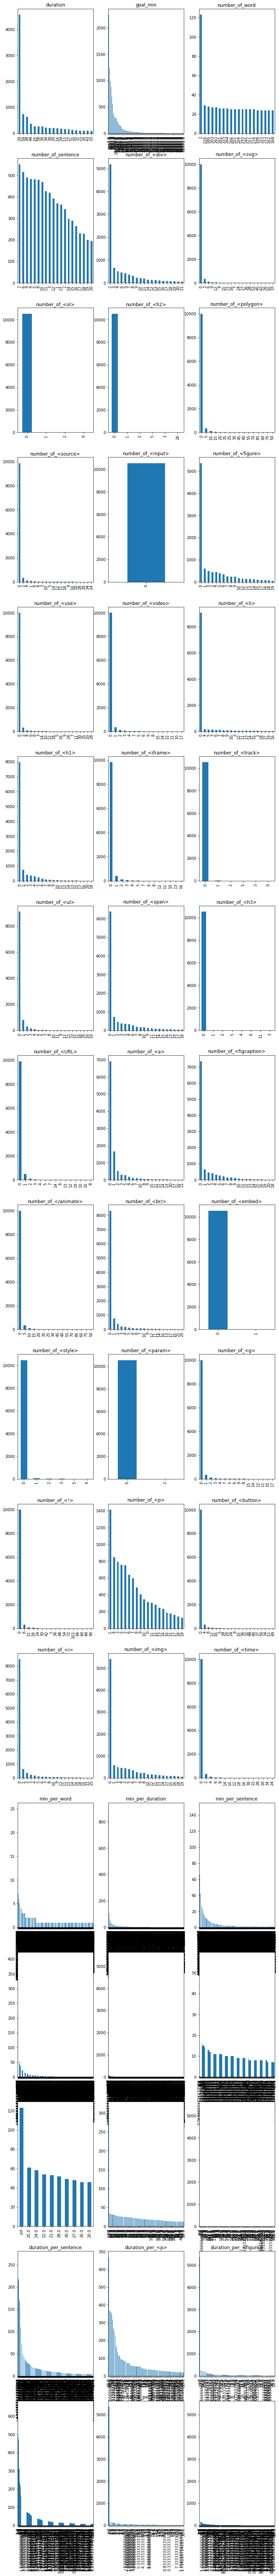

In [117]:
eda(train_set)

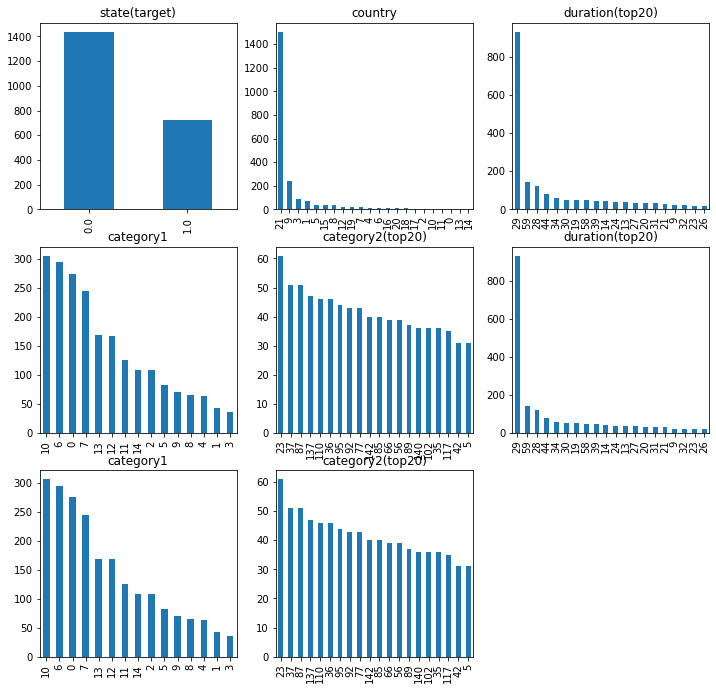

In [69]:
eda(train_wrong)

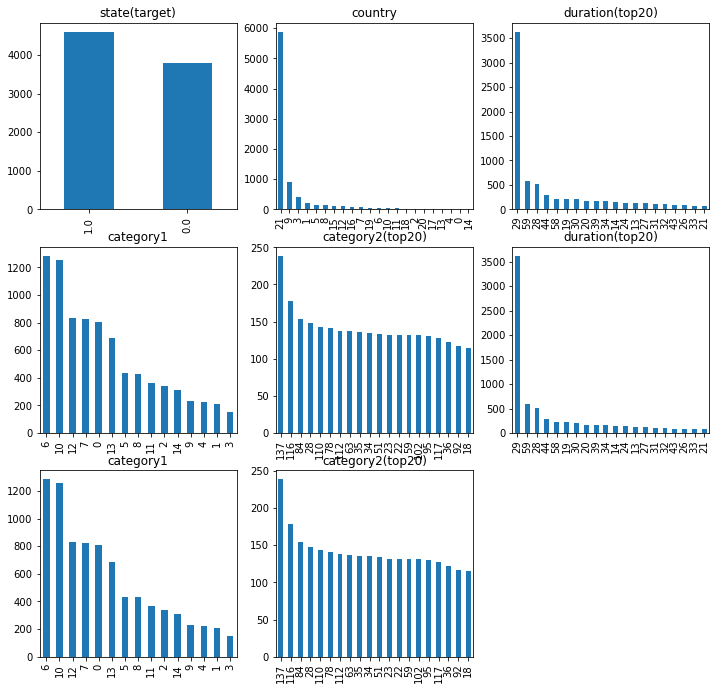

In [70]:
eda(train_right)